In [2]:
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
matplotlib.rcParams['text.usetex'] = True
import pandas as pd
import numpy as np
import random
import os
from scipy.sparse.linalg.eigen.arpack import eigsh as largest_eigsh
import time
import networkx as nx
from sklearn.cluster import KMeans

plt.rcParams['axes.unicode_minus']=False

path = 'result/grid_search'
if not os.path.exists(path):
    os.makedirs(path)
    

class Timer(object):
    def __enter__(self):
        self.t0 = time.time()
    def __exit__(self, exc_type, exc_val, exc_tb):
        print('[time spent: {time:.2f}s]'.format(time = time.time() - self.t0))

# inputscaling

In [5]:
t0 = time.time()
seed = 42
random.seed(seed) 
np.random.seed(seed)

for inputdata, dim in zip(
    [
        'x',
        'y',
        'z', 
        'xyz',
        'xy',
        'yz',
        'xz'
    ],[
        [0],
        [1],
        [2],
        [0,1,2],
        [0,1],
        [1,2],
        [0,2]
    ]):
    print(inputdata)

    Y = np.loadtxt('dataset/matlab_gendata/'+system_name+'.csv', delimiter=',').T
    U0 = Y[dim].copy()
    U = U0 + np.random.randn(*U0.shape)*1e-3
    U = np.atleast_2d(U)

    num_prepare = 1000
    train_start = num_prepare
    num_train = 10000
    val_start = num_prepare + num_train
    num_val = 1000
    test_start = num_prepare + num_train + num_val
    num_test = 5000
    print('U shape:', U.shape)
    print('Y shape:', Y.shape)


    inSize = U.shape[0]
    outSize = 3  
    resSize = 100
    reg = 1e-6 

    U_train = U[:,train_start : train_start + num_train]
    Y_train = Y[:,train_start + 1 : train_start + num_train + 1]


    filename = path+'/system={},seed={},Nx={},input={}'.format(system_name,seed, resSize, inputdata) + '.csv'
    if os.path.exists(filename):
        os.remove(filename)

    times=0
    for a in [0.1*i for i in range(1, 11)]:           # leaking rate
        for K in [0.2*i for i in range(1,11)]:          # spectial redius
          # regularization coefficient 
            for input_scaling in [0.2*i for i in range(1,11)]:

                times += 1
                if times %100 == 0:
                    print(times)

                # generation of random weights
                random.seed(seed) 
                np.random.seed(seed)

                Win = (np.random.rand(resSize,1+inSize)-0.5) * (input_scaling * 2)
                W = np.random.rand(resSize,resSize)-0.5
                largest_eigvals, _ = largest_eigsh(W@W.T, 1, which='LM')
                rhoW = np.sqrt(largest_eigvals[0])
                W = W/rhoW*K 

                X = np.zeros((resSize,U.shape[1]))
                x = np.zeros([resSize,1])
                for t in range(U.shape[1]):
                    u = U[:,t:t+1]
                    x = (1-a) * x + a * np.tanh(Win @ np.vstack((1,u)) + W @ x) 
                    X[:,t:t+1] = x

                # offline train
                X_train = X[:,train_start : train_start + num_train]
                H = np.vstack((np.ones((1,X_train.shape[1])),X_train))

                Wout = Y_train @ H.T @ np.linalg.inv( H @ H.T + reg*np.eye(H.shape[0]))
#                 err = np.average(np.square(Y_train - Wout@H), axis=1)

                X_test = X[:,test_start : test_start + num_test]
                Y_test = Y[:,test_start + 1 : test_start + num_test + 1]
                err = Y_test - Wout @ np.vstack((np.ones((1,X_test.shape[1])),X_test))
                err = np.average(np.square(err), axis=1)

                with open(filename, 'a') as file:
                    file.write('{},{},{},{},{},{}\n'.format(round(a,2), round(K,2), round(input_scaling,2), err[0],err[1],err[2]))

    print('[time spent: {time:.2f}s]'.format(time = time.time() - t0))

x
U shape: (1, 20000)
Y shape: (3, 20000)
100
200
300
400
500
600
700
800
900
1000
[time spent: 351.35s]
y
U shape: (1, 20000)
Y shape: (3, 20000)
100
200
300
400
500
600
700
800
900
1000
[time spent: 700.70s]
z
U shape: (1, 20000)
Y shape: (3, 20000)
100
200
300
400
500
600
700
800
900
1000
[time spent: 1048.93s]
xyz
U shape: (3, 20000)
Y shape: (3, 20000)
100
200
300
400
500
600
700
800
900
1000
[time spent: 1400.18s]
xy
U shape: (2, 20000)
Y shape: (3, 20000)
100
200
300
400
500
600
700
800
900
1000
[time spent: 1751.94s]
yz
U shape: (2, 20000)
Y shape: (3, 20000)
100
200
300
400
500
600
700
800
900
1000
[time spent: 2105.36s]
xz
U shape: (2, 20000)
Y shape: (3, 20000)
100
200
300
400
500
600
700
800
900
1000
[time spent: 2462.35s]


# ATTN

In [120]:
t0 = time.time()
seed = 42
random.seed(seed) 
np.random.seed(seed)

def pairwise_distances(X, Y):
    D = -2 * X @ Y.T + np.sum(Y ** 2, axis=1) + np.sum(X ** 2, axis=1)[:, np.newaxis]
    D[D < 0] = 0
    return D

def clustering(data, N_c):
    estimator = KMeans(init='random', n_clusters=N_c, n_init=3)
    estimator.fit(data)
    return estimator.cluster_centers_

def svht(X, sigma=None, sv=None):
    """Return the optimal singular value hard threshold (SVHT) value.
    `X` is any m-by-n matrix. `sigma` is the standard deviation of the 
    noise, if known. Optionally supply the vector of singular values `sv`
    for the matrix (only necessary when `sigma` is unknown). If `sigma`
    is unknown and `sv` is not supplied, then the method automatically
    computes the singular values."""
    def omega_approx(beta):
        """Return an approximate omega value for given beta. Equation (5) from Gavish 2014."""
        return 0.56 * beta**3 - 0.95 * beta**2 + 1.82 * beta + 1.43

    def lambda_star(beta):
        """Return lambda star for given beta. Equation (11) from Gavish 2014."""
        return np.sqrt(2 * (beta + 1) + (8 * beta) / 
                   (beta + 1 + np.sqrt(beta**2 + 14 * beta + 1)))

    try:
        m,n = sorted(X.shape) # ensures m <= n
    except:
        raise ValueError('invalid input matrix')
    beta = m / n # ratio between 0 and 1
    if sigma is None: # sigma unknown
        if sv is None:
            sv = svdvals(X)
        sv = np.squeeze(sv)
        if sv.ndim != 1:
            raise ValueError('vector of singular values must be 1-dimensional')
        return np.median(sv) * omega_approx(beta)
    else: # sigma known
        return lambda_star(beta) * np.sqrt(n) * sigma

for inputdata, dim in zip(
    [
        'x',
#         'y',
#         'z', 
#         'xyz'
#         'xy',
#         'yz',
#         'xz'
    ],[
        [0],
#         [1],
#         [2],
#         [0,1,2]
#         [0,1],
#         [1,2],
#         [0,2]
    ]):
    print(inputdata)

    Y = np.loadtxt('dataset/matlab_gendata/'+system_name+'.csv', delimiter=',').T
    U0 = Y[dim].copy()
    U = U0 + np.random.randn(*U0.shape)*1e-3
    U = np.atleast_2d(U)

    num_prepare = 1000
    train_start = num_prepare
    num_train = 10000
    # val_start = num_prepare + num_train
    # num_val = 1000
    test_start = num_prepare + num_train + num_val
    num_test = 5000
    print('U shape:', U.shape)
    print('Y shape:', Y.shape)


    inSize = U.shape[0]
    outSize = 3  
    resSize = 100
    reg = 1e-6 
    N_c = 100

    U_train = U[:,train_start : train_start + num_train]
    Y_train = Y[:,train_start + 1 : train_start + num_train + 1]


    filename = path+'/attn,system={},seed={},Nx={},input={}'.format(system_name,seed, resSize, inputdata) + '.csv'
    if os.path.exists(filename):
        os.remove(filename)

    times=0
    for a in [0.1*i for i in range(1,11)]:           # leaking rate
        for K in [0.2*i for i in range(11)]:          # spectial redius
          # regularization coefficient 
            for input_scaling in [0.2*i for i in range(1,11)]:

                times += 1
                if times %100 == 0:
                    print(times)

                # generation of random weights
                random.seed(seed) 
                np.random.seed(seed)

                Win = (np.random.rand(resSize,1+inSize)-0.5) * (input_scaling * 2)
                W = np.random.rand(resSize,resSize)-0.5
                largest_eigvals, _ = largest_eigsh(W@W.T, 1, which='LM')
                rhoW = np.sqrt(largest_eigvals[0])
                W = W/rhoW*K 

                X = np.zeros((resSize,U.shape[1]))
                x = np.zeros([resSize,1])
                for t in range(U.shape[1]):
                    u = U[:,t:t+1]
                    x = (1-a) * x + a * np.tanh(Win @ np.vstack((1,u)) + W @ x) 
                    X[:,t:t+1] = x

                # offline train
                X_train = X[:,train_start : train_start + num_train]
                Ml, Diag, Mr = np.linalg.svd(X_train, full_matrices=False)
                tau = svht(X_train, sv=Diag)
                N_v = np.sum(Diag>tau)
                MlT, Diag, Mr = Ml.T[:N_v], Diag[:N_v], Mr[:N_v]


                X_test = X[:,test_start : test_start + num_test]
                Y_test = Y[:,test_start + 1 : test_start + num_test + 1]

                Cs = clustering((np.diag(Diag)@ Mr).T, N_c)  # N_c, N_v

                  
                choices = []
                
                for beta in [1/16, 1/8, 1/4, 1/2, 1, 2, 4, 8, 16]:
                    S = np.exp(- beta * pairwise_distances(Cs, (np.diag(Diag)@ Mr).T))
                    H = np.vstack((np.ones((1,num_train)), X_train, S))
                    Wout = Y_train @ H.T @ np.linalg.inv( H @ H.T + reg*np.eye(H.shape[0]))
                                 
                    S = np.exp( - beta* pairwise_distances(Cs, (MlT @ X_test).T))
                    H = np.vstack((np.ones((1,num_test)), X_test, S))
                    mse = np.average(np.square(Wout @ H - Y_test), axis=1)
                    choices.append((np.min(mse),mse, beta, Wout))
                _,err, beta, Wout = sorted(choices)[0]
                
                

                with open(filename, 'a') as file:
                    file.write('{},{},{},{},{},{}\n'.format(round(a,2), round(K,2), round(input_scaling,2), err[0],err[1],err[2]))

    print('[time spent: {time:.2f}s]'.format(time = time.time() - t0))

x
U shape: (1, 20000)
Y shape: (3, 20000)
100
200
300
400
500
600
700
800
900
1000
1100
[time spent: 1638.65s]
y
U shape: (1, 20000)
Y shape: (3, 20000)
100
200
300
400
500
600
700
800
900
1000
1100
[time spent: 3427.61s]
z
U shape: (1, 20000)
Y shape: (3, 20000)
100
200
300
400
500
600
700
800
900
1000
1100
[time spent: 5356.16s]
xyz
U shape: (3, 20000)
Y shape: (3, 20000)
100


KeyboardInterrupt: 

# bayesian optimization

In [37]:
def black_box(a, K, inputscaling, reg=1e-6):

    W = W0/rhoW*K 
    Win = Win0*inputscaling
    X = np.zeros((resSize,U.shape[1]))
    x = np.zeros([resSize,1])
    for t in range(U.shape[1]):
        u = U[:,t:t+1]
        x = (1-a) * x + a * np.tanh(Win @ np.vstack((1,u)) + W @ x) 
        X[:,t:t+1] = x

    X_train = X[:,train_start : train_start + num_train]
    H = np.vstack((np.ones((1,X_train.shape[1])),X_train))
    Wout = Y_train @ H.T @ np.linalg.inv( H @ H.T + reg*np.eye(H.shape[0]))
    X_test = X[:,test_start : test_start + num_test]
    err = Y_test - Wout @ np.vstack((np.ones((1,X_test.shape[1])),X_test))
    err = np.min(np.average(np.square(err), axis=1))
    return -np.log10(err)

def multistep_prediction(a, K, inputscaling, reg=1e-6):

    W = W0/rhoW*K 
    Win = Win0*inputscaling
    X = np.zeros((resSize,U.shape[1]))
    x = np.zeros([resSize,1])

    for t in range(U.shape[1]):
        u = U[:,t:t+1]
        x = (1-a) * x + a * np.tanh(Win @ np.vstack((1,u)) + W @ x) 
        X[:,t:t+1] = x

    X_train = X[:,train_start : train_start + num_train]
    H = np.vstack((np.ones((1,X_train.shape[1])),X_train))
    Wout = Y_train @ H.T @ np.linalg.inv( H @ H.T + reg*np.eye(H.shape[0]))

    horizon = 100
    mse = []
    for h in range(horizon):
        if h == 0:
            U_test = U[:,test_start : test_start + num_test]
            X_test = X[:,test_start : test_start + num_test]
        else:
            U_test = Y_pred 
            X_test = (1-a) * X_test + a * np.tanh( Win @ np.vstack((np.ones((1,num_test)),U_test)) + W @ X_test )

        H = np.vstack((np.ones((1,num_test)),X_test))
        Y_pred = Wout @ H
        Y_true = Y[dim,test_start+h+1 : test_start + num_test + h+1]
        err = np.min(np.average(np.square(Wout @ H - Y_true), axis=1))
        mse.append(-np.log10(err))
    plt.figure()
    plt.plot(mse) 
    plt.yscale('log')
    plt.show()
    print(mse[0], mse[9],mse[19],mse[29])

x
U shape: (1, 20000)
Y shape: (3, 20000)
|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  1        |  5.094    |  1.251    |  0.7203   |  0.000344 |
|  2        |  5.503    |  0.907    |  0.1468   |  0.277    |
|  3        |  5.949    |  0.5588   |  0.3456   |  1.19     |
|  4        |  6.264    |  1.616    |  0.4192   |  2.056    |
|  5        |  5.583    |  0.6134   |  0.8781   |  0.08216  |
|  6        |  6.366    |  2.011    |  0.4173   |  1.676    |
|  7        |  6.202    |  0.4212   |  0.1981   |  2.402    |
|  8        |  6.291    |  2.905    |  0.3134   |  2.077    |
|  9        |  5.974    |  2.629    |  0.8946   |  0.2551   |
|  10       |  5.612    |  0.1172   |  0.1698   |  2.634    |
|  11       |  6.293    |  1.919    |  0.4696   |  1.931    |
|  12       |  6.401    |  2.346    |  0.3361   |  1.706    |
|  13       |  6.406    |  2.63     |  0.4051   |  1.334    |
|  14       |  6.303    |  2

|  79       |  6.529    |  2.373    |  0.2903   |  1.308    |
|  80       |  6.529    |  2.373    |  0.2903   |  1.309    |
|  81       |  6.529    |  2.373    |  0.2903   |  1.309    |
|  82       |  6.528    |  2.373    |  0.2903   |  1.309    |
|  83       |  6.528    |  2.372    |  0.2903   |  1.309    |
|  84       |  6.529    |  2.373    |  0.2903   |  1.309    |
|  85       |  6.529    |  2.373    |  0.2903   |  1.309    |
|  86       |  6.529    |  2.373    |  0.2903   |  1.309    |
|  87       |  6.529    |  2.373    |  0.2903   |  1.309    |
|  88       |  6.529    |  2.373    |  0.2903   |  1.309    |
|  89       |  6.529    |  2.372    |  0.2903   |  1.309    |
|  90       |  6.529    |  2.372    |  0.2903   |  1.309    |
|  91       |  6.529    |  2.372    |  0.2903   |  1.309    |
|  92       |  6.529    |  2.372    |  0.2903   |  1.309    |
|  93       |  6.529    |  2.373    |  0.2903   |  1.309    |
|  94       |  6.529    |  2.373    |  0.2903   |  1.309    |
|  95   

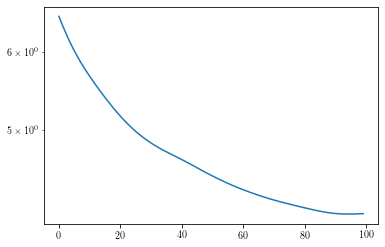

6.529655992531336 5.736343858344782 5.209318266104738 4.8745078997943665


In [49]:
from bayes_opt import BayesianOptimization
from bayes_opt import SequentialDomainReductionTransformer

for inputdata, dim in zip(
    [
        'x',
#         'y',
#         'z', 
#         'xyz'
#         'xy',
#         'yz',
#         'xz'
    ],[
        [0],
#         [1],
#         [2],
#         [0,1,2]
#         [0,1],
#         [1,2],
#         [0,2]
    ]):
    print(inputdata)
    system_name = 'Chua'
    Y = np.loadtxt('dataset/matlab_gendata/'+system_name+'.csv', delimiter=',').T
    U0 = Y[dim].copy()
    U = U0 + np.random.randn(*U0.shape)*1e-3
    U = np.atleast_2d(U)

    num_prepare = 1000
    train_start = num_prepare
    num_train = 10000
    val_start = num_prepare + num_train
    num_val = 1000
    test_start = num_prepare + num_train + num_val
    num_test = 5000
    print('U shape:', U.shape)
    print('Y shape:', Y.shape)


    inSize = U.shape[0]
    outSize = inSize
    resSize = 300

    U_train = U[:,train_start : train_start + num_train]
    Y_train = Y[dim,train_start + 1 : train_start + num_train + 1]
    Y_test = Y[dim,test_start + 1 : test_start + num_test + 1]

    seed = 42
    random.seed(seed) 
    np.random.seed(seed)
    Win0 = (np.random.rand(resSize,1+inSize)-0.5) * 2
    W0 = np.random.rand(resSize,resSize)-0.5
    largest_eigvals, _ = largest_eigsh(W0@W0.T, 1, which='LM')
    rhoW = np.sqrt(largest_eigvals[0])


    # Bounded region of parameter space
    eps = 1e-6
    pbounds = {
        'a': (eps, 1), 
        'K': (eps, 3),
        'inputscaling': (eps,3),
    }
    
    bounds_transformer = SequentialDomainReductionTransformer()


    optimizer = BayesianOptimization(
        f=black_box,
        pbounds=pbounds,
        verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
        random_state=1,
        bounds_transformer=bounds_transformer
    )
    
#     optimizer.probe(
#         params=[0.1,1.9,1.0,1e-6],
#         lazy=True,
#     )
    
    optimizer.maximize(
        init_points=10,
        n_iter=100,
        acq="ei", xi=1e-4
    )
    
    print(optimizer.max)
    params = optimizer.max['params']
    a, K, inputscaling  = params['a'], params['K'], params['inputscaling'],
    multistep_prediction(a, K, inputscaling)


# bayesian optimization for attn

In [194]:
def black_box_attn(a, K, inputscaling, beta, N_c = 100, reg=1e-6):

    W = W0/rhoW*K 
    Win = Win0*inputscaling
    X = np.zeros((resSize,U.shape[1]))
    x = np.zeros([resSize,1])
    for t in range(U.shape[1]):
        u = U[:,t:t+1]
        x = (1-a) * x + a * np.tanh(Win @ np.vstack((1,u)) + W @ x) 
        X[:,t:t+1] = x

    X_train = X[:,train_start : train_start + num_train]
    
    Ml, Diag, Mr = np.linalg.svd(X_train, full_matrices=False)
    tau = svht(X_train, sv=Diag)
    N_v = np.sum(Diag>tau)
    MlT, Diag, Mr = Ml.T[:N_v], Diag[:N_v], Mr[:N_v]

    Cs = clustering((np.diag(Diag)@ Mr).T, N_c)  # N_c, N_v

    S = np.exp(- 2**beta * pairwise_distances(Cs, (np.diag(Diag)@ Mr).T))
    H = np.vstack((np.ones((1,num_train)), X_train, S))
    Wout = Y_train @ H.T @ np.linalg.inv( H @ H.T + reg*np.eye(H.shape[0]))

    X_test = X[:,test_start : test_start + num_test]
    S = np.exp( - 2**beta* pairwise_distances(Cs, (MlT @ X_test).T))
    H = np.vstack((np.ones((1,num_test)), X_test, S))
    err = np.min(np.average(np.square(Wout @ H - Y_test), axis=1))
    return -np.log10(err)


def multistep_prediction_attn(a, K, inputscaling, beta, N_c = 100, reg=1e-6):

    W = W0/rhoW*K 
    Win = Win0*inputscaling
    X = np.zeros((resSize,U.shape[1]))
    x = np.zeros([resSize,1])
    for t in range(U.shape[1]):
        u = U[:,t:t+1]
        x = (1-a) * x + a * np.tanh(Win @ np.vstack((1,u)) + W @ x) 
        X[:,t:t+1] = x
    X_train = X[:,train_start : train_start + num_train]  
    Ml, Diag, Mr = np.linalg.svd(X_train, full_matrices=False)
    tau = svht(X_train, sv=Diag)
    N_v = np.sum(Diag>tau)
    MlT, Diag, Mr = Ml.T[:N_v], Diag[:N_v], Mr[:N_v]
    Cs = clustering((np.diag(Diag)@ Mr).T, N_c)  # N_c, N_v
    S = np.exp(- 2**beta * pairwise_distances(Cs, (np.diag(Diag)@ Mr).T))
    H = np.vstack((np.ones((1,num_train)), X_train, S))
    Wout = Y_train @ H.T @ np.linalg.inv( H @ H.T + reg*np.eye(H.shape[0]))

    X_test = X[:,test_start : test_start + num_test]
    horizon = 100
    mse = []
    for h in range(horizon):
        if h == 0:
            U_test = U[:,test_start : test_start + num_test]
            X_test = X[:,test_start : test_start + num_test]
        else:
            U_test = Y_pred[dim] 
            X_test = (1-a) * X_test + a * np.tanh( Win @ np.vstack((np.ones((1,num_test)),U_test)) + W @ X_test )

        S = np.exp( - 2**beta* pairwise_distances(Cs, (MlT @ X_test).T))
        H = np.vstack((np.ones((1,num_test)), X_test, S))
        Y_pred = Wout @ H
        Y_true = Y[dim,test_start+h+1 : test_start + num_test + h+1]
        err = np.min(np.average(np.square(Wout @ H - Y_true), axis=1))
        mse.append(err)
    plt.figure()
    plt.plot(mse) 
    plt.yscale('log')
    plt.show()
    
def pairwise_distances(X, Y):
    D = -2 * X @ Y.T + np.sum(Y ** 2, axis=1) + np.sum(X ** 2, axis=1)[:, np.newaxis]
    D[D < 0] = 0
    return D

def clustering(data, N_c):
    estimator = KMeans(init='random', n_clusters=N_c, n_init=3)
    estimator.fit(data)
    return estimator.cluster_centers_

def svht(X, sigma=None, sv=None):
    """Return the optimal singular value hard threshold (SVHT) value.
    `X` is any m-by-n matrix. `sigma` is the standard deviation of the 
    noise, if known. Optionally supply the vector of singular values `sv`
    for the matrix (only necessary when `sigma` is unknown). If `sigma`
    is unknown and `sv` is not supplied, then the method automatically
    computes the singular values."""
    def omega_approx(beta):
        """Return an approximate omega value for given beta. Equation (5) from Gavish 2014."""
        return 0.56 * beta**3 - 0.95 * beta**2 + 1.82 * beta + 1.43

    def lambda_star(beta):
        """Return lambda star for given beta. Equation (11) from Gavish 2014."""
        return np.sqrt(2 * (beta + 1) + (8 * beta) / 
                   (beta + 1 + np.sqrt(beta**2 + 14 * beta + 1)))

    try:
        m,n = sorted(X.shape) # ensures m <= n
    except:
        raise ValueError('invalid input matrix')
    beta = m / n # ratio between 0 and 1
    if sigma is None: # sigma unknown
        if sv is None:
            sv = svdvals(X)
        sv = np.squeeze(sv)
        if sv.ndim != 1:
            raise ValueError('vector of singular values must be 1-dimensional')
        return np.median(sv) * omega_approx(beta)
    else: # sigma known
        return lambda_star(beta) * np.sqrt(n) * sigma


In [195]:
from bayes_opt import BayesianOptimization
from bayes_opt import SequentialDomainReductionTransformer

filename = path+'/attn_bayesopt.csv'
if os.path.exists(filename):
    os.remove(filename)

for inputdata, dim in zip(
    [
        'x',
#         'y',
#         'z', 
#         'xyz'
#         'xy',
#         'yz',
#         'xz'
    ],[
        [0],
#         [1],
#         [2],
#         [0,1,2]
#         [0,1],
#         [1,2],
#         [0,2]
    ]):
    print(inputdata)
    system_name = 'Lorenz'
    Y = np.loadtxt('dataset/matlab_gendata/'+system_name+'.csv', delimiter=',').T
    U0 = Y[dim].copy()
    U = U0 + np.random.randn(*U0.shape)*1e-3
    U = np.atleast_2d(U)

    num_prepare = 1000
    train_start = num_prepare
    num_train = 10000
    val_start = num_prepare + num_train
    num_val = 1000
    test_start = num_prepare + num_train + num_val
    num_test = 5000
    print('U shape:', U.shape)
    print('Y shape:', Y.shape)


    inSize = U.shape[0]
    resSize = 100

    U_train = U[:,train_start : train_start + num_train]
    Y_train = Y[dim,train_start + 1 : train_start + num_train + 1]
    Y_test = Y[dim,test_start + 1 : test_start + num_test + 1]

        
    for seed in range(100):
        random.seed(seed) 
        np.random.seed(seed)

        Win0 = (np.random.rand(resSize,1+inSize)-0.5) * 2
        W0 = np.random.rand(resSize,resSize)-0.5
        largest_eigvals, _ = largest_eigsh(W0@W0.T, 1, which='LM')
        rhoW = np.sqrt(largest_eigvals[0])


        # Bounded region of parameter space
        eps = 1e-8
        pbounds = {
            'a': (eps, 1), 
            'K': (eps, 3),
            'inputscaling': (eps,2),
            'beta':(0,5)
        }

        bounds_transformer = SequentialDomainReductionTransformer()

        optimizer = BayesianOptimization(
            f=black_box_attn,
            pbounds=pbounds,
            verbose=1, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
            random_state=1,
#             bounds_transformer=bounds_transformer
        )

        optimizer.maximize(
            init_points=10,
            n_iter=100,
        )

        print(optimizer.max)
     
        params = optimizer.max['params']
        target = optimizer.max['target']
        a, K, inputscaling, beta = params['a'], params['K'], params['inputscaling'], params['beta']

        multistep_prediction_attn(a, K, inputscaling, beta)

        with open(filename, 'a') as file:
            file.write('{},{},{},{},{},{}\n'.format(seed, target, a, K, inputscaling, beta))



x
U shape: (1, 20000)
Y shape: (3, 20000)
|   iter    |  target   |     K     |     a     |   beta    | inputs... |
-------------------------------------------------------------------------
|  3        |  6.149    |  1.19     |  0.5388   |  2.096    |  1.37     |
|  5        |  6.18     |  1.252    |  0.5587   |  0.7019   |  0.3962   |


KeyboardInterrupt: 

x
U shape: (1, 20000)
Y shape: (3, 20000)
|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.058e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.443e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.249e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.783e-0 |  2.011    |  0.4173   |  1.117    |
|  12       | -2.587e-0 |  2.314    |  0.2447   |  1.536    |
|  51       | -2.548e-0 |  2.264    |  0.2364   |  1.75     |
{'target': -2.547755919052559e-07, 'params': {'K': 2.2641085142616175, 'a': 0.23637653687262988, 'inputscaling': 1.7503810128100927}}


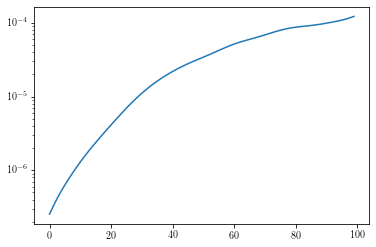

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.195e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.462e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.627e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.942e-0 |  2.011    |  0.4173   |  1.117    |
|  51       | -2.795e-0 |  2.264    |  0.2364   |  1.75     |
|  70       | -2.688e-0 |  2.466    |  0.1759   |  1.262    |
|  92       | -2.621e-0 |  2.378    |  0.1409   |  1.585    |
|  98       | -2.424e-0 |  2.23     |  0.1594   |  1.618    |
{'target': -2.423933323363381e-07, 'params': {'K': 2.2301307907908505, 'a': 0.15942134503489125, 'inputscaling': 1.6175180570889387}}


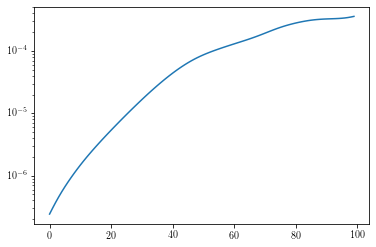

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -8.79e-07 |  0.907    |  0.1468   |  0.1847   |
|  3        | -8.602e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.928e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.816e-0 |  2.011    |  0.4173   |  1.117    |
|  21       | -3.707e-0 |  2.031    |  0.5479   |  0.7664   |
|  29       | -3.324e-0 |  1.726    |  0.2553   |  0.4797   |
|  40       | -2.923e-0 |  2.067    |  0.339    |  0.428    |
|  51       | -2.904e-0 |  2.264    |  0.2364   |  1.75     |
|  92       | -2.867e-0 |  2.378    |  0.1409   |  1.585    |
{'target': -2.8672338291350836e-07, 'params': {'K': 2.377866148323864, 'a': 0.14090313560409995, 'inputscaling': 1.5845232035561652}}


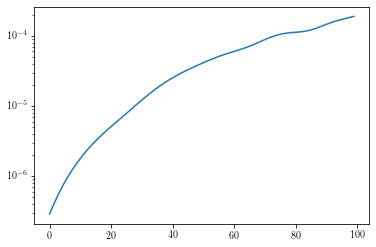

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.138e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.369e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.525e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.311e-0 |  2.011    |  0.4173   |  1.117    |
|  59       | -2.848e-0 |  1.906    |  0.1657   |  2.0      |
|  92       | -2.698e-0 |  2.378    |  0.1409   |  1.585    |
{'target': -2.698164103852588e-07, 'params': {'K': 2.377866148323864, 'a': 0.14090313560409995, 'inputscaling': 1.5845232035561652}}


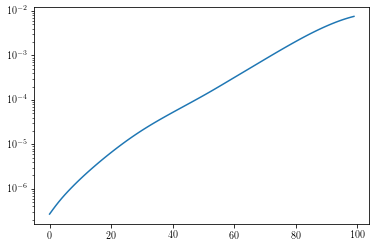

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -9.44e-07 |  0.907    |  0.1468   |  0.1847   |
|  4        | -4.741e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -4.166e-0 |  2.011    |  0.4173   |  1.117    |
|  8        | -3.384e-0 |  2.905    |  0.3134   |  1.385    |
|  51       | -2.594e-0 |  2.264    |  0.2364   |  1.75     |
|  56       | -2.301e-0 |  2.486    |  0.1458   |  1.091    |
|  58       | -2.025e-0 |  2.026    |  0.1403   |  1.458    |
|  92       | -1.795e-0 |  2.378    |  0.1409   |  1.585    |
{'target': -1.7949926534476241e-07, 'params': {'K': 2.377866148323864, 'a': 0.14090313560409995, 'inputscaling': 1.5845232035561652}}


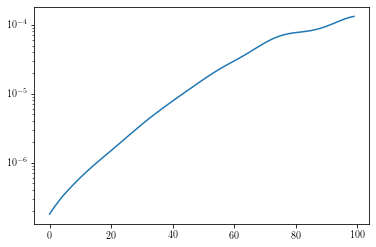

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -9.241e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -8.857e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -5.045e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.739e-0 |  2.011    |  0.4173   |  1.117    |
|  8        | -3.646e-0 |  2.905    |  0.3134   |  1.385    |
|  28       | -3.621e-0 |  2.469    |  0.3978   |  1.391    |
|  51       | -2.7e-07  |  2.264    |  0.2364   |  1.75     |
|  63       | -2.468e-0 |  1.377    |  0.0433   |  1.974    |
{'target': -2.4683678226284473e-07, 'params': {'K': 1.37671827557787, 'a': 0.043299199431029584, 'inputscaling': 1.9743300748839636}}


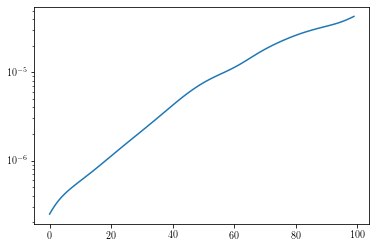

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -9.74e-07 |  0.907    |  0.1468   |  0.1847   |
|  4        | -4.997e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -4.181e-0 |  2.011    |  0.4173   |  1.117    |
|  8        | -3.77e-07 |  2.905    |  0.3134   |  1.385    |
|  29       | -3.303e-0 |  1.392    |  0.1358   |  1.135    |
|  31       | -3.226e-0 |  2.412    |  0.318    |  1.213    |
|  34       | -3.21e-07 |  1.795    |  0.1151   |  0.8183   |
|  51       | -2.988e-0 |  2.264    |  0.2364   |  1.75     |
|  92       | -1.792e-0 |  2.378    |  0.1409   |  1.585    |
{'target': -1.7915260814713912e-07, 'params': {'K': 2.377866148323864, 'a': 0.14090313560409995, 'inputscaling': 1.5845232035561652}}


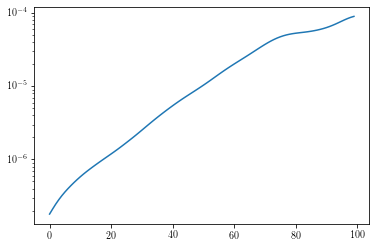

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.424e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.014e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -5.27e-07 |  1.616    |  0.4192   |  1.37     |
|  6        | -4.473e-0 |  2.011    |  0.4173   |  1.117    |
|  8        | -3.438e-0 |  2.905    |  0.3134   |  1.385    |
|  31       | -3.312e-0 |  2.412    |  0.318    |  1.213    |
|  34       | -2.767e-0 |  1.795    |  0.1151   |  0.8183   |
|  86       | -2.703e-0 |  2.476    |  0.1199   |  1.117    |
|  92       | -2.548e-0 |  2.378    |  0.1409   |  1.585    |
{'target': -2.548356457034258e-07, 'params': {'K': 2.377866148323864, 'a': 0.14090313560409995, 'inputscaling': 1.5845232035561652}}


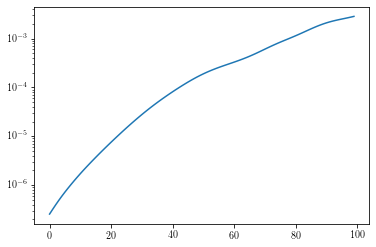

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.046e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.039e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -5.164e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -4.424e-0 |  2.011    |  0.4173   |  1.117    |
|  8        | -3.543e-0 |  2.905    |  0.3134   |  1.385    |
|  47       | -3.307e-0 |  1.284    |  0.1532   |  2.0      |
|  59       | -2.846e-0 |  1.991    |  0.1865   |  1.491    |
|  67       | -2.786e-0 |  2.441    |  0.1487   |  1.25     |
|  86       | -2.599e-0 |  2.476    |  0.1199   |  1.117    |
{'target': -2.5993682466345545e-07, 'params': {'K': 2.476238896841205, 'a': 0.11989189479884392, 'inputscaling': 1.1166177170910367}}


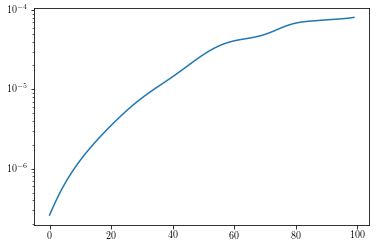

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.007e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -7.989e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.128e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.549e-0 |  2.011    |  0.4173   |  1.117    |
|  51       | -2.778e-0 |  2.264    |  0.2364   |  1.75     |
|  58       | -2.591e-0 |  2.3      |  0.1391   |  1.425    |
|  59       | -2.584e-0 |  1.901    |  0.2062   |  1.39     |
|  61       | -2.009e-0 |  2.128    |  0.1217   |  1.139    |
{'target': -2.009328679341664e-07, 'params': {'K': 2.128461999556048, 'a': 0.12170396548955494, 'inputscaling': 1.1391378228809208}}


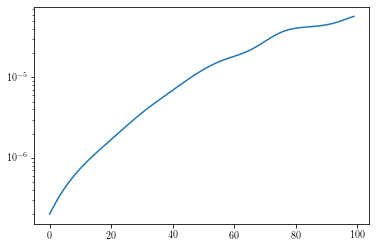

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -9.842e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -8.321e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.617e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.695e-0 |  2.011    |  0.4173   |  1.117    |
|  12       | -3.112e-0 |  2.249    |  0.3343   |  1.629    |
|  36       | -2.92e-07 |  1.521    |  0.1024   |  2.0      |
|  51       | -2.348e-0 |  2.264    |  0.2364   |  1.75     |
|  92       | -2.228e-0 |  2.378    |  0.1409   |  1.585    |
{'target': -2.228290145171109e-07, 'params': {'K': 2.377866148323864, 'a': 0.14090313560409995, 'inputscaling': 1.5845232035561652}}


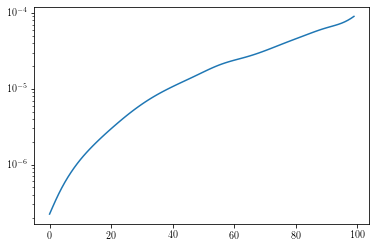

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -7.838e-0 |  0.907    |  0.1468   |  0.1847   |
|  4        | -4.616e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.551e-0 |  2.011    |  0.4173   |  1.117    |
|  47       | -2.77e-07 |  1.284    |  0.1519   |  2.0      |
|  59       | -2.408e-0 |  1.991    |  0.1864   |  1.491    |
|  92       | -2.064e-0 |  2.378    |  0.1409   |  1.585    |
{'target': -2.06385005256447e-07, 'params': {'K': 2.377866148323864, 'a': 0.14090313560409995, 'inputscaling': 1.5845232035561652}}


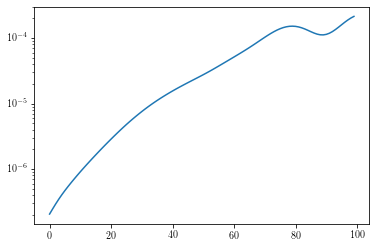

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -9.366e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -8.762e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.678e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.924e-0 |  2.011    |  0.4173   |  1.117    |
|  30       | -3.277e-0 |  2.004    |  0.08873  |  0.6335   |
|  51       | -3.126e-0 |  2.264    |  0.2364   |  1.75     |
{'target': -3.126095953907513e-07, 'params': {'K': 2.2641085142616175, 'a': 0.23637653687262988, 'inputscaling': 1.7503810128100927}}


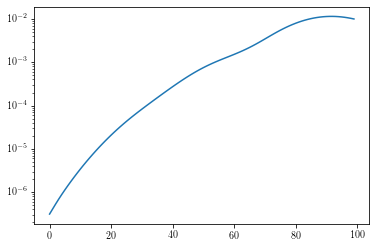

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.264e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.459e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.663e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.239e-0 |  2.011    |  0.4173   |  1.117    |
|  11       | -2.689e-0 |  2.382    |  0.3318   |  1.497    |
|  61       | -2.535e-0 |  2.169    |  0.31     |  1.314    |
{'target': -2.5353912044314235e-07, 'params': {'K': 2.1690245493854943, 'a': 0.3099859115454446, 'inputscaling': 1.314151373075342}}


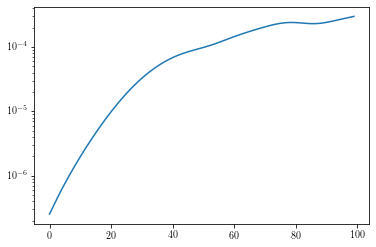

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -8.748e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -8.443e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.905e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.869e-0 |  2.011    |  0.4173   |  1.117    |
|  29       | -3.828e-0 |  1.697    |  0.2575   |  0.4833   |
|  51       | -3.118e-0 |  2.264    |  0.2364   |  1.75     |
|  56       | -2.396e-0 |  1.419    |  0.1196   |  1.966    |
{'target': -2.3960841885509447e-07, 'params': {'K': 1.4194262297917644, 'a': 0.11963675277346225, 'inputscaling': 1.9658245929721871}}


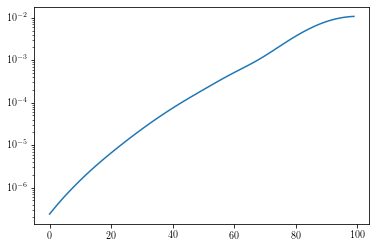

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.419e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -1.009e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -5.136e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -4.167e-0 |  2.011    |  0.4173   |  1.117    |
|  8        | -3.941e-0 |  2.905    |  0.3134   |  1.385    |
|  28       | -3.872e-0 |  2.469    |  0.3978   |  1.391    |
|  51       | -2.806e-0 |  2.264    |  0.2364   |  1.75     |
|  86       | -2.168e-0 |  2.476    |  0.1199   |  1.117    |
{'target': -2.167681381770781e-07, 'params': {'K': 2.476238896841205, 'a': 0.11989189479884392, 'inputscaling': 1.1166177170910367}}


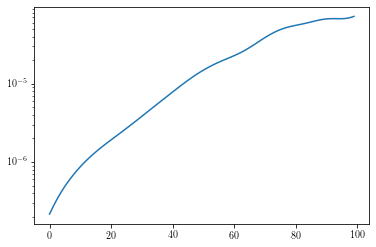

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -9.85e-07 |  0.907    |  0.1468   |  0.1847   |
|  3        | -8.896e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.78e-07 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.882e-0 |  2.011    |  0.4173   |  1.117    |
|  8        | -3.783e-0 |  2.905    |  0.3134   |  1.385    |
|  24       | -3.626e-0 |  2.372    |  0.3569   |  1.528    |
|  51       | -2.85e-07 |  2.264    |  0.2364   |  1.75     |
|  92       | -2.334e-0 |  2.378    |  0.1409   |  1.585    |
{'target': -2.333933079961376e-07, 'params': {'K': 2.377866148323864, 'a': 0.14090313560409995, 'inputscaling': 1.5845232035561652}}


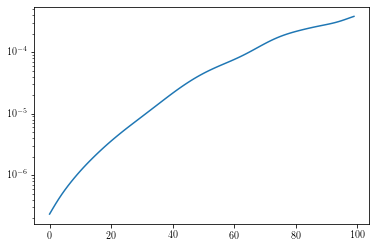

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.203e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.117e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.501e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -4.012e-0 |  2.011    |  0.4173   |  1.117    |
|  51       | -2.805e-0 |  2.264    |  0.2364   |  1.75     |
|  68       | -1.97e-07 |  2.039    |  0.1647   |  1.462    |
{'target': -1.970368444899983e-07, 'params': {'K': 2.039262383505035, 'a': 0.16471053946938974, 'inputscaling': 1.4616365309968313}}


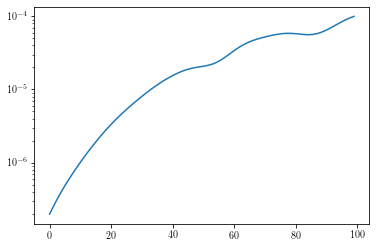

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -8.783e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -8.596e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.653e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.531e-0 |  2.011    |  0.4173   |  1.117    |
|  39       | -3.073e-0 |  2.303    |  0.3835   |  0.8708   |
|  51       | -3.07e-07 |  2.264    |  0.2364   |  1.75     |
|  59       | -2.744e-0 |  1.956    |  0.1995   |  0.853    |
|  61       | -2.611e-0 |  1.759    |  0.201    |  1.144    |
|  76       | -2.532e-0 |  2.11     |  0.1254   |  1.13     |
{'target': -2.53199809869429e-07, 'params': {'K': 2.110472437730395, 'a': 0.1253651921476267, 'inputscaling': 1.1304147172754395}}


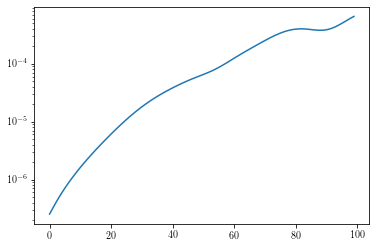

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.03e-06 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.166e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -5.095e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -4.542e-0 |  2.011    |  0.4173   |  1.117    |
|  8        | -3.714e-0 |  2.905    |  0.3134   |  1.385    |
|  51       | -2.874e-0 |  2.264    |  0.2364   |  1.75     |
|  65       | -2.475e-0 |  2.615    |  0.1786   |  0.8376   |
|  86       | -2.134e-0 |  2.476    |  0.1199   |  1.117    |
{'target': -2.1337666501275668e-07, 'params': {'K': 2.476238896841205, 'a': 0.11989189479884392, 'inputscaling': 1.1166177170910367}}


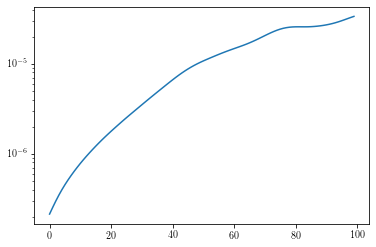

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.108e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.772e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.22e-07 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.499e-0 |  2.011    |  0.4173   |  1.117    |
|  51       | -2.816e-0 |  2.264    |  0.2364   |  1.75     |
|  70       | -2.242e-0 |  1.981    |  0.1744   |  1.492    |
{'target': -2.2420682392639947e-07, 'params': {'K': 1.980879861622888, 'a': 0.17437323243725686, 'inputscaling': 1.4922905855087572}}


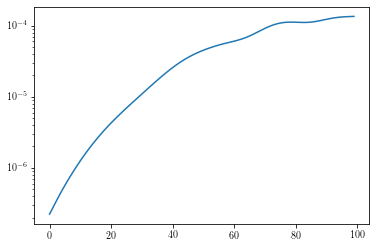

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -9.525e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -8.639e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.292e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.554e-0 |  2.011    |  0.4173   |  1.117    |
|  51       | -3.307e-0 |  2.264    |  0.2364   |  1.75     |
{'target': -3.306661853356358e-07, 'params': {'K': 2.2641085142616175, 'a': 0.23637653687262988, 'inputscaling': 1.7503810128100927}}


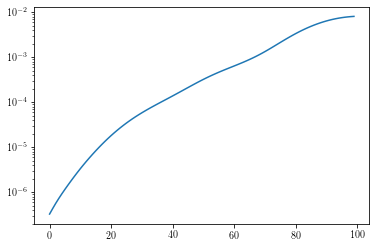

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -8.954e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -8.331e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.301e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.507e-0 |  2.011    |  0.4173   |  1.117    |
|  51       | -2.429e-0 |  2.264    |  0.2364   |  1.75     |
{'target': -2.4285781967781823e-07, 'params': {'K': 2.2641085142616175, 'a': 0.23637653687262988, 'inputscaling': 1.7503810128100927}}


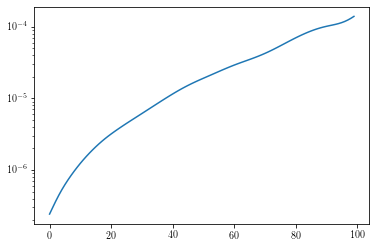

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.596e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -1.003e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.811e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -4.199e-0 |  2.011    |  0.4173   |  1.117    |
|  8        | -3.32e-07 |  2.905    |  0.3134   |  1.385    |
|  24       | -3.109e-0 |  2.851    |  0.2447   |  1.353    |
|  51       | -2.616e-0 |  2.264    |  0.2364   |  1.75     |
|  86       | -2.379e-0 |  2.476    |  0.1199   |  1.117    |
|  93       | -2.126e-0 |  2.097    |  0.08886  |  1.467    |
{'target': -2.1263565594488375e-07, 'params': {'K': 2.097287600006434, 'a': 0.08885650367015416, 'inputscaling': 1.4672777698865196}}


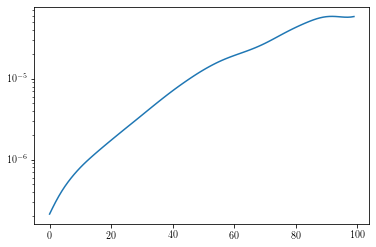

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -8.895e-0 |  0.907    |  0.1468   |  0.1847   |
|  4        | -4.293e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.383e-0 |  2.011    |  0.4173   |  1.117    |
|  51       | -2.845e-0 |  2.264    |  0.2364   |  1.75     |
|  57       | -2.837e-0 |  2.487    |  0.1415   |  1.091    |
|  58       | -2.345e-0 |  2.029    |  0.1452   |  1.457    |
{'target': -2.3454728828787879e-07, 'params': {'K': 2.0289931482349175, 'a': 0.14524985347233038, 'inputscaling': 1.4572428068442285}}


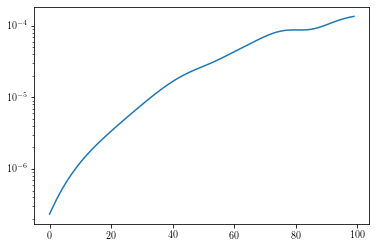

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.032e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.683e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.436e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.651e-0 |  2.011    |  0.4173   |  1.117    |
|  51       | -2.767e-0 |  2.264    |  0.2364   |  1.75     |
|  92       | -2.761e-0 |  2.378    |  0.1409   |  1.585    |
|  100      | -2.741e-0 |  2.149    |  0.2487   |  1.623    |
{'target': -2.740972880171225e-07, 'params': {'K': 2.148770803742898, 'a': 0.24870336212027272, 'inputscaling': 1.623227662209148}}


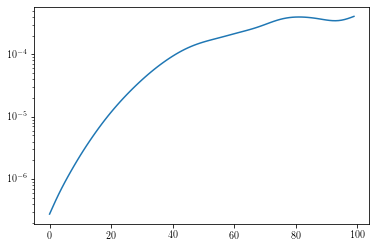

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.359e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.619e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -5.667e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -4.152e-0 |  2.011    |  0.4173   |  1.117    |
|  35       | -3.94e-07 |  2.518    |  0.4185   |  0.5922   |
|  39       | -3.179e-0 |  2.046    |  0.1797   |  0.5115   |
|  51       | -3.011e-0 |  2.264    |  0.2364   |  1.75     |
|  65       | -2.852e-0 |  2.615    |  0.1786   |  0.8376   |
|  71       | -2.707e-0 |  2.463    |  0.1667   |  1.295    |
{'target': -2.707009617234476e-07, 'params': {'K': 2.46282306199013, 'a': 0.1666617133679266, 'inputscaling': 1.2951175876991834}}


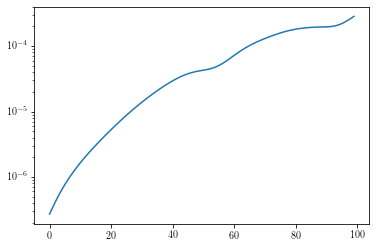

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -9.379e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -8.824e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.671e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -4.033e-0 |  2.011    |  0.4173   |  1.117    |
|  51       | -3.016e-0 |  2.264    |  0.2364   |  1.75     |
|  57       | -2.463e-0 |  1.937    |  0.1165   |  1.502    |
|  71       | -2.448e-0 |  1.218    |  0.0609   |  1.408    |
{'target': -2.447764811213818e-07, 'params': {'K': 1.2177541685195072, 'a': 0.06089954783015979, 'inputscaling': 1.407772600534613}}


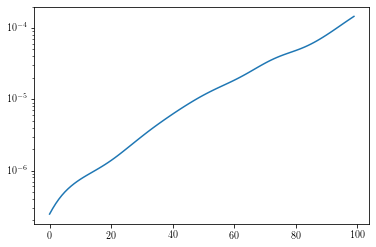

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.052e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.365e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.598e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.665e-0 |  2.011    |  0.4173   |  1.117    |
|  29       | -3.056e-0 |  1.392    |  0.1358   |  1.135    |
|  34       | -2.348e-0 |  1.795    |  0.1151   |  0.8183   |
{'target': -2.348306135114804e-07, 'params': {'K': 1.795400607644876, 'a': 0.11513131474565645, 'inputscaling': 0.8183425087935149}}


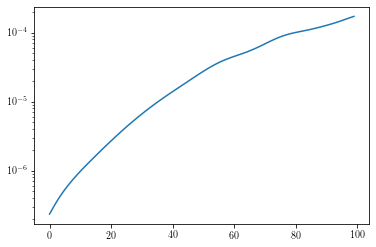

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -9.673e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -8.921e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.52e-07 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.86e-07 |  2.011    |  0.4173   |  1.117    |
|  29       | -3.796e-0 |  1.692    |  0.2577   |  0.4838   |
|  34       | -3.774e-0 |  2.544    |  0.4295   |  0.5993   |
|  35       | -3.739e-0 |  2.518    |  0.4185   |  0.5922   |
|  51       | -2.797e-0 |  2.264    |  0.2364   |  1.75     |
|  58       | -2.252e-0 |  1.994    |  0.1431   |  1.466    |
|  92       | -2.245e-0 |  2.378    |  0.1409   |  1.585    |
{'target': -2.245208544816042e-07, 'params': {'K': 2.377866148323864, 'a': 0.14090313560409995, 'inputscaling': 1.5845232035561652}}


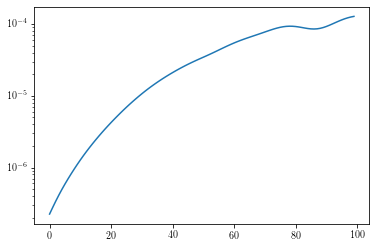

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -9.41e-07 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.196e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.634e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.704e-0 |  2.011    |  0.4173   |  1.117    |
|  34       | -2.771e-0 |  1.873    |  0.2437   |  1.332    |
|  51       | -2.621e-0 |  2.264    |  0.2364   |  1.75     |
|  56       | -1.987e-0 |  1.729    |  0.08382  |  1.047    |
{'target': -1.9865972704768845e-07, 'params': {'K': 1.7285560664752695, 'a': 0.08382019678699916, 'inputscaling': 1.0470241731622514}}


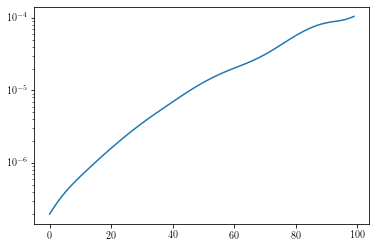

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -9.37e-07 |  0.907    |  0.1468   |  0.1847   |
|  3        | -8.89e-07 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.914e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -4.423e-0 |  2.011    |  0.4173   |  1.117    |
|  35       | -4.11e-07 |  2.518    |  0.4185   |  0.5922   |
|  51       | -3.22e-07 |  2.264    |  0.2364   |  1.75     |
|  82       | -2.866e-0 |  1.996    |  0.2195   |  1.497    |
|  92       | -2.622e-0 |  2.378    |  0.1409   |  1.585    |
{'target': -2.622332230054595e-07, 'params': {'K': 2.377866148323864, 'a': 0.14090313560409995, 'inputscaling': 1.5845232035561652}}


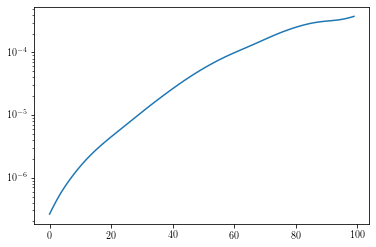

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.427e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.692e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.578e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.998e-0 |  2.011    |  0.4173   |  1.117    |
|  35       | -3.829e-0 |  2.518    |  0.4185   |  0.5922   |
|  51       | -2.863e-0 |  2.264    |  0.2364   |  1.75     |
|  79       | -2.415e-0 |  2.395    |  0.1085   |  1.232    |
{'target': -2.415124753616059e-07, 'params': {'K': 2.394599509679484, 'a': 0.10851101170224042, 'inputscaling': 1.2315478929083368}}


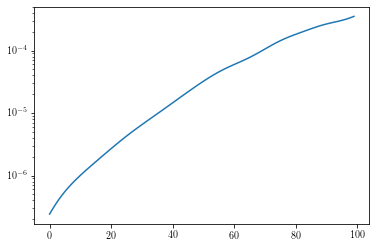

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.138e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.88e-07 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.169e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.672e-0 |  2.011    |  0.4173   |  1.117    |
|  51       | -3.045e-0 |  2.264    |  0.2364   |  1.75     |
{'target': -3.0445826960048403e-07, 'params': {'K': 2.2641085142616175, 'a': 0.23637653687262988, 'inputscaling': 1.7503810128100927}}


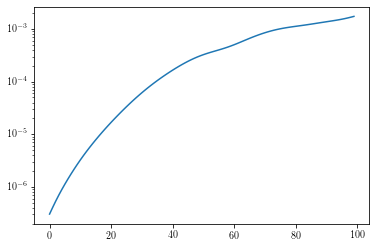

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -8.398e-0 |  0.907    |  0.1468   |  0.1847   |
|  4        | -4.593e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.606e-0 |  2.011    |  0.4173   |  1.117    |
|  35       | -3.163e-0 |  2.518    |  0.4185   |  0.5922   |
|  51       | -2.604e-0 |  2.264    |  0.2364   |  1.75     |
|  92       | -2.27e-07 |  2.378    |  0.1409   |  1.585    |
|  98       | -2.257e-0 |  2.23     |  0.1594   |  1.618    |
{'target': -2.256855255329155e-07, 'params': {'K': 2.2301307907908505, 'a': 0.15942134503489125, 'inputscaling': 1.6175180570889387}}


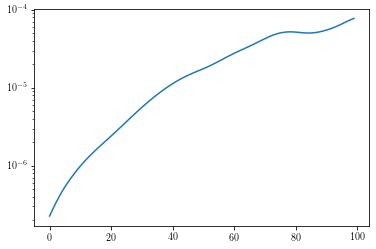

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.019e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.406e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.334e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -4.038e-0 |  2.011    |  0.4173   |  1.117    |
|  14       | -4.02e-07 |  0.6825   |  0.1556   |  1.895    |
|  29       | -3.968e-0 |  1.713    |  0.2564   |  0.4816   |
|  34       | -3.322e-0 |  2.505    |  0.4075   |  0.6426   |
|  51       | -2.493e-0 |  2.264    |  0.2364   |  1.75     |
|  68       | -2.427e-0 |  1.948    |  0.2244   |  1.53     |
{'target': -2.427427606322244e-07, 'params': {'K': 1.9479509356780123, 'a': 0.2244485896628402, 'inputscaling': 1.52993746012087}}


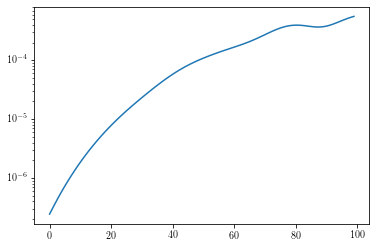

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.23e-06 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.823e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.782e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.367e-0 |  2.011    |  0.4173   |  1.117    |
|  20       | -3.025e-0 |  1.391    |  0.1906   |  1.934    |
|  51       | -3.014e-0 |  2.264    |  0.2364   |  1.75     |
{'target': -3.014387519674692e-07, 'params': {'K': 2.2641085142616175, 'a': 0.23637653687262988, 'inputscaling': 1.7503810128100927}}


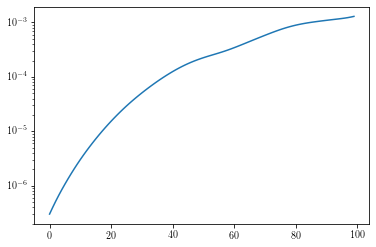

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.114e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.121e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.012e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.556e-0 |  2.011    |  0.4173   |  1.117    |
|  51       | -2.49e-07 |  2.264    |  0.2364   |  1.75     |
|  61       | -2.203e-0 |  2.034    |  0.1966   |  1.494    |
{'target': -2.2031501215802304e-07, 'params': {'K': 2.0341045019180806, 'a': 0.1966288623563016, 'inputscaling': 1.494272792640875}}


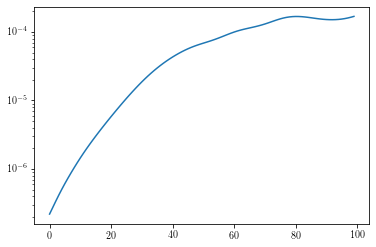

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.403e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.956e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.738e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.887e-0 |  2.011    |  0.4173   |  1.117    |
|  51       | -2.996e-0 |  2.264    |  0.2364   |  1.75     |
|  92       | -2.695e-0 |  2.378    |  0.1409   |  1.585    |
{'target': -2.694960006025744e-07, 'params': {'K': 2.377866148323864, 'a': 0.14090313560409995, 'inputscaling': 1.5845232035561652}}


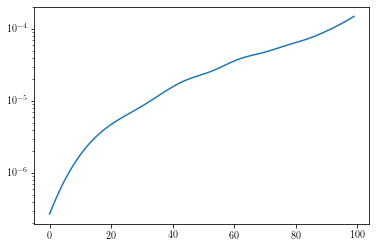

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.522e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.189e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.824e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.932e-0 |  2.011    |  0.4173   |  1.117    |
|  8        | -3.253e-0 |  2.905    |  0.3134   |  1.385    |
|  51       | -2.908e-0 |  2.264    |  0.2364   |  1.75     |
|  65       | -2.737e-0 |  2.615    |  0.1786   |  0.8376   |
|  86       | -2.705e-0 |  2.476    |  0.1199   |  1.117    |
|  91       | -2.379e-0 |  2.549    |  0.1448   |  1.422    |
{'target': -2.3791059885268738e-07, 'params': {'K': 2.5491151426825334, 'a': 0.14476994530663997, 'inputscaling': 1.4219584309790767}}


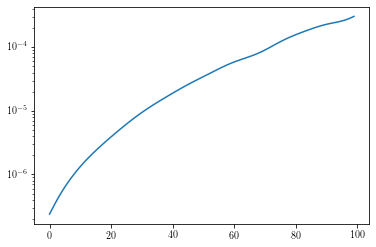

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.019e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.543e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.938e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.83e-07 |  2.011    |  0.4173   |  1.117    |
|  8        | -3.639e-0 |  2.905    |  0.3134   |  1.385    |
|  11       | -3.303e-0 |  2.302    |  0.08122  |  1.997    |
|  48       | -3.056e-0 |  1.688    |  0.1122   |  0.896    |
|  73       | -2.751e-0 |  2.45     |  0.2578   |  1.292    |
|  86       | -2.454e-0 |  2.476    |  0.1199   |  1.117    |
{'target': -2.454332611948608e-07, 'params': {'K': 2.476238896841205, 'a': 0.11989189479884392, 'inputscaling': 1.1166177170910367}}


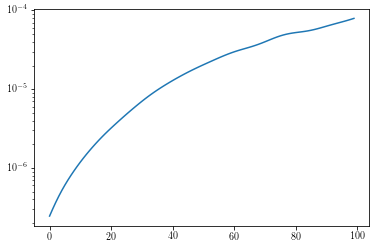

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.63e-06 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.639e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.867e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.458e-0 |  2.011    |  0.4173   |  1.117    |
|  51       | -2.7e-07  |  2.264    |  0.2364   |  1.75     |
|  87       | -2.077e-0 |  1.162    |  0.06426  |  1.987    |
{'target': -2.0772913838560626e-07, 'params': {'K': 1.1622211959677922, 'a': 0.06425675251769032, 'inputscaling': 1.986574001403666}}


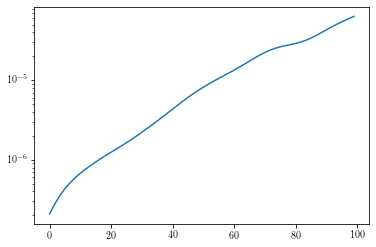

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -9.55e-07 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.029e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.245e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.296e-0 |  2.011    |  0.4173   |  1.117    |
|  47       | -2.891e-0 |  1.284    |  0.1513   |  2.0      |
|  59       | -2.377e-0 |  1.991    |  0.1866   |  1.491    |
{'target': -2.3774920577196446e-07, 'params': {'K': 1.990981160788333, 'a': 0.1866305659746891, 'inputscaling': 1.4911503035792808}}


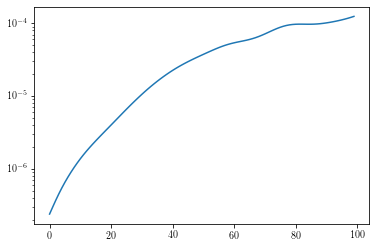

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -9.625e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -8.637e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.516e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.745e-0 |  2.011    |  0.4173   |  1.117    |
|  47       | -2.984e-0 |  1.284    |  0.152    |  2.0      |
|  51       | -2.811e-0 |  2.264    |  0.2364   |  1.75     |
|  59       | -2.537e-0 |  1.991    |  0.1868   |  1.491    |
{'target': -2.5371947173861973e-07, 'params': {'K': 1.9909465722409274, 'a': 0.18680809705014834, 'inputscaling': 1.4911567811997621}}


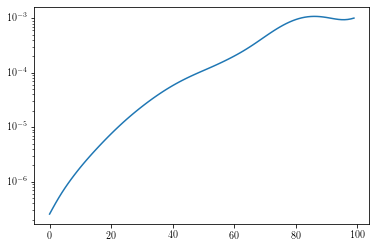

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.092e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.842e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -5.104e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -4.504e-0 |  2.011    |  0.4173   |  1.117    |
|  8        | -3.251e-0 |  2.905    |  0.3134   |  1.385    |
|  51       | -3.093e-0 |  2.264    |  0.2364   |  1.75     |
|  86       | -3.077e-0 |  2.476    |  0.1199   |  1.117    |
|  92       | -2.604e-0 |  2.378    |  0.1409   |  1.585    |
{'target': -2.604310694853112e-07, 'params': {'K': 2.377866148323864, 'a': 0.14090313560409995, 'inputscaling': 1.5845232035561652}}


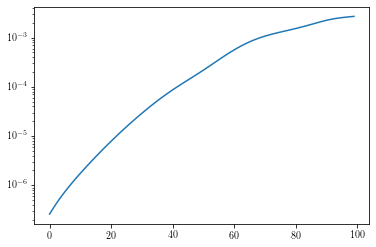

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.066e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.53e-07 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -5.016e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.613e-0 |  2.011    |  0.4173   |  1.117    |
|  51       | -3.132e-0 |  2.264    |  0.2364   |  1.75     |
|  57       | -2.51e-07 |  2.036    |  0.1408   |  1.46     |
{'target': -2.509936909093939e-07, 'params': {'K': 2.035823300163872, 'a': 0.14080787928710925, 'inputscaling': 1.4597171506534754}}


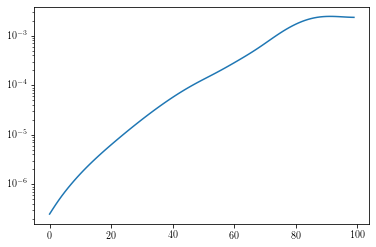

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.019e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.445e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.922e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.873e-0 |  2.011    |  0.4173   |  1.117    |
|  51       | -2.905e-0 |  2.264    |  0.2364   |  1.75     |
|  67       | -2.895e-0 |  2.462    |  0.2091   |  1.236    |
|  86       | -2.853e-0 |  2.476    |  0.1199   |  1.117    |
|  92       | -2.426e-0 |  2.378    |  0.1409   |  1.585    |
{'target': -2.426431814297074e-07, 'params': {'K': 2.377866148323864, 'a': 0.14090313560409995, 'inputscaling': 1.5845232035561652}}


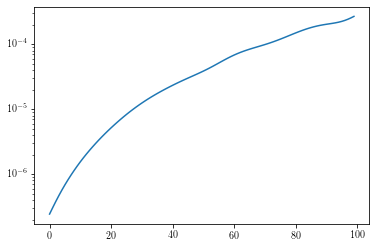

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.124e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.645e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.821e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -4.25e-07 |  2.011    |  0.4173   |  1.117    |
|  8        | -3.71e-07 |  2.905    |  0.3134   |  1.385    |
|  11       | -3.514e-0 |  2.382    |  0.3318   |  1.497    |
|  40       | -2.339e-0 |  1.95     |  0.1175   |  1.993    |
{'target': -2.3388832944136114e-07, 'params': {'K': 1.9503706754756946, 'a': 0.11752456642716984, 'inputscaling': 1.9933063331415344}}


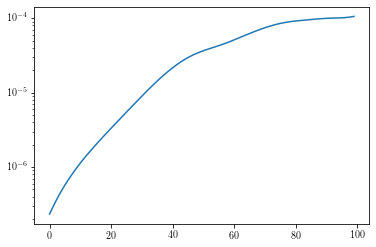

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.055e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.547e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.245e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.864e-0 |  2.011    |  0.4173   |  1.117    |
|  8        | -3.484e-0 |  2.905    |  0.3134   |  1.385    |
|  35       | -3.478e-0 |  2.518    |  0.4185   |  0.5922   |
|  51       | -2.327e-0 |  2.264    |  0.2364   |  1.75     |
{'target': -2.3271050115668915e-07, 'params': {'K': 2.2641085142616175, 'a': 0.23637653687262988, 'inputscaling': 1.7503810128100927}}


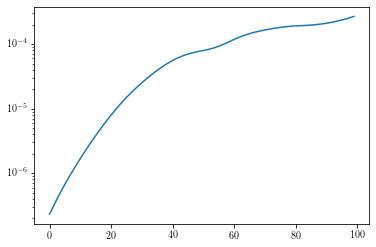

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -9.564e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.135e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.664e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.812e-0 |  2.011    |  0.4173   |  1.117    |
|  51       | -3.156e-0 |  2.264    |  0.2364   |  1.75     |
|  68       | -2.757e-0 |  1.939    |  0.227    |  1.538    |
{'target': -2.7572083363609224e-07, 'params': {'K': 1.9392542256778542, 'a': 0.22697434334560976, 'inputscaling': 1.5378594901347507}}


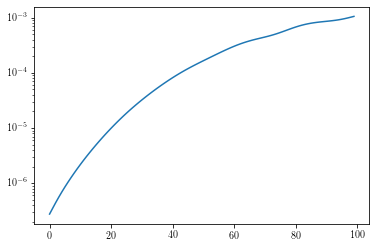

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -9.105e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -8.45e-07 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -3.961e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.799e-0 |  2.011    |  0.4173   |  1.117    |
|  12       | -3.752e-0 |  2.301    |  0.3433   |  1.635    |
|  16       | -2.831e-0 |  2.647    |  0.2533   |  0.6669   |
{'target': -2.8314092395795085e-07, 'params': {'K': 2.6470198546507535, 'a': 0.25331996180263144, 'inputscaling': 0.6669463604857548}}


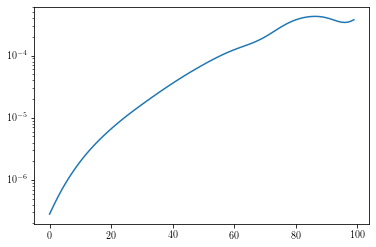

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -9.997e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.125e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.714e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -4.326e-0 |  2.011    |  0.4173   |  1.117    |
|  14       | -4.121e-0 |  0.6825   |  0.1556   |  1.895    |
|  29       | -3.943e-0 |  1.704    |  0.257    |  0.4827   |
|  51       | -3.008e-0 |  2.264    |  0.2364   |  1.75     |
|  79       | -2.899e-0 |  2.411    |  0.1438   |  1.237    |
|  92       | -2.7e-07  |  2.378    |  0.1409   |  1.585    |
{'target': -2.7004037703876737e-07, 'params': {'K': 2.377866148323864, 'a': 0.14090313560409995, 'inputscaling': 1.5845232035561652}}


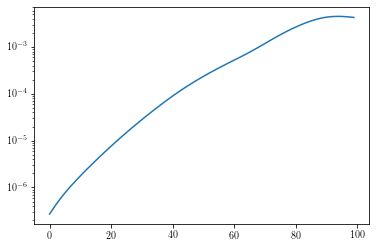

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.213e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.423e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.692e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -4.365e-0 |  2.011    |  0.4173   |  1.117    |
|  13       | -2.182e-0 |  2.402    |  0.1243   |  1.357    |
{'target': -2.1822996525442352e-07, 'params': {'K': 2.4017518736976013, 'a': 0.12429264819998206, 'inputscaling': 1.3570701687130242}}


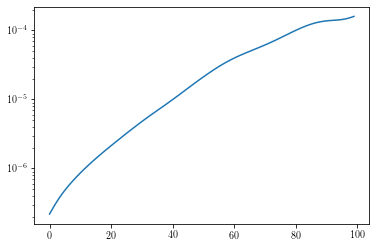

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.012e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -8.94e-07 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -5.502e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -4.015e-0 |  2.011    |  0.4173   |  1.117    |
|  8        | -3.979e-0 |  2.905    |  0.3134   |  1.385    |
|  51       | -2.768e-0 |  2.264    |  0.2364   |  1.75     |
|  92       | -2.29e-07 |  2.378    |  0.1409   |  1.585    |
{'target': -2.2898218450959682e-07, 'params': {'K': 2.377866148323864, 'a': 0.14090313560409995, 'inputscaling': 1.5845232035561652}}


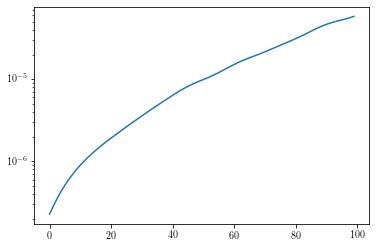

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.577e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.962e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.655e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -4.171e-0 |  2.011    |  0.4173   |  1.117    |
|  8        | -4.03e-07 |  2.905    |  0.3134   |  1.385    |
|  11       | -3.927e-0 |  2.378    |  0.4008   |  1.436    |
|  20       | -3.028e-0 |  2.539    |  0.2607   |  0.9739   |
|  51       | -2.922e-0 |  2.264    |  0.2364   |  1.75     |
{'target': -2.922019560315428e-07, 'params': {'K': 2.2641085142616175, 'a': 0.23637653687262988, 'inputscaling': 1.7503810128100927}}


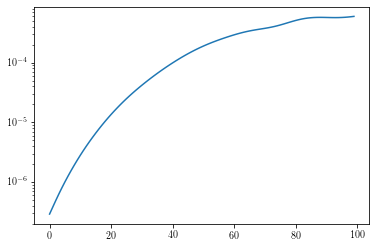

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.604e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.764e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -5.143e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.66e-07 |  2.011    |  0.4173   |  1.117    |
|  11       | -3.455e-0 |  2.378    |  0.4008   |  1.436    |
|  31       | -3.059e-0 |  1.548    |  0.1639   |  2.0      |
|  51       | -2.772e-0 |  2.264    |  0.2364   |  1.75     |
{'target': -2.772491961654016e-07, 'params': {'K': 2.2641085142616175, 'a': 0.23637653687262988, 'inputscaling': 1.7503810128100927}}


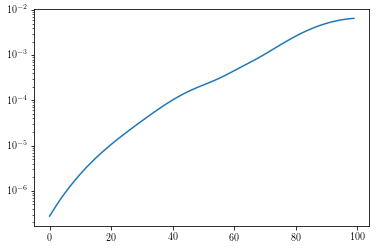

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.056e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.918e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.649e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -4.045e-0 |  2.011    |  0.4173   |  1.117    |
|  8        | -3.399e-0 |  2.905    |  0.3134   |  1.385    |
|  39       | -2.346e-0 |  1.437    |  0.1012   |  1.97     |
{'target': -2.3461374459674806e-07, 'params': {'K': 1.4372094531902797, 'a': 0.10115702791113093, 'inputscaling': 1.9701994385501864}}


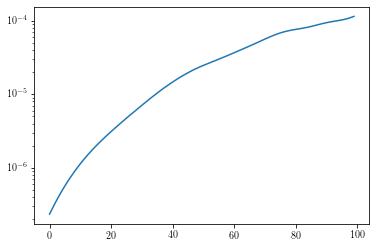

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.024e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.445e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.251e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.219e-0 |  2.011    |  0.4173   |  1.117    |
|  8        | -3.166e-0 |  2.905    |  0.3134   |  1.385    |
|  51       | -2.551e-0 |  2.264    |  0.2364   |  1.75     |
|  86       | -2.398e-0 |  2.476    |  0.1199   |  1.117    |
|  92       | -1.604e-0 |  2.378    |  0.1409   |  1.585    |
{'target': -1.604489183867745e-07, 'params': {'K': 2.377866148323864, 'a': 0.14090313560409995, 'inputscaling': 1.5845232035561652}}


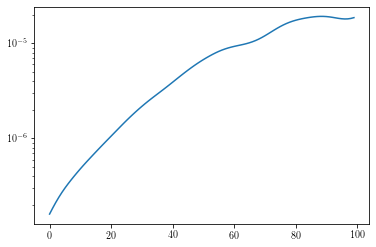

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -9.382e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.261e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.438e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -4.341e-0 |  2.011    |  0.4173   |  1.117    |
|  8        | -3.38e-07 |  2.905    |  0.3134   |  1.385    |
|  51       | -3.046e-0 |  2.264    |  0.2364   |  1.75     |
|  92       | -2.614e-0 |  2.378    |  0.1409   |  1.585    |
{'target': -2.613973862952621e-07, 'params': {'K': 2.377866148323864, 'a': 0.14090313560409995, 'inputscaling': 1.5845232035561652}}


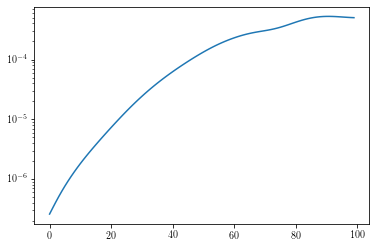

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.008e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.812e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.537e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.672e-0 |  2.011    |  0.4173   |  1.117    |
|  8        | -3.073e-0 |  2.905    |  0.3134   |  1.385    |
|  51       | -2.833e-0 |  2.264    |  0.2364   |  1.75     |
|  65       | -2.732e-0 |  2.615    |  0.1786   |  0.8376   |
|  86       | -2.418e-0 |  2.476    |  0.1199   |  1.117    |
|  92       | -2.326e-0 |  2.378    |  0.1409   |  1.585    |
{'target': -2.3255262825840392e-07, 'params': {'K': 2.377866148323864, 'a': 0.14090313560409995, 'inputscaling': 1.5845232035561652}}


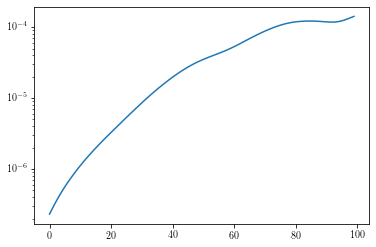

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.717e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.594e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.449e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.662e-0 |  2.011    |  0.4173   |  1.117    |
|  12       | -2.421e-0 |  2.245    |  0.1602   |  1.708    |
|  16       | -2.184e-0 |  1.911    |  0.08864  |  1.406    |
{'target': -2.183568367479985e-07, 'params': {'K': 1.9114461139142676, 'a': 0.08863920596151524, 'inputscaling': 1.4063039477815016}}


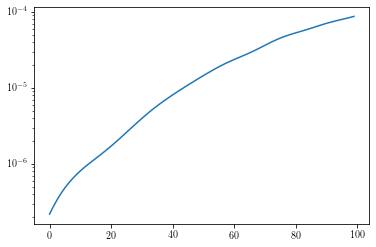

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.528e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -1.002e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.569e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.688e-0 |  2.011    |  0.4173   |  1.117    |
|  8        | -3.632e-0 |  2.905    |  0.3134   |  1.385    |
|  31       | -3.268e-0 |  2.106    |  0.09789  |  1.984    |
|  55       | -3.095e-0 |  1.591    |  0.2297   |  1.996    |
|  65       | -3.037e-0 |  2.615    |  0.1786   |  0.8376   |
|  86       | -1.598e-0 |  2.476    |  0.1199   |  1.117    |
{'target': -1.5979142044262834e-07, 'params': {'K': 2.476238896841205, 'a': 0.11989189479884392, 'inputscaling': 1.1166177170910367}}


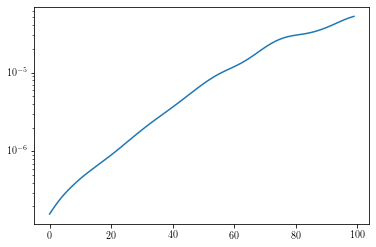

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -8.003e-0 |  0.907    |  0.1468   |  0.1847   |
|  4        | -4.318e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.837e-0 |  2.011    |  0.4173   |  1.117    |
|  46       | -2.741e-0 |  1.905    |  0.2396   |  0.8069   |
|  49       | -2.551e-0 |  1.796    |  0.2378   |  1.181    |
{'target': -2.5507866571118936e-07, 'params': {'K': 1.7955364284864133, 'a': 0.23777174894246655, 'inputscaling': 1.1807689299863242}}


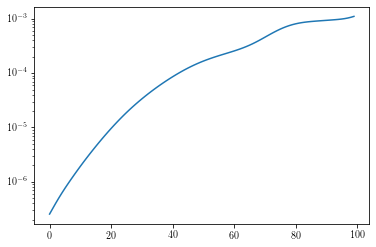

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.587e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.383e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -5.247e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -4.126e-0 |  2.011    |  0.4173   |  1.117    |
|  8        | -3.457e-0 |  2.905    |  0.3134   |  1.385    |
|  31       | -3.294e-0 |  2.412    |  0.318    |  1.213    |
|  34       | -2.73e-07 |  1.795    |  0.1151   |  0.8183   |
|  86       | -2.414e-0 |  2.476    |  0.1199   |  1.117    |
|  92       | -2.357e-0 |  2.378    |  0.1409   |  1.585    |
{'target': -2.3568706653136546e-07, 'params': {'K': 2.377866148323864, 'a': 0.14090313560409995, 'inputscaling': 1.5845232035561652}}


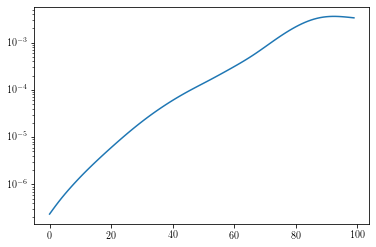

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -7.693e-0 |  0.907    |  0.1468   |  0.1847   |
|  4        | -4.075e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.543e-0 |  2.011    |  0.4173   |  1.117    |
|  51       | -2.775e-0 |  2.264    |  0.2364   |  1.75     |
|  74       | -2.608e-0 |  1.963    |  0.2469   |  1.524    |
{'target': -2.6080908198473585e-07, 'params': {'K': 1.962820320538515, 'a': 0.24685531047926973, 'inputscaling': 1.5236792068512939}}


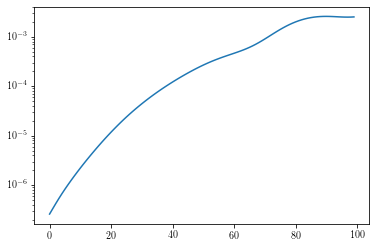

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -9.436e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.32e-07 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -5.083e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.984e-0 |  2.011    |  0.4173   |  1.117    |
|  8        | -3.851e-0 |  2.905    |  0.3134   |  1.385    |
|  47       | -3.102e-0 |  1.284    |  0.1513   |  2.0      |
|  51       | -2.766e-0 |  2.264    |  0.2364   |  1.75     |
|  59       | -2.554e-0 |  1.991    |  0.1866   |  1.491    |
|  67       | -2.54e-07 |  2.44     |  0.1474   |  1.249    |
{'target': -2.5404328703417913e-07, 'params': {'K': 2.440244545324326, 'a': 0.14744166384975274, 'inputscaling': 1.248637018295602}}


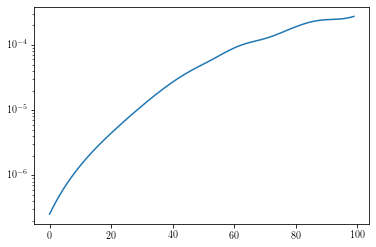

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.057e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.877e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.926e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.926e-0 |  2.011    |  0.4173   |  1.117    |
|  11       | -3.257e-0 |  2.378    |  0.4008   |  1.436    |
|  29       | -3.249e-0 |  1.392    |  0.1358   |  1.135    |
|  31       | -2.758e-0 |  2.412    |  0.318    |  1.213    |
|  92       | -2.075e-0 |  2.378    |  0.1409   |  1.585    |
{'target': -2.0750501323955092e-07, 'params': {'K': 2.377866148323864, 'a': 0.14090313560409995, 'inputscaling': 1.5845232035561652}}


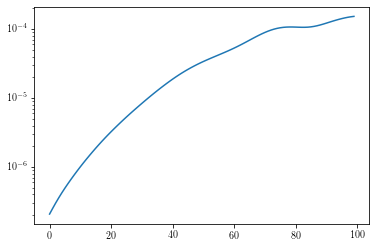

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -9.229e-0 |  0.907    |  0.1468   |  0.1847   |
|  4        | -4.363e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.631e-0 |  2.011    |  0.4173   |  1.117    |
|  51       | -2.914e-0 |  2.264    |  0.2364   |  1.75     |
|  92       | -2.587e-0 |  2.378    |  0.1409   |  1.585    |
{'target': -2.587345965512463e-07, 'params': {'K': 2.377866148323864, 'a': 0.14090313560409995, 'inputscaling': 1.5845232035561652}}


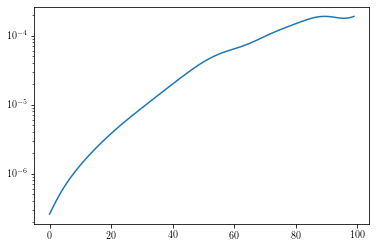

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -8.641e-0 |  0.907    |  0.1468   |  0.1847   |
|  4        | -4.112e-0 |  1.616    |  0.4192   |  1.37     |
|  33       | -4.108e-0 |  1.698    |  0.427    |  1.101    |
|  35       | -4.082e-0 |  2.518    |  0.4185   |  0.5922   |
|  40       | -3.82e-07 |  2.192    |  0.3688   |  0.5811   |
|  48       | -3.398e-0 |  1.911    |  0.2717   |  0.8597   |
|  51       | -2.841e-0 |  2.264    |  0.2364   |  1.75     |
|  63       | -2.352e-0 |  1.815    |  0.2094   |  1.3      |
{'target': -2.3515056564718537e-07, 'params': {'K': 1.8146182766555083, 'a': 0.20937319490804943, 'inputscaling': 1.3001269827918216}}


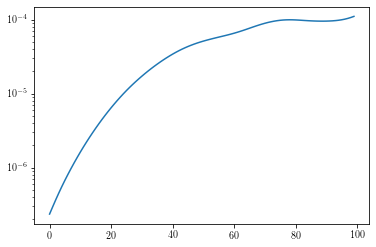

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.264e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.494e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.369e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.857e-0 |  2.011    |  0.4173   |  1.117    |
|  51       | -2.802e-0 |  2.264    |  0.2364   |  1.75     |
|  92       | -2.369e-0 |  2.378    |  0.1409   |  1.585    |
{'target': -2.369090950421247e-07, 'params': {'K': 2.377866148323864, 'a': 0.14090313560409995, 'inputscaling': 1.5845232035561652}}


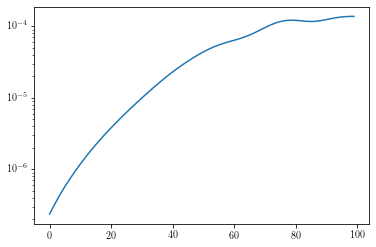

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -8.739e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -8.71e-07 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.223e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.666e-0 |  2.011    |  0.4173   |  1.117    |
|  12       | -3.494e-0 |  2.249    |  0.3343   |  1.629    |
|  43       | -2.104e-0 |  1.692    |  0.1355   |  1.998    |
{'target': -2.1039509410446587e-07, 'params': {'K': 1.6920546213061403, 'a': 0.1354620192653422, 'inputscaling': 1.9984975802706235}}


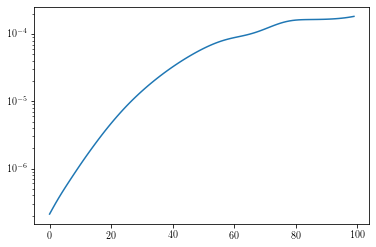

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.416e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.751e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -5.091e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -4.075e-0 |  2.011    |  0.4173   |  1.117    |
|  8        | -3.987e-0 |  2.905    |  0.3134   |  1.385    |
|  11       | -3.89e-07 |  2.44     |  0.4199   |  1.363    |
|  28       | -3.74e-07 |  2.469    |  0.3978   |  1.391    |
|  35       | -2.678e-0 |  2.518    |  0.4185   |  0.5922   |
|  92       | -2.253e-0 |  2.378    |  0.1409   |  1.585    |
{'target': -2.2533824368850352e-07, 'params': {'K': 2.377866148323864, 'a': 0.14090313560409995, 'inputscaling': 1.5845232035561652}}


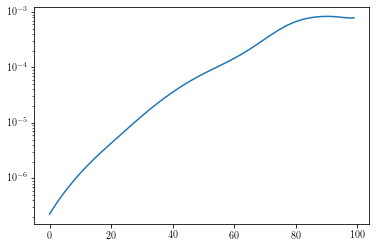

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -9.122e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -8.551e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.509e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.932e-0 |  2.011    |  0.4173   |  1.117    |
|  16       | -2.961e-0 |  2.486    |  0.1273   |  1.013    |
|  31       | -2.046e-0 |  1.858    |  0.07622  |  2.0      |
{'target': -2.046186437973811e-07, 'params': {'K': 1.8577262349309522, 'a': 0.07622334614025257, 'inputscaling': 2.0}}


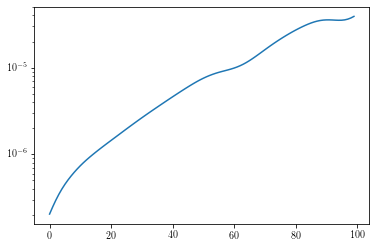

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -9.694e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.651e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.596e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.984e-0 |  2.011    |  0.4173   |  1.117    |
|  8        | -3.772e-0 |  2.905    |  0.3134   |  1.385    |
|  51       | -2.788e-0 |  2.264    |  0.2364   |  1.75     |
|  84       | -2.75e-07 |  2.345    |  0.2344   |  0.8851   |
|  86       | -2.7e-07  |  2.476    |  0.1199   |  1.117    |
|  92       | -2.305e-0 |  2.378    |  0.1409   |  1.585    |
{'target': -2.3046955146006058e-07, 'params': {'K': 2.377866148323864, 'a': 0.14090313560409995, 'inputscaling': 1.5845232035561652}}


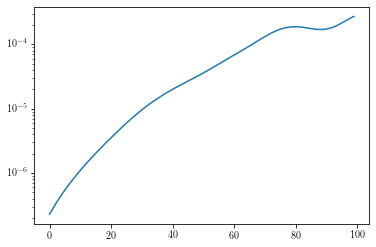

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -7.971e-0 |  0.907    |  0.1468   |  0.1847   |
|  4        | -4.364e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.448e-0 |  2.011    |  0.4173   |  1.117    |
|  51       | -3.01e-07 |  2.264    |  0.2364   |  1.75     |
|  92       | -2.813e-0 |  2.378    |  0.1409   |  1.585    |
|  104      | -2.192e-0 |  1.729    |  0.08118  |  1.988    |
{'target': -2.1919886504763003e-07, 'params': {'K': 1.729014187684368, 'a': 0.08117932697393465, 'inputscaling': 1.9882309715503097}}


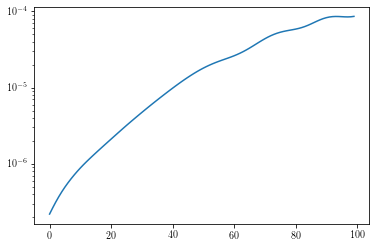

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.199e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.823e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.728e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.983e-0 |  2.011    |  0.4173   |  1.117    |
|  51       | -2.48e-07 |  2.264    |  0.2364   |  1.75     |
|  92       | -2.159e-0 |  2.378    |  0.1409   |  1.585    |
{'target': -2.159031933884375e-07, 'params': {'K': 2.377866148323864, 'a': 0.14090313560409995, 'inputscaling': 1.5845232035561652}}


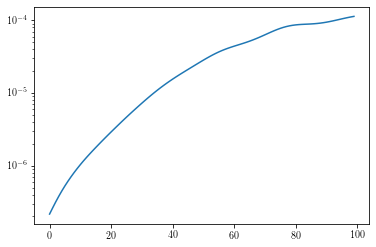

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.176e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.452e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.135e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -2.937e-0 |  2.011    |  0.4173   |  1.117    |
|  51       | -2.75e-07 |  2.264    |  0.2364   |  1.75     |
|  92       | -2.734e-0 |  2.378    |  0.1409   |  1.585    |
{'target': -2.734378300750936e-07, 'params': {'K': 2.377866148323864, 'a': 0.14090313560409995, 'inputscaling': 1.5845232035561652}}


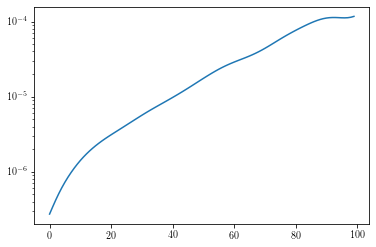

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.587e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.466e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.977e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.728e-0 |  2.011    |  0.4173   |  1.117    |
|  28       | -3.668e-0 |  2.469    |  0.3978   |  1.391    |
|  36       | -2.95e-07 |  1.491    |  0.1223   |  2.0      |
|  51       | -2.765e-0 |  2.264    |  0.2364   |  1.75     |
|  78       | -2.764e-0 |  1.943    |  0.04752  |  1.974    |
|  86       | -2.595e-0 |  2.476    |  0.1199   |  1.117    |
|  92       | -1.894e-0 |  2.378    |  0.1409   |  1.585    |
{'target': -1.894013256455021e-07, 'params': {'K': 2.377866148323864, 'a': 0.14090313560409995, 'inputscaling': 1.5845232035561652}}


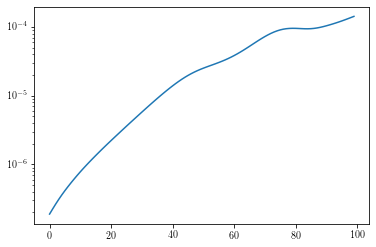

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -8.799e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -8.628e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.168e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.461e-0 |  2.011    |  0.4173   |  1.117    |
|  12       | -3.431e-0 |  2.249    |  0.3343   |  1.629    |
|  40       | -2.602e-0 |  1.324    |  0.1394   |  1.847    |
{'target': -2.6023175420875805e-07, 'params': {'K': 1.3243644924836209, 'a': 0.13937039014694125, 'inputscaling': 1.8474699900383473}}


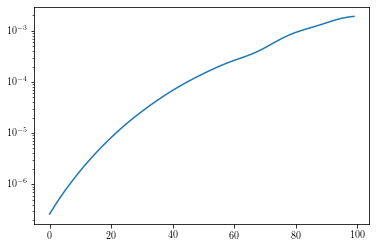

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.28e-06 |  0.907    |  0.1468   |  0.1847   |
|  3        | -8.949e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.335e-0 |  1.616    |  0.4192   |  1.37     |
|  29       | -2.977e-0 |  1.392    |  0.1358   |  1.135    |
|  92       | -2.369e-0 |  2.378    |  0.1409   |  1.585    |
{'target': -2.3692656366604103e-07, 'params': {'K': 2.377866148323864, 'a': 0.14090313560409995, 'inputscaling': 1.5845232035561652}}


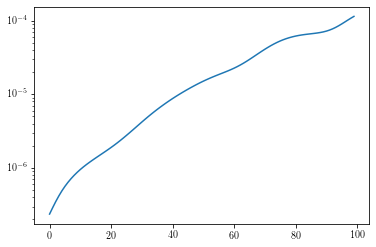

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.172e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.084e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.865e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -4.456e-0 |  2.011    |  0.4173   |  1.117    |
|  51       | -2.987e-0 |  2.264    |  0.2364   |  1.75     |
|  91       | -2.523e-0 |  1.542    |  0.0575   |  1.759    |
{'target': -2.52296348997131e-07, 'params': {'K': 1.5418294565332595, 'a': 0.05750249564768706, 'inputscaling': 1.758606495527}}


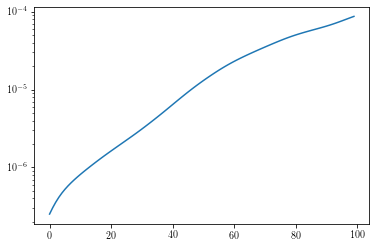

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -9.135e-0 |  0.907    |  0.1468   |  0.1847   |
|  4        | -5.03e-07 |  1.616    |  0.4192   |  1.37     |
|  6        | -4.218e-0 |  2.011    |  0.4173   |  1.117    |
|  29       | -4.141e-0 |  1.737    |  0.2546   |  0.4775   |
|  35       | -3.755e-0 |  2.518    |  0.4185   |  0.5922   |
|  41       | -3.348e-0 |  2.095    |  0.3314   |  0.4386   |
|  51       | -2.906e-0 |  2.264    |  0.2364   |  1.75     |
|  70       | -2.709e-0 |  2.479    |  0.1795   |  1.287    |
|  92       | -2.573e-0 |  2.378    |  0.1409   |  1.585    |
{'target': -2.573299662481301e-07, 'params': {'K': 2.377866148323864, 'a': 0.14090313560409995, 'inputscaling': 1.5845232035561652}}


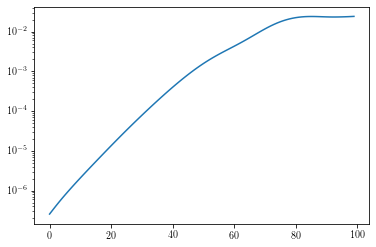

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -8.712e-0 |  0.907    |  0.1468   |  0.1847   |
|  4        | -4.713e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -4.213e-0 |  2.011    |  0.4173   |  1.117    |
|  27       | -3.857e-0 |  1.771    |  0.2365   |  0.4454   |
|  51       | -3.037e-0 |  2.264    |  0.2364   |  1.75     |
|  92       | -3.022e-0 |  2.378    |  0.1409   |  1.585    |
|  99       | -2.842e-0 |  2.177    |  0.2268   |  1.621    |
{'target': -2.8424555322738465e-07, 'params': {'K': 2.1769854645422497, 'a': 0.2267639823093495, 'inputscaling': 1.6205877079756372}}


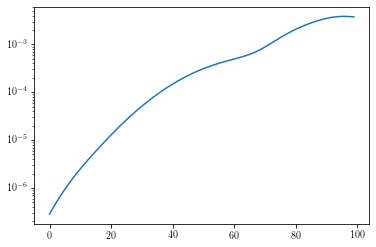

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.033e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -8.614e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.036e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.573e-0 |  2.011    |  0.4173   |  1.117    |
|  29       | -3.309e-0 |  1.703    |  0.2571   |  0.4827   |
|  51       | -2.959e-0 |  2.264    |  0.2364   |  1.75     |
|  92       | -2.612e-0 |  2.378    |  0.1409   |  1.585    |
{'target': -2.6118134464654154e-07, 'params': {'K': 2.377866148323864, 'a': 0.14090313560409995, 'inputscaling': 1.5845232035561652}}


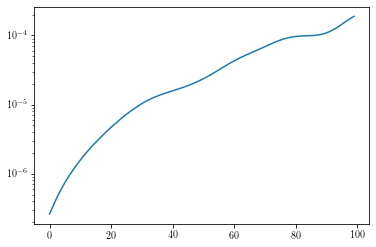

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.159e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.16e-07 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.213e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.5e-07  |  2.011    |  0.4173   |  1.117    |
|  29       | -3.087e-0 |  1.392    |  0.1358   |  1.135    |
|  34       | -2.802e-0 |  1.795    |  0.1151   |  0.8183   |
|  51       | -2.4e-07  |  2.264    |  0.2364   |  1.75     |
{'target': -2.3995437664562007e-07, 'params': {'K': 2.2641085142616175, 'a': 0.23637653687262988, 'inputscaling': 1.7503810128100927}}


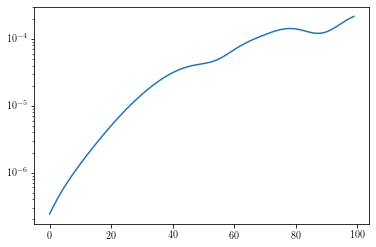

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.292e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.765e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.19e-07 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.662e-0 |  2.011    |  0.4173   |  1.117    |
|  51       | -2.935e-0 |  2.264    |  0.2364   |  1.75     |
|  92       | -2.619e-0 |  2.378    |  0.1409   |  1.585    |
{'target': -2.6194361297635985e-07, 'params': {'K': 2.377866148323864, 'a': 0.14090313560409995, 'inputscaling': 1.5845232035561652}}


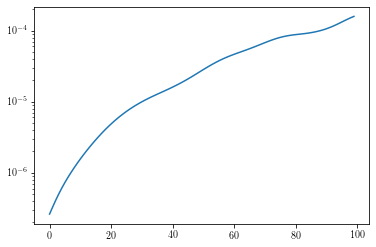

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.157e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.324e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.823e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.619e-0 |  2.011    |  0.4173   |  1.117    |
|  51       | -2.689e-0 |  2.264    |  0.2364   |  1.75     |
|  82       | -2.688e-0 |  1.991    |  0.214    |  1.502    |
|  92       | -2.653e-0 |  2.378    |  0.1409   |  1.585    |
{'target': -2.652540103232153e-07, 'params': {'K': 2.377866148323864, 'a': 0.14090313560409995, 'inputscaling': 1.5845232035561652}}


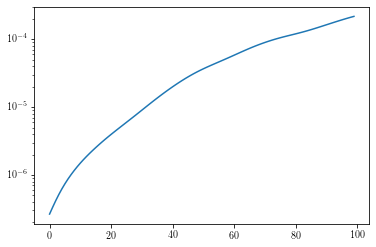

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.167e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.896e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -5.087e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.703e-0 |  2.011    |  0.4173   |  1.117    |
|  51       | -2.868e-0 |  2.264    |  0.2364   |  1.75     |
|  92       | -2.595e-0 |  2.378    |  0.1409   |  1.585    |
{'target': -2.5947686486660327e-07, 'params': {'K': 2.377866148323864, 'a': 0.14090313560409995, 'inputscaling': 1.5845232035561652}}


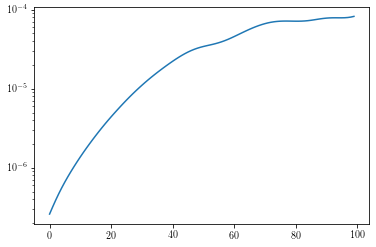

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.042e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.618e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.838e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.654e-0 |  2.011    |  0.4173   |  1.117    |
|  31       | -2.466e-0 |  1.851    |  0.08442  |  2.0      |
{'target': -2.465776195572496e-07, 'params': {'K': 1.8514646212654777, 'a': 0.08441961549468757, 'inputscaling': 2.0}}


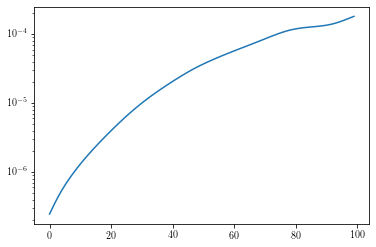

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -9.504e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.437e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.736e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -4.165e-0 |  2.011    |  0.4173   |  1.117    |
|  12       | -3.866e-0 |  2.301    |  0.3433   |  1.635    |
|  37       | -3.423e-0 |  2.493    |  0.3024   |  1.162    |
|  51       | -3.037e-0 |  2.264    |  0.2364   |  1.75     |
|  86       | -2.852e-0 |  2.476    |  0.1199   |  1.117    |
|  89       | -1.729e-0 |  1.935    |  0.112    |  1.499    |
{'target': -1.7289571724391928e-07, 'params': {'K': 1.9352064705079493, 'a': 0.11200134598772091, 'inputscaling': 1.4986253753562624}}


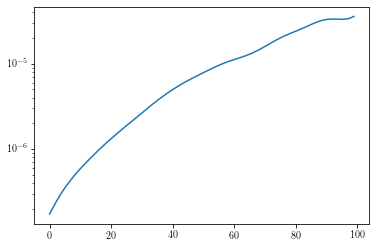

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.169e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.64e-07 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.445e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.666e-0 |  2.011    |  0.4173   |  1.117    |
|  11       | -3.394e-0 |  2.378    |  0.4008   |  1.436    |
|  31       | -3.256e-0 |  2.106    |  0.09789  |  1.984    |
|  51       | -3.154e-0 |  2.264    |  0.2364   |  1.75     |
|  86       | -2.968e-0 |  2.476    |  0.1199   |  1.117    |
|  92       | -2.857e-0 |  2.378    |  0.1409   |  1.585    |
{'target': -2.8566696083695503e-07, 'params': {'K': 2.377866148323864, 'a': 0.14090313560409995, 'inputscaling': 1.5845232035561652}}


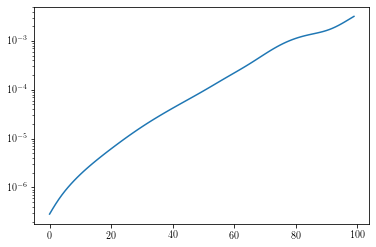

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.659e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -1.021e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -5.187e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -4.477e-0 |  2.011    |  0.4173   |  1.117    |
|  8        | -3.584e-0 |  2.905    |  0.3134   |  1.385    |
|  51       | -2.954e-0 |  2.264    |  0.2364   |  1.75     |
|  70       | -2.82e-07 |  2.465    |  0.1732   |  1.293    |
|  86       | -2.187e-0 |  2.476    |  0.1199   |  1.117    |
{'target': -2.1867439612513485e-07, 'params': {'K': 2.476238896841205, 'a': 0.11989189479884392, 'inputscaling': 1.1166177170910367}}


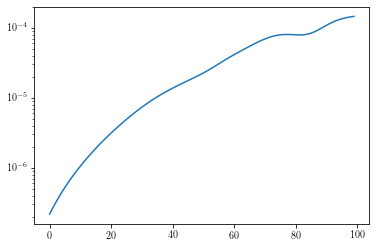

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.17e-06 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.175e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.918e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.853e-0 |  2.011    |  0.4173   |  1.117    |
|  29       | -2.951e-0 |  1.392    |  0.1358   |  1.135    |
|  34       | -2.453e-0 |  1.795    |  0.1151   |  0.8183   |
|  92       | -2.003e-0 |  2.378    |  0.1409   |  1.585    |
{'target': -2.002651333552215e-07, 'params': {'K': 2.377866148323864, 'a': 0.14090313560409995, 'inputscaling': 1.5845232035561652}}


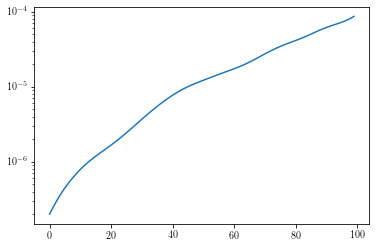

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -8.96e-07 |  0.907    |  0.1468   |  0.1847   |
|  4        | -4.769e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -4.048e-0 |  2.011    |  0.4173   |  1.117    |
|  12       | -3.623e-0 |  2.301    |  0.3433   |  1.635    |
|  16       | -3.378e-0 |  2.647    |  0.2533   |  0.6669   |
|  28       | -3.269e-0 |  2.69     |  0.2471   |  0.6505   |
|  51       | -3.064e-0 |  2.264    |  0.2364   |  1.75     |
|  79       | -2.907e-0 |  1.932    |  0.1922   |  1.517    |
|  86       | -2.689e-0 |  2.476    |  0.1199   |  1.117    |
{'target': -2.6891870464403876e-07, 'params': {'K': 2.476238896841205, 'a': 0.11989189479884392, 'inputscaling': 1.1166177170910367}}


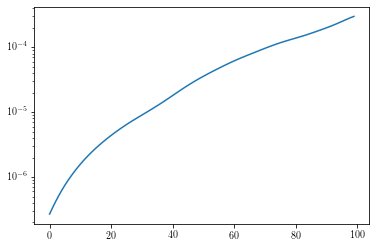

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.417e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.629e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -5.006e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.857e-0 |  2.011    |  0.4173   |  1.117    |
|  28       | -3.774e-0 |  2.469    |  0.3978   |  1.391    |
|  51       | -3.132e-0 |  2.264    |  0.2364   |  1.75     |
|  92       | -2.179e-0 |  2.378    |  0.1409   |  1.585    |
{'target': -2.1788636207326177e-07, 'params': {'K': 2.377866148323864, 'a': 0.14090313560409995, 'inputscaling': 1.5845232035561652}}


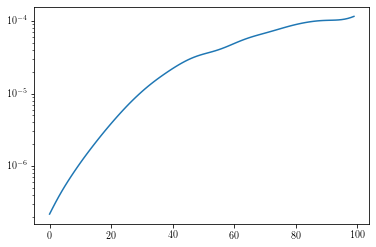

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -8.732e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -8.686e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.264e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.812e-0 |  2.011    |  0.4173   |  1.117    |
|  14       | -3.763e-0 |  0.6825   |  0.1556   |  1.895    |
|  29       | -2.547e-0 |  1.392    |  0.1358   |  1.135    |
|  34       | -2.545e-0 |  1.795    |  0.1151   |  0.8183   |
{'target': -2.5452014679089275e-07, 'params': {'K': 1.795400607644876, 'a': 0.11513131474565645, 'inputscaling': 0.8183425087935149}}


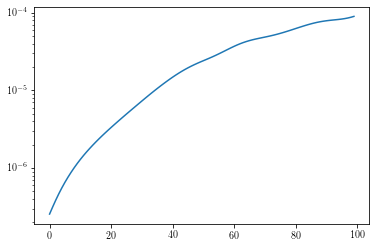

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.008e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -8.848e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.338e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.565e-0 |  2.011    |  0.4173   |  1.117    |
|  39       | -3.284e-0 |  2.303    |  0.3835   |  0.8708   |
|  51       | -2.696e-0 |  2.264    |  0.2364   |  1.75     |
|  58       | -2.599e-0 |  2.3      |  0.1391   |  1.425    |
|  73       | -2.36e-07 |  1.913    |  0.1863   |  1.355    |
|  74       | -2.326e-0 |  2.124    |  0.133    |  1.142    |
{'target': -2.32585824839362e-07, 'params': {'K': 2.124004225804796, 'a': 0.13299034291434086, 'inputscaling': 1.1424099495499023}}


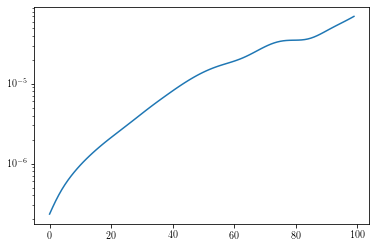

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.391e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -8.979e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.48e-07 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.294e-0 |  2.011    |  0.4173   |  1.117    |
|  39       | -2.651e-0 |  1.437    |  0.1012   |  1.97     |
{'target': -2.651159534382602e-07, 'params': {'K': 1.4372094531902797, 'a': 0.10115702791113093, 'inputscaling': 1.9701994385501864}}


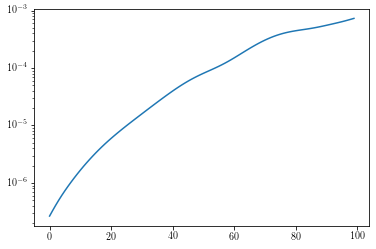

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.315e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.172e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.862e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.461e-0 |  2.011    |  0.4173   |  1.117    |
|  12       | -3.409e-0 |  2.249    |  0.3343   |  1.629    |
|  51       | -3.141e-0 |  2.264    |  0.2364   |  1.75     |
|  92       | -2.516e-0 |  2.378    |  0.1409   |  1.585    |
{'target': -2.5164629044114836e-07, 'params': {'K': 2.377866148323864, 'a': 0.14090313560409995, 'inputscaling': 1.5845232035561652}}


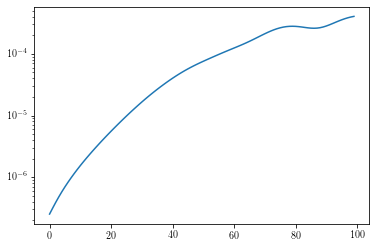

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        | -1.194e-0 |  0.907    |  0.1468   |  0.1847   |
|  3        | -9.016e-0 |  0.5588   |  0.3456   |  0.7935   |
|  4        | -4.117e-0 |  1.616    |  0.4192   |  1.37     |
|  6        | -3.553e-0 |  2.011    |  0.4173   |  1.117    |
|  12       | -3.244e-0 |  2.249    |  0.3343   |  1.629    |
|  29       | -2.808e-0 |  1.392    |  0.1358   |  1.135    |
{'target': -2.8084342588956586e-07, 'params': {'K': 1.3918848927841647, 'a': 0.13584831625272506, 'inputscaling': 1.134666614380542}}


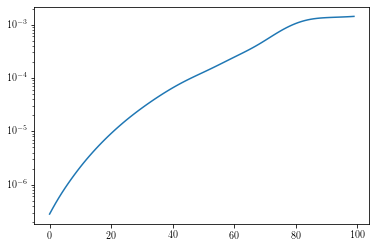

In [145]:

filename = path+'/esn_bayesopt.csv'
if os.path.exists(filename):
    os.remove(filename)

for inputdata, dim in zip(
    [
        'x',
#         'y',
#         'z', 
#         'xyz'
#         'xy',
#         'yz',
#         'xz'
    ],[
        [0],
#         [1],
#         [2],
#         [0,1,2]
#         [0,1],
#         [1,2],
#         [0,2]
    ]):
    print(inputdata)
    system_name = 'Lorenz'
    Y = np.loadtxt('dataset/matlab_gendata/'+system_name+'.csv', delimiter=',').T
    U0 = Y[dim].copy()
    U = U0 + np.random.randn(*U0.shape)*1e-3
    U = np.atleast_2d(U)

    num_prepare = 1000
    train_start = num_prepare
    num_train = 10000
    val_start = num_prepare + num_train
    num_val = 1000
    test_start = num_prepare + num_train + num_val
    num_test = 5000
    print('U shape:', U.shape)
    print('Y shape:', Y.shape)


    inSize = U.shape[0]
    resSize = 100

    U_train = U[:,train_start : train_start + num_train]
    Y_train = Y[dim,train_start + 1 : train_start + num_train + 1]
    Y_test = Y[dim,test_start + 1 : test_start + num_test + 1]

        
    for seed in range(100):
        random.seed(seed) 
        np.random.seed(seed)

        Win0 = (np.random.rand(resSize,1+inSize)-0.5) * 2
        W0 = np.random.rand(resSize,resSize)-0.5
        largest_eigvals, _ = largest_eigsh(W0@W0.T, 1, which='LM')
        rhoW = np.sqrt(largest_eigvals[0])


        # Bounded region of parameter space
        eps = 1e-8
        pbounds = {
            'a': (eps, 1), 
            'K': (eps, 3),
            'inputscaling': (eps,2),
        }

        bounds_transformer = SequentialDomainReductionTransformer()

        optimizer = BayesianOptimization(
            f=black_box,
            pbounds=pbounds,
            verbose=1, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
            random_state=1,
#             bounds_transformer=bounds_transformer
        )

        optimizer.maximize(
            init_points=10,
            n_iter=100,
        )

        print(optimizer.max)
     
        params = optimizer.max['params']
        target = optimizer.max['target']
        a, K, inputscaling = params['a'], params['K'], params['inputscaling']

        multistep_prediction(a, K, inputscaling)

        with open(filename, 'a') as file:
            file.write('{},{},{},{},{},{}\n'.format(seed, target, a, K, inputscaling, beta))


# 2 stage

x
U shape: (1, 20000)
Y shape: (3, 20000)
|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        |  6.202    |  1.09     |  0.4237   |  1.292    |
|  8        |  6.339    |  1.598    |  0.4615   |  1.561    |
|  10       |  6.387    |  1.889    |  0.5218   |  0.8293   |
|  15       |  6.65     |  1.395    |  0.06023  |  1.334    |
|  23       |  6.659    |  1.642    |  0.0971   |  1.676    |
|  32       |  6.7      |  1.496    |  0.09123  |  1.453    |
|  33       |  6.739    |  1.507    |  0.08031  |  1.437    |
{'target': 6.739034770449552, 'params': {'K': 1.5072170653692574, 'a': 0.08030552927196713, 'inputscaling': 1.4372307983220445}}


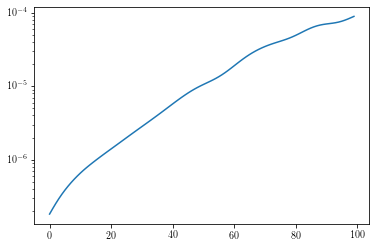

|   iter    |  target   |   beta    |
-------------------------------------
|  4        |  6.794    |  0.4488   |
|  5        |  6.803    | -0.7635   |
|  10       |  6.805    | -1.166    |
|  31       |  6.805    | -1.349    |
|  33       |  6.805    | -1.259    |
|  49       |  6.805    | -1.243    |
|  64       |  6.805    | -1.242    |
|  66       |  6.805    | -1.239    |
{'target': 6.8052150622726835, 'params': {'beta': -1.2388409593131582}}


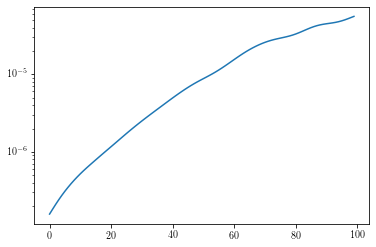

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        |  5.466    |  0.6047   |  0.1468   |  0.1847   |
|  3        |  5.949    |  0.3725   |  0.3456   |  0.7935   |
|  4        |  6.216    |  1.078    |  0.4192   |  1.37     |
|  6        |  6.333    |  1.341    |  0.4173   |  1.117    |
|  8        |  6.534    |  1.937    |  0.3134   |  1.385    |
|  44       |  6.541    |  1.93     |  0.2414   |  1.093    |
|  47       |  6.55     |  1.922    |  0.2236   |  1.085    |
|  48       |  6.646    |  1.563    |  0.09409  |  1.077    |
|  74       |  6.702    |  1.653    |  0.06917  |  1.564    |
{'target': 6.701522123032429, 'params': {'K': 1.6534395097033123, 'a': 0.06916844803976623, 'inputscaling': 1.5635450816528287}}


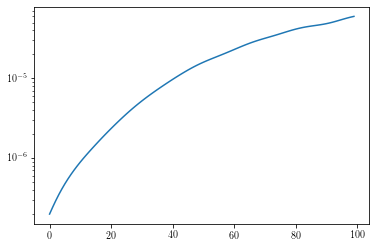

|   iter    |  target   |   beta    |
-------------------------------------
|  9        |  6.853    | -1.032    |
|  32       |  6.853    | -1.111    |
|  46       |  6.853    | -1.1      |
|  59       |  6.853    | -1.106    |
|  71       |  6.853    | -1.103    |
|  74       |  6.853    | -1.102    |
{'target': 6.852870558780346, 'params': {'beta': -1.1023491896175133}}


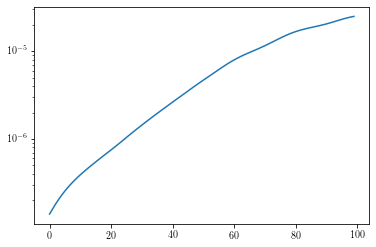

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        |  6.14     |  0.8706   |  0.4204   |  0.6607   |
|  7        |  6.558    |  1.693    |  0.07965  |  1.01     |
|  37       |  6.686    |  2.0      |  0.173    |  0.7994   |
{'target': 6.685803607569256, 'params': {'K': 2.0, 'a': 0.17299699897975093, 'inputscaling': 0.7993535788754876}}


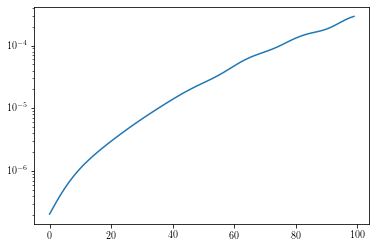

|   iter    |  target   |   beta    |
-------------------------------------
|  4        |  6.819    | -0.6468   |
|  5        |  6.821    | -0.7963   |
|  30       |  6.823    | -1.502    |
|  31       |  6.826    | -1.348    |
|  32       |  6.826    | -1.26     |
|  34       |  6.826    | -1.229    |
|  40       |  6.826    | -1.228    |
|  58       |  6.826    | -1.233    |
|  69       |  6.826    | -1.235    |
|  76       |  6.826    | -1.236    |
|  93       |  6.826    | -1.236    |
|  99       |  6.826    | -1.236    |
{'target': 6.8264257409381095, 'params': {'beta': -1.2357934942282631}}


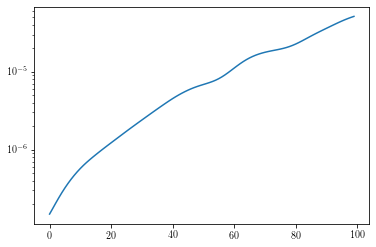

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  5        |  6.406    |  1.298    |  0.2785   |  1.353    |
|  28       |  6.469    |  1.107    |  0.1878   |  1.904    |
|  32       |  6.672    |  1.644    |  0.09029  |  1.869    |
|  33       |  6.713    |  2.0      |  0.1007   |  1.515    |
{'target': 6.713120517722026, 'params': {'K': 2.0, 'a': 0.10073920302490695, 'inputscaling': 1.514691630678077}}


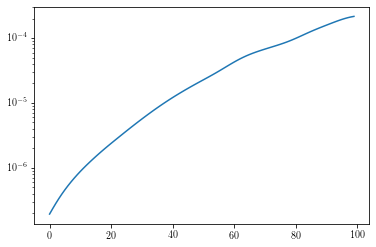

|   iter    |  target   |   beta    |
-------------------------------------
|  3        |  6.835    | -2.091    |
|  20       |  6.839    | -0.849    |
|  27       |  6.84     | -1.936    |
|  29       |  6.844    | -1.12     |
|  32       |  6.844    | -1.103    |
|  42       |  6.844    | -1.102    |
{'target': 6.844438023936112, 'params': {'beta': -1.1016963723672724}}


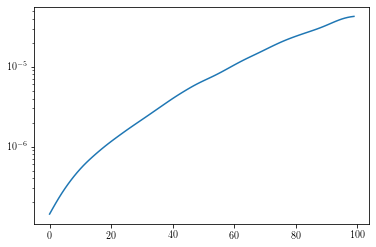

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  14       |  6.303    |  1.3      |  0.3969   |  1.248    |
|  15       |  6.454    |  1.535    |  0.179    |  0.7512   |
|  19       |  6.462    |  0.9956   |  0.1824   |  1.837    |
|  23       |  6.633    |  1.191    |  0.08466  |  1.195    |
|  41       |  6.761    |  1.286    |  0.07039  |  1.704    |
{'target': 6.760965171715219, 'params': {'K': 1.286110404463291, 'a': 0.07038840520384619, 'inputscaling': 1.7037234677306037}}


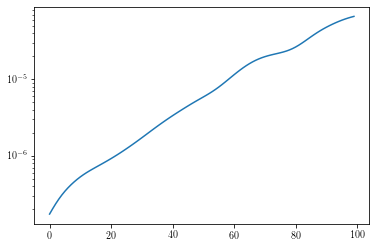

|   iter    |  target   |   beta    |
-------------------------------------
|  9        |  6.793    | -2.47     |
|  10       |  6.804    | -0.6521   |
|  18       |  6.804    | -1.134    |
|  30       |  6.805    | -0.9156   |
|  32       |  6.805    | -0.885    |
|  33       |  6.805    | -0.8591   |
|  34       |  6.805    | -0.835    |
|  50       |  6.805    | -0.8402   |
{'target': 6.805101942257635, 'params': {'beta': -0.8402007250763962}}


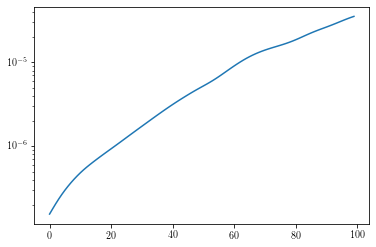

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        |  6.345    |  1.837    |  0.4884   |  1.223    |
|  5        |  6.47     |  0.8826   |  0.1583   |  1.76     |
|  14       |  6.568    |  1.971    |  0.2591   |  1.605    |
|  32       |  6.619    |  1.91     |  0.2125   |  1.278    |
|  58       |  6.627    |  1.684    |  0.1273   |  1.879    |
|  62       |  6.639    |  2.0      |  0.2116   |  0.76     |
|  76       |  6.653    |  1.653    |  0.1114   |  1.729    |
|  85       |  6.676    |  1.954    |  0.1065   |  0.8959   |
|  100      |  6.691    |  1.485    |  0.07876  |  1.921    |
{'target': 6.691418249027306, 'params': {'K': 1.4850873098161865, 'a': 0.07875701606210005, 'inputscaling': 1.9209070878593493}}


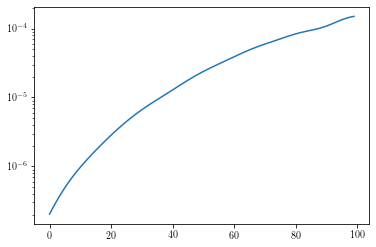

|   iter    |  target   |   beta    |
-------------------------------------
|  5        |  6.798    | -0.1159   |
|  13       |  6.803    | -0.5869   |
|  17       |  6.805    | -0.8576   |
|  44       |  6.805    | -0.8546   |
|  53       |  6.805    | -0.8387   |
{'target': 6.805185916573126, 'params': {'beta': -0.8386672766143575}}


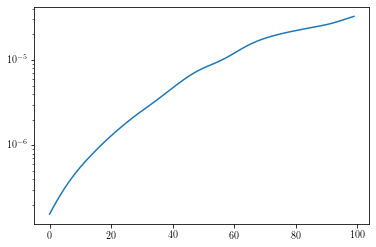

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  13       |  6.428    |  1.875    |  0.3518   |  0.5073   |
|  24       |  6.508    |  1.366    |  0.1393   |  1.406    |
|  32       |  6.533    |  1.402    |  0.08561  |  2.0      |
|  52       |  6.625    |  1.752    |  0.06555  |  1.87     |
|  66       |  6.636    |  1.915    |  0.1679   |  1.767    |
{'target': 6.6356941454222405, 'params': {'K': 1.9149554679006802, 'a': 0.16790724831419065, 'inputscaling': 1.7668090856571417}}


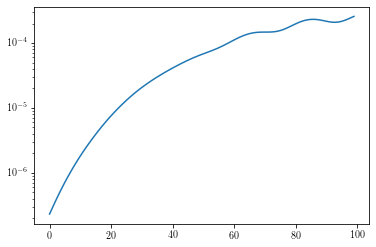

|   iter    |  target   |   beta    |
-------------------------------------
|  2        |  6.681    | -1.68     |
|  6        |  6.691    |  0.9505   |
|  7        |  6.703    |  0.2982   |
|  31       |  6.703    |  0.2554   |
|  34       |  6.703    |  0.2584   |
|  51       |  6.703    |  0.2594   |
|  56       |  6.703    |  0.259    |
{'target': 6.703262196774649, 'params': {'beta': 0.2590409199016582}}


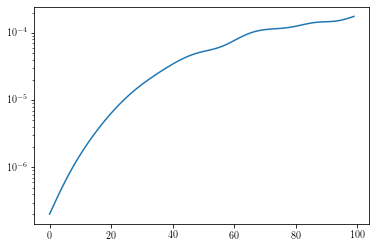

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        |  5.931    |  1.447    |  0.978    |  1.077    |
|  3        |  5.941    |  1.002    |  0.07205  |  0.5369   |
|  4        |  5.984    |  0.9998   |  0.6792   |  1.607    |
|  6        |  6.475    |  1.819    |  0.2134   |  0.9042   |
|  8        |  6.545    |  1.9      |  0.2303   |  1.097    |
|  9        |  6.558    |  1.818    |  0.1332   |  1.047    |
{'target': 6.5584445246547896, 'params': {'K': 1.8182567506821787, 'a': 0.13316945442755568, 'inputscaling': 1.0468251661134058}}


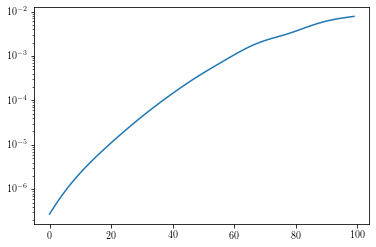

|   iter    |  target   |   beta    |
-------------------------------------
|  3        |  6.639    | -0.6159   |
|  6        |  6.648    |  0.385    |
|  45       |  6.648    |  0.3991   |
|  70       |  6.648    |  0.4011   |
{'target': 6.647559681809711, 'params': {'beta': 0.4010769330627648}}


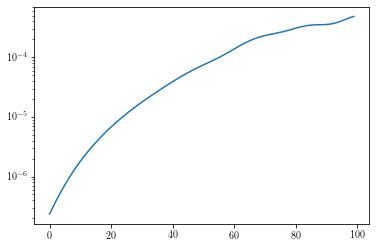

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  3        |  6.153    |  0.8609   |  0.4024   |  1.045    |
|  6        |  6.292    |  0.8522   |  0.2891   |  1.948    |
|  8        |  6.538    |  1.966    |  0.1279   |  0.6443   |
|  14       |  6.544    |  1.276    |  0.06869  |  1.207    |
|  44       |  6.571    |  1.456    |  0.07017  |  1.952    |
|  47       |  6.581    |  2.0      |  0.1468   |  0.8823   |
|  84       |  6.652    |  2.0      |  0.1308   |  1.699    |
{'target': 6.6515178039016964, 'params': {'K': 2.0, 'a': 0.1307744545718946, 'inputscaling': 1.6989043340526502}}


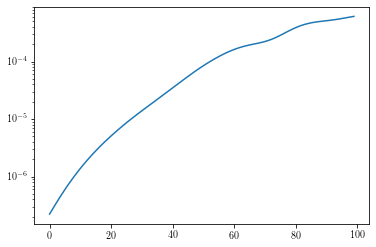

|   iter    |  target   |   beta    |
-------------------------------------
|  3        |  6.66     |  3.692    |
|  4        |  6.703    |  0.3086   |
|  5        |  6.717    | -2.673    |
|  7        |  6.741    | -0.6953   |
|  32       |  6.741    | -0.7138   |
|  46       |  6.741    | -0.7059   |
|  86       |  6.741    | -0.7055   |
{'target': 6.741252545803917, 'params': {'beta': -0.7055438508424434}}


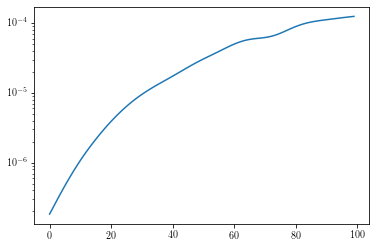

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  3        |  5.941    |  0.837    |  0.2481   |  0.1681   |
|  4        |  6.354    |  0.691    |  0.1668   |  1.757    |
|  26       |  6.398    |  1.458    |  0.4159   |  1.168    |
|  32       |  6.486    |  0.9597   |  0.1368   |  1.836    |
|  37       |  6.524    |  1.202    |  0.0559   |  1.778    |
|  39       |  6.582    |  1.219    |  0.141    |  1.92     |
|  54       |  6.676    |  1.499    |  0.1105   |  0.8475   |
{'target': 6.67575076164286, 'params': {'K': 1.4992506743697298, 'a': 0.11047753608821854, 'inputscaling': 0.84745715888726}}


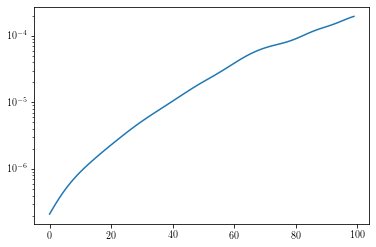

|   iter    |  target   |   beta    |
-------------------------------------
|  2        |  6.784    |  0.01875  |
|  3        |  6.784    | -0.04227  |
|  16       |  6.789    |  0.7276   |
|  32       |  6.789    |  0.6455   |
|  39       |  6.789    |  0.6455   |
|  46       |  6.789    |  0.6464   |
|  68       |  6.789    |  0.6485   |
|  86       |  6.789    |  0.6488   |
{'target': 6.7888507603433785, 'params': {'beta': 0.648751831590204}}


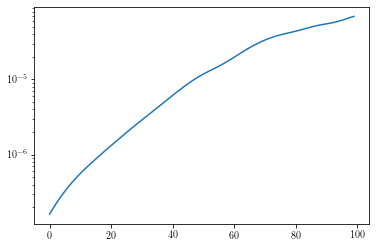

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        |  6.239    |  1.498    |  0.4985   |  0.4496   |
|  16       |  6.435    |  1.509    |  0.296    |  1.768    |
|  33       |  6.447    |  1.506    |  0.2904   |  1.731    |
|  36       |  6.462    |  1.565    |  0.2834   |  1.744    |
|  47       |  6.482    |  1.672    |  0.3279   |  1.126    |
|  50       |  6.55     |  1.818    |  0.2807   |  1.127    |
|  53       |  6.559    |  1.897    |  0.289    |  0.9975   |
|  54       |  6.655    |  1.995    |  0.2127   |  1.103    |
|  55       |  6.694    |  1.906    |  0.1404   |  1.038    |
|  77       |  6.698    |  1.842    |  0.1799   |  1.499    |
|  78       |  6.725    |  1.939    |  0.1241   |  1.629    |
{'target': 6.724912780908215, 'params': {'K': 1.939305976607395, 'a': 0.12406664943474259, 'inputscaling': 1.629113231281235}}


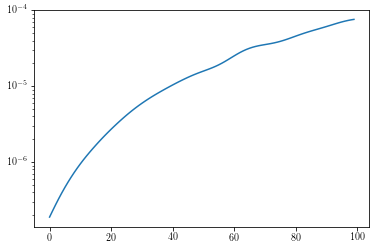

|   iter    |  target   |   beta    |
-------------------------------------
|  3        |  6.769    |  1.336    |
|  5        |  6.781    | -0.01493  |
|  6        |  6.788    | -2.752    |
|  18       |  6.803    | -2.081    |
|  23       |  6.808    | -1.267    |
|  31       |  6.808    | -1.426    |
|  32       |  6.808    | -1.562    |
|  41       |  6.809    | -1.553    |
{'target': 6.808528897213963, 'params': {'beta': -1.5534753231518623}}


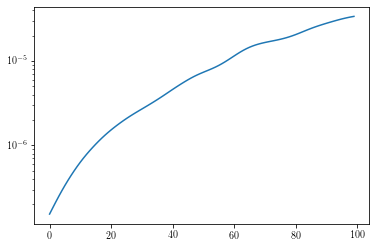

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        |  6.365    |  1.45     |  0.4202   |  0.9709   |
|  8        |  6.469    |  1.637    |  0.3446   |  0.6376   |
|  10       |  6.47     |  1.199    |  0.05567  |  0.9596   |
|  13       |  6.513    |  1.973    |  0.3381   |  0.4797   |
|  70       |  6.514    |  1.965    |  0.3353   |  0.4716   |
|  77       |  6.613    |  1.468    |  0.1408   |  0.9536   |
{'target': 6.612757961257927, 'params': {'K': 1.4676549448622918, 'a': 0.14084066899192554, 'inputscaling': 0.9535560564245107}}


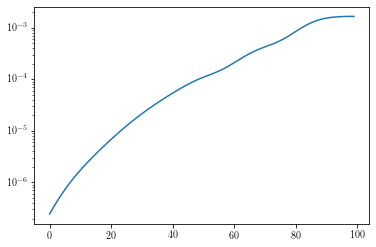

|   iter    |  target   |   beta    |
-------------------------------------
|  3        |  6.697    | -0.3678   |
|  6        |  6.699    | -0.1457   |
|  8        |  6.699    | -0.1263   |
|  31       |  6.699    |  0.04774  |
|  32       |  6.7      | -0.02637  |
|  34       |  6.7      | -0.02638  |
|  35       |  6.7      | -0.0266   |
|  40       |  6.7      | -0.02643  |
|  47       |  6.7      | -0.01541  |
{'target': 6.699852630598598, 'params': {'beta': -0.01540723233037971}}


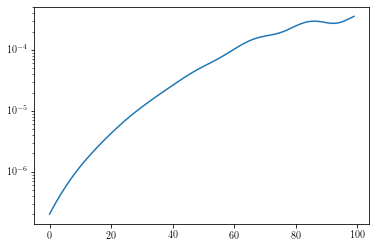

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  4        |  6.051    |  0.2744   |  0.2838   |  1.212    |
|  6        |  6.133    |  1.042    |  0.552    |  0.9708   |
|  7        |  6.611    |  1.536    |  0.1607   |  1.529    |
|  26       |  6.643    |  1.889    |  0.07347  |  1.19     |
|  32       |  6.666    |  1.512    |  0.09813  |  1.132    |
{'target': 6.665897960860649, 'params': {'K': 1.5123846442669624, 'a': 0.0981318506122628, 'inputscaling': 1.1315459163470034}}


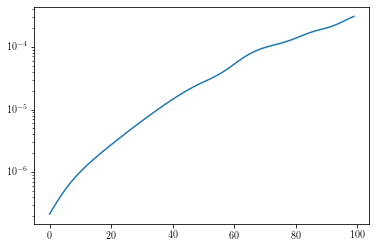

|   iter    |  target   |   beta    |
-------------------------------------
|  3        |  6.74     | -2.367    |
|  4        |  6.758    |  0.3374   |
|  16       |  6.761    |  0.2123   |
|  31       |  6.762    |  0.06355  |
|  32       |  6.762    |  0.09219  |
|  33       |  6.762    |  0.09148  |
|  35       |  6.762    |  0.0891   |
|  38       |  6.762    |  0.08655  |
{'target': 6.762298211668773, 'params': {'beta': 0.0865537090725497}}


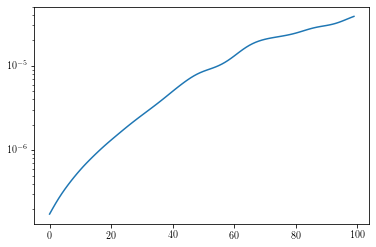

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  11       |  6.694    |  1.626    |  0.07572  |  1.313    |
{'target': 6.693650780188102, 'params': {'K': 1.625682343876835, 'a': 0.07571745541509226, 'inputscaling': 1.3129106726293622}}


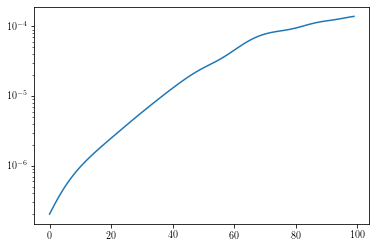

|   iter    |  target   |   beta    |
-------------------------------------
|  2        |  6.766    | -2.625    |
|  6        |  6.774    | -0.4655   |
|  12       |  6.776    | -2.016    |
|  23       |  6.777    | -1.806    |
|  32       |  6.777    | -1.817    |
|  36       |  6.777    | -1.827    |
|  41       |  6.777    | -1.831    |
|  54       |  6.777    | -1.83     |
{'target': 6.777487469958635, 'params': {'beta': -1.830454632194917}}


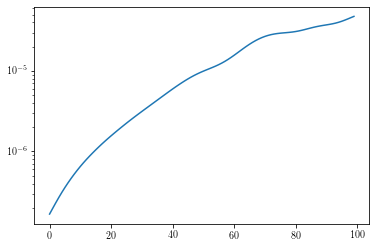

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  3        |  6.34     |  1.026    |  0.3183   |  1.078    |
|  9        |  6.504    |  1.346    |  0.2576   |  1.402    |
|  11       |  6.579    |  1.775    |  0.08335  |  1.493    |
|  16       |  6.589    |  1.998    |  0.2879   |  0.9236   |
|  34       |  6.636    |  1.749    |  0.1703   |  1.139    |
{'target': 6.635642016844938, 'params': {'K': 1.7493866125987911, 'a': 0.170257823475196, 'inputscaling': 1.1385365987881522}}


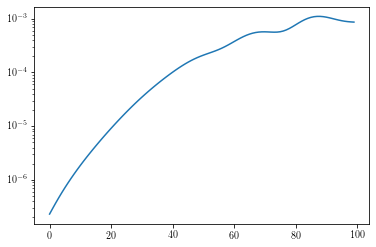

|   iter    |  target   |   beta    |
-------------------------------------
|  7        |  6.727    |  0.1312   |
|  13       |  6.728    |  0.3889   |
|  31       |  6.728    |  0.268    |
|  33       |  6.728    |  0.2655   |
|  34       |  6.728    |  0.2653   |
|  35       |  6.728    |  0.2655   |
|  62       |  6.728    |  0.272    |
|  89       |  6.728    |  0.2719   |
{'target': 6.727916493047277, 'params': {'beta': 0.2718792494135977}}


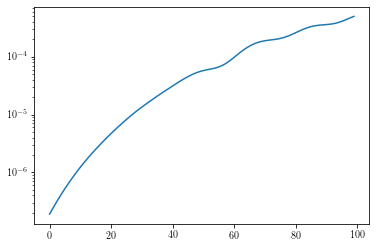

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        |  6.205    |  0.7231   |  0.2754   |  1.06     |
|  10       |  6.294    |  0.9302   |  0.1416   |  1.077    |
|  26       |  6.395    |  1.273    |  0.2198   |  1.095    |
|  31       |  6.459    |  1.26     |  0.05716  |  1.512    |
|  32       |  6.601    |  1.722    |  0.1515   |  1.674    |
|  44       |  6.631    |  1.973    |  0.1372   |  2.0      |
{'target': 6.6307125124700566, 'params': {'K': 1.9728698211944502, 'a': 0.13723987224196285, 'inputscaling': 2.0}}


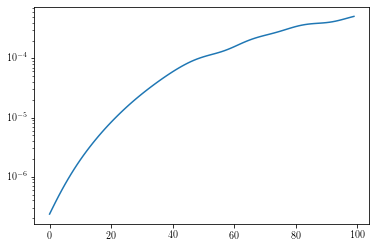

|   iter    |  target   |   beta    |
-------------------------------------
|  2        |  6.652    | -3.211    |
|  4        |  6.67     | -1.385    |
|  22       |  6.672    | -1.272    |
|  24       |  6.677    | -0.2653   |
|  28       |  6.678    | -0.3491   |
|  31       |  6.678    | -0.4147   |
|  32       |  6.679    | -0.4706   |
|  33       |  6.679    | -0.5264   |
|  40       |  6.679    | -0.504    |
|  75       |  6.679    | -0.5034   |
|  81       |  6.679    | -0.5037   |
{'target': 6.678880789197177, 'params': {'beta': -0.5037419549576119}}


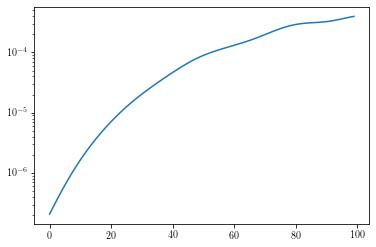

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  3        |  6.07     |  1.377    |  0.1637   |  0.1406   |
|  4        |  6.228    |  1.882    |  0.5637   |  0.156    |
|  5        |  6.311    |  1.445    |  0.1585   |  0.5006   |
|  17       |  6.593    |  1.954    |  0.2154   |  0.7128   |
|  30       |  6.713    |  1.532    |  0.06831  |  1.212    |
|  39       |  6.751    |  1.549    |  0.1012   |  1.21     |
{'target': 6.751314856843119, 'params': {'K': 1.5489701252454844, 'a': 0.10124092999259517, 'inputscaling': 1.2102247377377928}}


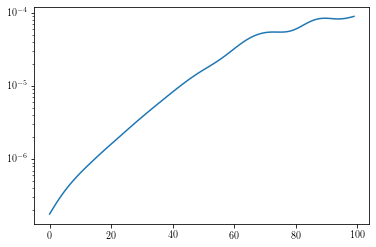

|   iter    |  target   |   beta    |
-------------------------------------
|  2        |  6.834    |  0.2316   |
|  3        |  6.835    |  0.507    |
|  28       |  6.835    |  0.4327   |
|  36       |  6.835    |  0.4284   |
|  54       |  6.835    |  0.434    |
{'target': 6.835037254183067, 'params': {'beta': 0.43399365810969104}}


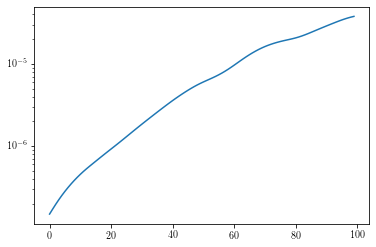

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  5        |  6.067    |  1.728    |  0.8773   |  0.1024   |
|  6        |  6.203    |  1.305    |  0.5518   |  1.195    |
|  7        |  6.208    |  0.9671   |  0.283    |  0.5955   |
|  8        |  6.284    |  1.123    |  0.396    |  1.577    |
|  13       |  6.503    |  1.354    |  0.1185   |  0.89     |
|  33       |  6.51     |  1.354    |  0.1185   |  0.9102   |
|  39       |  6.66     |  2.0      |  0.2091   |  1.403    |
{'target': 6.660147135094439, 'params': {'K': 2.0, 'a': 0.20906444797669665, 'inputscaling': 1.4033021818349045}}


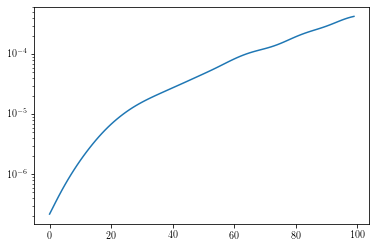

|   iter    |  target   |   beta    |
-------------------------------------
|  10       |  6.703    | -1.422    |
|  31       |  6.703    | -1.24     |
|  32       |  6.703    | -1.208    |
|  38       |  6.703    | -1.221    |
|  46       |  6.703    | -1.217    |
|  52       |  6.703    | -1.222    |
|  61       |  6.703    | -1.222    |
|  63       |  6.703    | -1.221    |
|  83       |  6.703    | -1.222    |
|  94       |  6.703    | -1.221    |
{'target': 6.703271220024101, 'params': {'beta': -1.2214793153910406}}


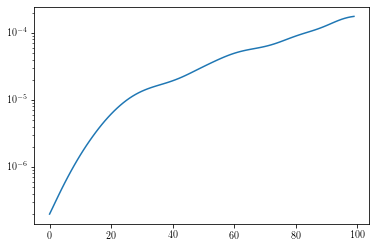

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  10       |  6.569    |  1.333    |  0.2113   |  1.615    |
|  18       |  6.587    |  1.616    |  0.2173   |  1.869    |
|  33       |  6.596    |  1.3      |  0.1713   |  1.976    |
{'target': 6.595615538791171, 'params': {'K': 1.2995647154333516, 'a': 0.17131249067295495, 'inputscaling': 1.9762881272713357}}


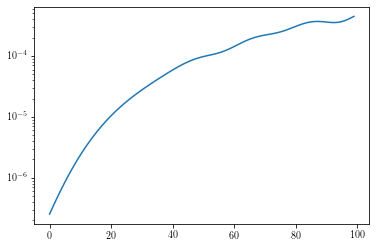

|   iter    |  target   |   beta    |
-------------------------------------
|  2        |  6.649    |  0.05453  |
|  22       |  6.652    | -1.476    |
|  27       |  6.652    | -0.234    |
|  34       |  6.652    | -0.2763   |
|  71       |  6.652    | -0.2762   |
|  74       |  6.652    | -0.2772   |
{'target': 6.652187723982817, 'params': {'beta': -0.27718310350302566}}


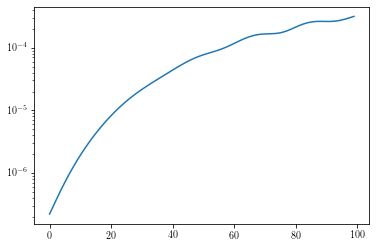

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  3        |  5.953    |  1.344    |  0.8066   |  1.965    |
|  4        |  6.443    |  1.271    |  0.2159   |  1.098    |
|  10       |  6.467    |  1.5      |  0.2868   |  1.419    |
|  21       |  6.59     |  1.718    |  0.1825   |  1.457    |
|  33       |  6.714    |  1.747    |  0.0861   |  1.405    |
|  34       |  6.716    |  1.968    |  0.1145   |  1.314    |
{'target': 6.716418580930944, 'params': {'K': 1.9678141605041746, 'a': 0.1145149156402729, 'inputscaling': 1.3144558958690202}}


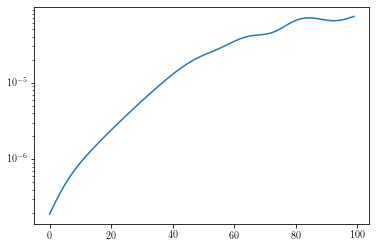

|   iter    |  target   |   beta    |
-------------------------------------
|  3        |  6.807    | -2.531    |
|  5        |  6.812    | -1.686    |
|  19       |  6.813    | -1.13     |
|  31       |  6.815    | -0.9647   |
|  32       |  6.815    | -0.8243   |
|  35       |  6.815    | -0.8104   |
|  36       |  6.815    | -0.7965   |
|  41       |  6.815    | -0.7976   |
{'target': 6.8151544075853145, 'params': {'beta': -0.7976118247053593}}


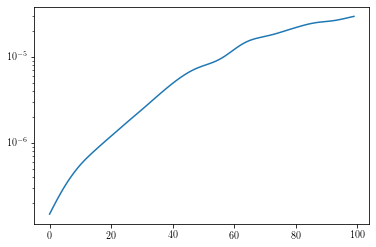

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  3        |  6.031    |  0.7574   |  0.5185   |  1.316    |
|  4        |  6.112    |  0.3877   |  0.2723   |  1.437    |
|  7        |  6.181    |  0.4784   |  0.2548   |  1.715    |
|  8        |  6.341    |  1.9      |  0.5617   |  0.3576   |
|  10       |  6.403    |  1.679    |  0.461    |  0.9959   |
|  16       |  6.44     |  1.164    |  0.1616   |  1.196    |
|  17       |  6.654    |  1.652    |  0.1564   |  1.469    |
|  38       |  6.687    |  1.749    |  0.1419   |  1.646    |
|  67       |  6.695    |  1.789    |  0.145    |  1.506    |
{'target': 6.694679862705624, 'params': {'K': 1.7886435849372055, 'a': 0.14500120366216004, 'inputscaling': 1.5057117859643196}}


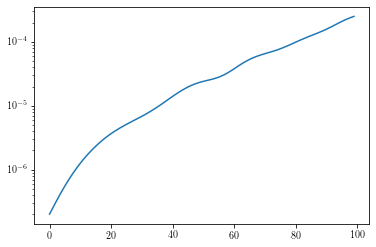

|   iter    |  target   |   beta    |
-------------------------------------
|  7        |  6.755    | -1.213    |
|  32       |  6.756    | -1.375    |
|  34       |  6.756    | -1.423    |
|  35       |  6.756    | -1.413    |
|  43       |  6.756    | -1.411    |
|  48       |  6.756    | -1.406    |
|  53       |  6.756    | -1.408    |
{'target': 6.7561494740577235, 'params': {'beta': -1.4083391221845136}}


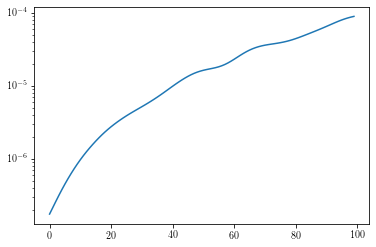

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  3        |  5.875    |  0.6045   |  0.6639   |  0.6162   |
|  4        |  6.623    |  1.167    |  0.06957  |  1.735    |
|  41       |  6.631    |  1.802    |  0.1781   |  1.698    |
{'target': 6.630608329003331, 'params': {'K': 1.801959691877676, 'a': 0.17814190561091123, 'inputscaling': 1.697785307311225}}


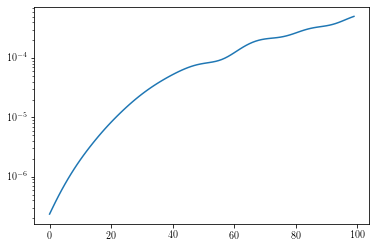

|   iter    |  target   |   beta    |
-------------------------------------
|  2        |  6.678    | -2.109    |
|  7        |  6.679    | -1.977    |
|  9        |  6.679    | -1.919    |
|  31       |  6.68     | -1.761    |
|  32       |  6.68     | -1.627    |
|  35       |  6.68     | -1.674    |
|  36       |  6.68     | -1.672    |
|  39       |  6.68     | -1.678    |
|  44       |  6.68     | -1.676    |
|  51       |  6.68     | -1.665    |
{'target': 6.680219666815788, 'params': {'beta': -1.6646828110780474}}


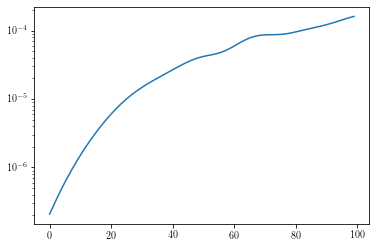

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        |  6.582    |  1.718    |  0.1712   |  0.6777   |
|  29       |  6.584    |  1.773    |  0.2518   |  1.724    |
|  34       |  6.631    |  1.835    |  0.2783   |  1.28     |
|  86       |  6.652    |  1.966    |  0.1784   |  1.081    |
{'target': 6.652309953802756, 'params': {'K': 1.9659302918156303, 'a': 0.17835313233278097, 'inputscaling': 1.0807304819477712}}


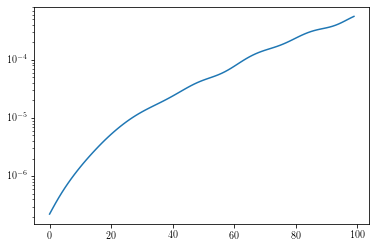

|   iter    |  target   |   beta    |
-------------------------------------
|  6        |  6.785    | -1.611    |
|  20       |  6.785    | -2.024    |
|  38       |  6.785    | -2.011    |
|  67       |  6.785    | -2.015    |
|  76       |  6.785    | -2.013    |
{'target': 6.785438551028047, 'params': {'beta': -2.013328213545412}}


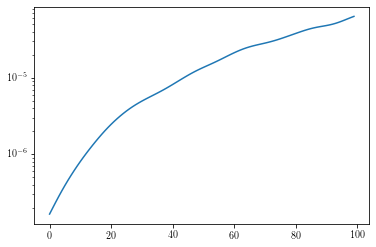

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        |  6.207    |  0.5648   |  0.221    |  1.372    |
|  5        |  6.488    |  1.77     |  0.3004   |  1.179    |
|  9        |  6.634    |  1.884    |  0.1415   |  0.8432   |
|  34       |  6.642    |  1.963    |  0.07162  |  1.454    |
{'target': 6.641705160697685, 'params': {'K': 1.9628034420099691, 'a': 0.07162449942497216, 'inputscaling': 1.4544214495134478}}


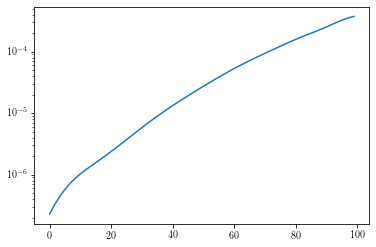

|   iter    |  target   |   beta    |
-------------------------------------
|  8        |  6.804    | -1.076    |
|  31       |  6.804    | -0.9942   |
|  32       |  6.804    | -0.9949   |
|  35       |  6.804    | -0.9969   |
|  41       |  6.804    | -0.9994   |
|  57       |  6.804    | -0.9896   |
{'target': 6.804481620202798, 'params': {'beta': -0.989640741955592}}


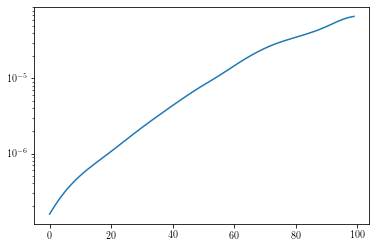

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  3        |  6.351    |  1.993    |  0.3163   |  0.2731   |
|  19       |  6.722    |  1.399    |  0.09752  |  1.147    |
|  41       |  6.755    |  1.386    |  0.0814   |  1.153    |
|  68       |  6.792    |  1.986    |  0.1332   |  1.023    |
{'target': 6.792266319898775, 'params': {'K': 1.9864973743997667, 'a': 0.13317889889390883, 'inputscaling': 1.0233304420738343}}


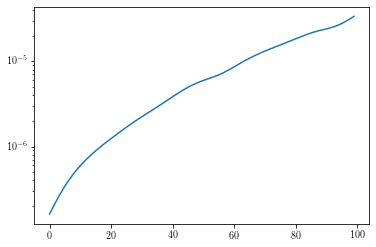

|   iter    |  target   |   beta    |
-------------------------------------
|  2        |  6.848    |  1.995    |
|  4        |  6.855    | -2.799    |
|  5        |  6.869    | -1.389    |
|  31       |  6.869    | -1.404    |
|  34       |  6.869    | -1.354    |
|  52       |  6.869    | -1.366    |
|  59       |  6.869    | -1.372    |
|  92       |  6.869    | -1.372    |
{'target': 6.86946556361528, 'params': {'beta': -1.3717578144892206}}


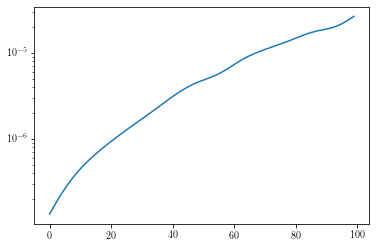

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  10       |  6.352    |  1.44     |  0.421    |  0.8739   |
|  14       |  6.672    |  1.647    |  0.07714  |  1.29     |
|  30       |  6.681    |  1.662    |  0.1127   |  1.134    |
|  45       |  6.684    |  1.652    |  0.1074   |  1.283    |
{'target': 6.683977624686977, 'params': {'K': 1.6524511373446442, 'a': 0.10738560540200512, 'inputscaling': 1.2831964131207767}}


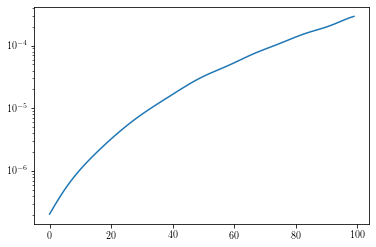

|   iter    |  target   |   beta    |
-------------------------------------
|  2        |  6.748    |  0.8228   |
|  3        |  6.762    | -2.212    |
|  5        |  6.773    | -0.889    |
|  10       |  6.774    | -1.329    |
|  23       |  6.774    | -1.17     |
|  31       |  6.774    | -1.247    |
|  32       |  6.774    | -1.243    |
|  35       |  6.774    | -1.243    |
|  36       |  6.774    | -1.244    |
|  39       |  6.774    | -1.245    |
|  43       |  6.774    | -1.246    |
|  75       |  6.774    | -1.245    |
{'target': 6.77447695659743, 'params': {'beta': -1.2449219035180934}}


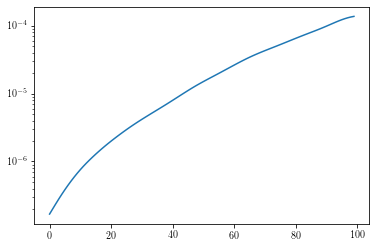

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        |  6.025    |  1.578    |  0.8706   |  0.3758   |
|  4        |  6.2      |  0.3899   |  0.1797   |  1.078    |
|  9        |  6.22     |  1.951    |  0.6196   |  1.441    |
|  12       |  6.332    |  1.289    |  0.2956   |  1.365    |
|  20       |  6.407    |  1.024    |  0.08145  |  1.046    |
|  90       |  6.605    |  1.734    |  0.06274  |  1.509    |
{'target': 6.605310069742768, 'params': {'K': 1.7336559317430607, 'a': 0.06273749345732019, 'inputscaling': 1.5089080721384818}}


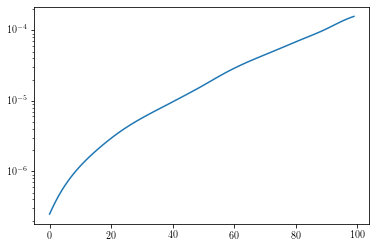

|   iter    |  target   |   beta    |
-------------------------------------
|  2        |  6.717    |  0.1939   |
|  8        |  6.723    | -0.03808  |
|  20       |  6.724    | -0.1451   |
|  35       |  6.724    | -0.192    |
|  38       |  6.724    | -0.1706   |
|  41       |  6.724    | -0.1596   |
|  42       |  6.724    | -0.2008   |
|  62       |  6.724    | -0.1973   |
{'target': 6.724052221429626, 'params': {'beta': -0.19731257203685287}}


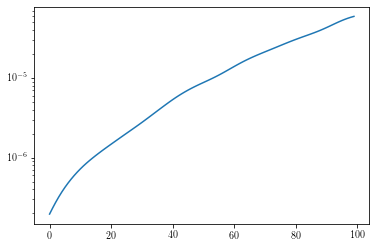

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        |  6.351    |  1.736    |  0.3834   |  1.959    |
|  3        |  6.63     |  1.786    |  0.2097   |  1.484    |
|  42       |  6.633    |  1.338    |  0.08475  |  2.0      |
{'target': 6.633304608253943, 'params': {'K': 1.3376891360744507, 'a': 0.0847513905112891, 'inputscaling': 2.0}}


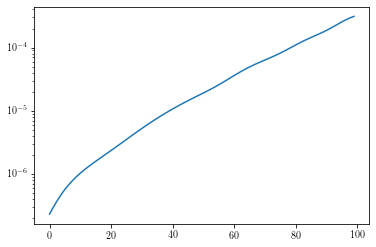

|   iter    |  target   |   beta    |
-------------------------------------
|  5        |  6.744    | -1.166    |
|  38       |  6.744    | -1.174    |
|  43       |  6.744    | -1.173    |
{'target': 6.743813469982644, 'params': {'beta': -1.1733645385563827}}


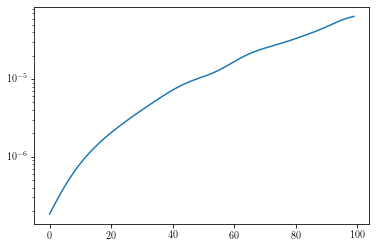

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  4        |  6.567    |  1.968    |  0.1927   |  1.942    |
|  17       |  6.657    |  1.792    |  0.1619   |  1.221    |
|  66       |  6.682    |  1.973    |  0.1493   |  1.211    |
{'target': 6.682073767644662, 'params': {'K': 1.9727112326887017, 'a': 0.14928347953037732, 'inputscaling': 1.2109290615396258}}


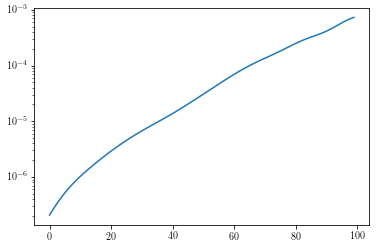

|   iter    |  target   |   beta    |
-------------------------------------
|  2        |  6.787    |  0.6124   |
|  4        |  6.798    | -1.024    |
|  19       |  6.798    | -1.046    |
|  32       |  6.798    | -1.097    |
|  33       |  6.798    | -1.088    |
|  34       |  6.798    | -1.089    |
|  36       |  6.798    | -1.089    |
|  48       |  6.798    | -1.089    |
|  52       |  6.798    | -1.095    |
|  62       |  6.798    | -1.101    |
|  87       |  6.798    | -1.102    |
{'target': 6.798276861215026, 'params': {'beta': -1.1016480089279257}}


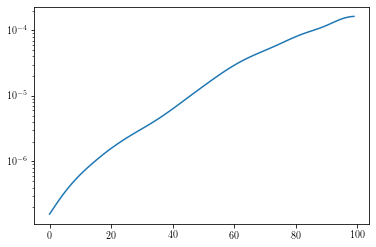

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        |  6.343    |  1.526    |  0.4527   |  1.085    |
|  4        |  6.527    |  1.466    |  0.242    |  1.441    |
|  12       |  6.602    |  1.316    |  0.08335  |  1.327    |
|  86       |  6.652    |  1.994    |  0.09039  |  1.917    |
{'target': 6.652215727301397, 'params': {'K': 1.9941713381174668, 'a': 0.09038893108387415, 'inputscaling': 1.9173121285031753}}


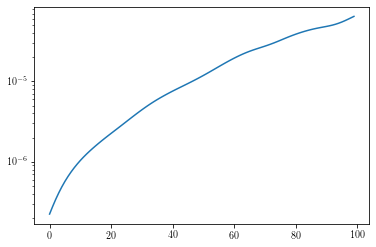

|   iter    |  target   |   beta    |
-------------------------------------
|  2        |  6.771    | -2.151    |
|  5        |  6.787    | -0.4728   |
|  6        |  6.788    |  0.423    |
|  25       |  6.792    | -0.1527   |
|  31       |  6.792    | -0.05439  |
|  36       |  6.792    | -0.1092   |
|  40       |  6.792    | -0.1122   |
|  46       |  6.792    | -0.1237   |
|  51       |  6.792    | -0.1135   |
|  82       |  6.792    | -0.1132   |
|  94       |  6.792    | -0.1132   |
{'target': 6.792475191812597, 'params': {'beta': -0.11321647199893844}}


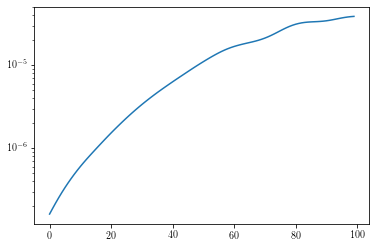

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  3        |  6.597    |  1.984    |  0.2351   |  1.171    |
|  44       |  6.61     |  1.467    |  0.1316   |  1.196    |
|  65       |  6.622    |  1.619    |  0.1169   |  1.745    |
|  85       |  6.679    |  1.839    |  0.06238  |  1.605    |
|  89       |  6.752    |  1.651    |  0.06771  |  1.532    |
{'target': 6.751843311374355, 'params': {'K': 1.650532623045374, 'a': 0.067705216042189, 'inputscaling': 1.5320551058146794}}


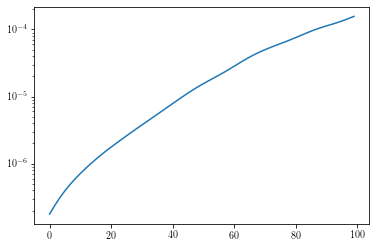

|   iter    |  target   |   beta    |
-------------------------------------
|  2        |  6.825    | -1.193    |
|  10       |  6.826    | -0.9331   |
|  31       |  6.829    | -0.7637   |
|  32       |  6.832    | -0.6198   |
|  33       |  6.833    | -0.4758   |
|  34       |  6.833    | -0.5163   |
|  43       |  6.833    | -0.5081   |
|  49       |  6.833    | -0.4934   |
|  60       |  6.833    | -0.4998   |
|  69       |  6.833    | -0.5013   |
|  76       |  6.833    | -0.5002   |
|  77       |  6.833    | -0.5009   |
{'target': 6.832790732835617, 'params': {'beta': -0.5008595606121885}}


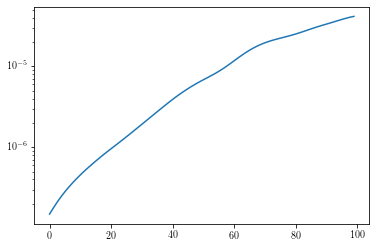

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        |  6.367    |  1.974    |  0.2082   |  0.2738   |
|  4        |  6.472    |  1.087    |  0.0894   |  0.7648   |
|  10       |  6.578    |  1.949    |  0.1843   |  0.4845   |
|  81       |  6.652    |  1.859    |  0.1321   |  1.635    |
{'target': 6.651900514731175, 'params': {'K': 1.8586891374373065, 'a': 0.13210568310908352, 'inputscaling': 1.6346407606914382}}


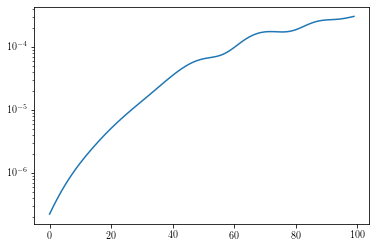

|   iter    |  target   |   beta    |
-------------------------------------
|  12       |  6.766    | -1.176    |
|  14       |  6.773    | -0.7083   |
|  31       |  6.773    | -0.6564   |
|  32       |  6.773    | -0.6796   |
|  35       |  6.773    | -0.6937   |
|  70       |  6.773    | -0.691    |
|  84       |  6.773    | -0.6906   |
{'target': 6.7734447529906845, 'params': {'beta': -0.6906065259547615}}


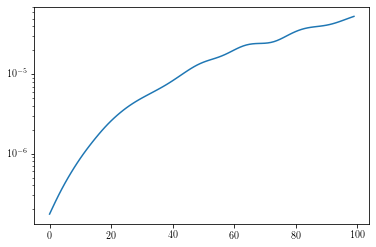

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  10       |  6.627    |  1.419    |  0.1606   |  1.622    |
|  33       |  6.678    |  1.871    |  0.1263   |  1.595    |
{'target': 6.678108541634687, 'params': {'K': 1.8707255503939693, 'a': 0.1263240432026866, 'inputscaling': 1.5945352239333739}}


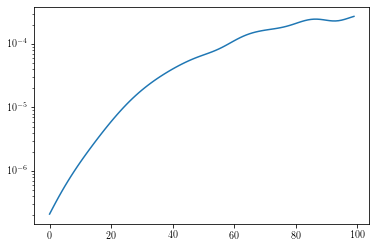

|   iter    |  target   |   beta    |
-------------------------------------
|  2        |  6.782    | -1.273    |
|  31       |  6.784    | -1.142    |
|  32       |  6.784    | -1.03     |
|  33       |  6.784    | -1.05     |
|  35       |  6.784    | -1.05     |
|  49       |  6.784    | -1.051    |
|  60       |  6.784    | -1.046    |
|  70       |  6.784    | -1.048    |
|  73       |  6.784    | -1.049    |
|  75       |  6.784    | -1.049    |
{'target': 6.784130320918911, 'params': {'beta': -1.049394412427088}}


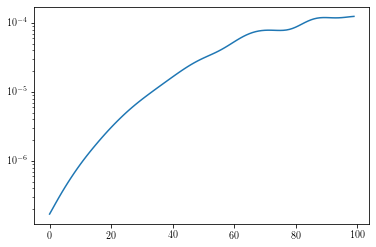

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  6        |  6.095    |  1.966    |  0.8806   |  0.9881   |
|  7        |  6.111    |  0.8019   |  0.4513   |  1.442    |
|  11       |  6.149    |  1.941    |  0.8216   |  1.055    |
|  13       |  6.254    |  1.112    |  0.1658   |  0.5905   |
|  14       |  6.465    |  1.681    |  0.3626   |  0.6816   |
|  23       |  6.567    |  1.787    |  0.1616   |  1.689    |
|  34       |  6.664    |  1.777    |  0.1748   |  1.109    |
{'target': 6.663775476388689, 'params': {'K': 1.7774322376233787, 'a': 0.17477294659707227, 'inputscaling': 1.1090779031630322}}


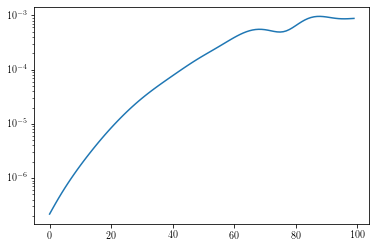

|   iter    |  target   |   beta    |
-------------------------------------
|  2        |  6.741    | -0.5002   |
|  3        |  6.743    | -0.8906   |
|  12       |  6.745    | -1.066    |
|  31       |  6.746    | -1.234    |
|  32       |  6.746    | -1.169    |
{'target': 6.745819586472515, 'params': {'beta': -1.1685729094468047}}


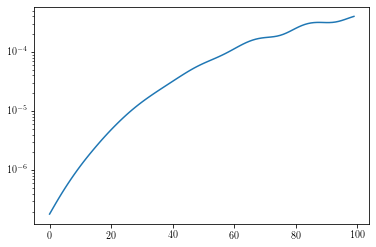

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  3        |  6.181    |  0.8531   |  0.2531   |  0.3799   |
|  6        |  6.522    |  1.653    |  0.2717   |  1.673    |
|  9        |  6.697    |  1.882    |  0.08119  |  1.835    |
|  100      |  6.698    |  1.462    |  0.09308  |  1.274    |
{'target': 6.697841294384536, 'params': {'K': 1.4620087432815019, 'a': 0.09307692273609607, 'inputscaling': 1.2738358509354866}}


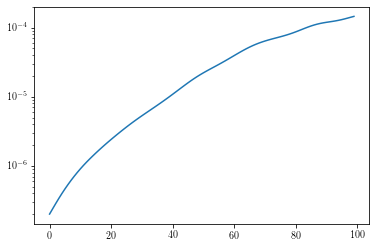

|   iter    |  target   |   beta    |
-------------------------------------
|  2        |  6.736    |  2.801    |
|  4        |  6.779    |  1.329    |
|  7        |  6.801    | -0.7343   |
|  10       |  6.802    | -0.8518   |
|  32       |  6.802    | -0.8603   |
|  33       |  6.802    | -0.8599   |
|  41       |  6.802    | -0.8605   |
|  44       |  6.802    | -0.8624   |
|  46       |  6.802    | -0.8658   |
|  79       |  6.802    | -0.8654   |
{'target': 6.802159090587104, 'params': {'beta': -0.8654447108470619}}


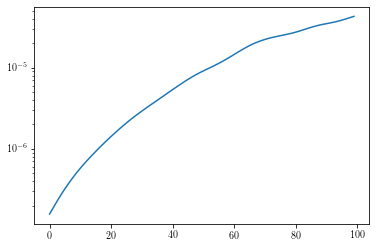

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  3        |  6.456    |  1.253    |  0.2768   |  1.364    |
|  5        |  6.528    |  1.825    |  0.2138   |  0.6073   |
|  6        |  6.66     |  1.978    |  0.1859   |  1.977    |
|  22       |  6.661    |  1.902    |  0.1369   |  1.898    |
|  34       |  6.663    |  1.907    |  0.1125   |  2.0      |
|  50       |  6.675    |  1.77     |  0.1254   |  1.985    |
|  90       |  6.732    |  1.911    |  0.109    |  1.253    |
{'target': 6.7319009417197595, 'params': {'K': 1.9105538928694505, 'a': 0.10899175339954324, 'inputscaling': 1.252923195544921}}


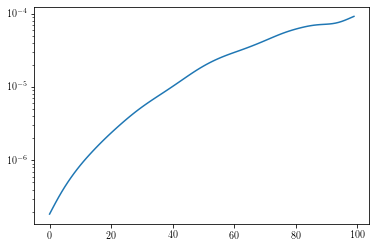

|   iter    |  target   |   beta    |
-------------------------------------
|  31       |  6.832    | -0.6063   |
|  35       |  6.832    | -0.6241   |
|  38       |  6.832    | -0.6092   |
|  46       |  6.832    | -0.628    |
|  47       |  6.832    | -0.6293   |
|  59       |  6.832    | -0.6204   |
{'target': 6.8321403234610045, 'params': {'beta': -0.6203852328406229}}


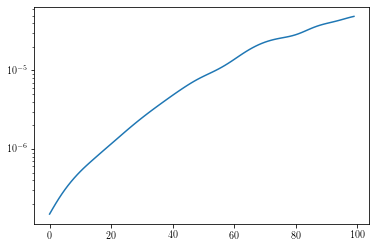

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  5        |  6.242    |  1.1      |  0.197    |  0.4641   |
|  7        |  6.271    |  0.9055   |  0.2461   |  0.9203   |
|  29       |  6.309    |  1.987    |  0.8902   |  0.2496   |
|  36       |  6.491    |  1.173    |  0.1717   |  1.527    |
|  56       |  6.544    |  1.983    |  0.2966   |  0.7687   |
|  93       |  6.554    |  2.0      |  0.3301   |  1.311    |
{'target': 6.554353217877193, 'params': {'K': 2.0, 'a': 0.33014252242281966, 'inputscaling': 1.3106674792639958}}


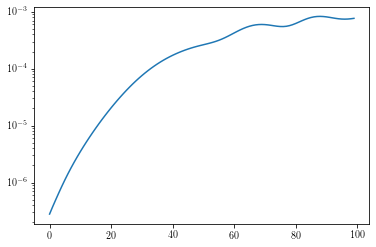

|   iter    |  target   |   beta    |
-------------------------------------
|  2        |  6.591    |  1.016    |
|  6        |  6.6      | -1.368    |
|  34       |  6.6      | -1.407    |
|  42       |  6.6      | -1.373    |
|  50       |  6.6      | -1.361    |
|  53       |  6.6      | -1.357    |
|  68       |  6.6      | -1.357    |
|  88       |  6.6      | -1.357    |
{'target': 6.6004275256212805, 'params': {'beta': -1.3571157842419197}}


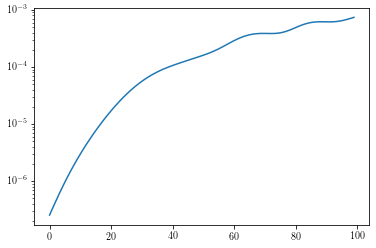

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  22       |  6.529    |  1.726    |  0.336    |  1.382    |
|  34       |  6.682    |  1.778    |  0.1276   |  0.8596   |
|  97       |  6.691    |  1.738    |  0.1506   |  1.447    |
{'target': 6.690763188272301, 'params': {'K': 1.73808444812121, 'a': 0.15063926246240952, 'inputscaling': 1.4465590613586121}}


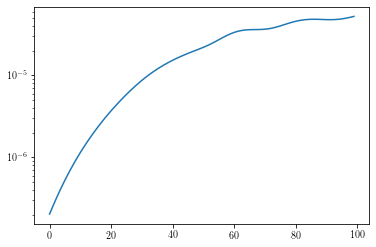

|   iter    |  target   |   beta    |
-------------------------------------
|  2        |  6.752    | -0.359    |
|  13       |  6.752    | -0.5651   |
|  24       |  6.753    | -1.353    |
|  27       |  6.754    | -1.67     |
|  31       |  6.754    | -1.579    |
|  34       |  6.754    | -1.577    |
|  37       |  6.754    | -1.598    |
|  66       |  6.754    | -1.6      |
{'target': 6.7544101557170215, 'params': {'beta': -1.5998951151944398}}


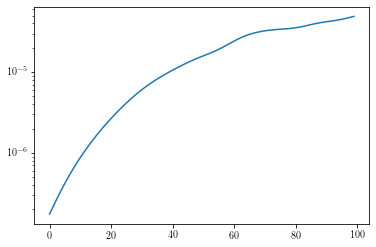

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        |  6.141    |  1.406    |  0.6336   |  1.212    |
|  6        |  6.184    |  1.125    |  0.4711   |  1.378    |
|  8        |  6.502    |  1.716    |  0.3092   |  1.099    |
|  40       |  6.523    |  1.732    |  0.2901   |  1.12     |
|  50       |  6.617    |  1.854    |  0.1632   |  0.7597   |
|  56       |  6.681    |  1.799    |  0.09877  |  0.7592   |
{'target': 6.681479876665247, 'params': {'K': 1.7989629909574305, 'a': 0.09877235093526701, 'inputscaling': 0.7591808187529759}}


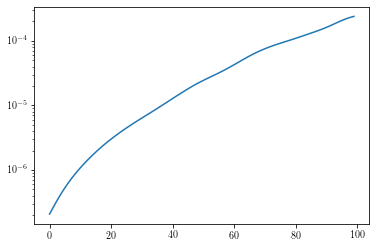

|   iter    |  target   |   beta    |
-------------------------------------
|  12       |  6.743    | -0.6157   |
|  13       |  6.744    | -0.1675   |
|  15       |  6.749    |  0.2963   |
|  32       |  6.749    |  0.3624   |
|  33       |  6.749    |  0.3401   |
|  35       |  6.749    |  0.3461   |
|  51       |  6.749    |  0.341    |
|  65       |  6.749    |  0.3455   |
{'target': 6.748784379070505, 'params': {'beta': 0.34545871895868047}}


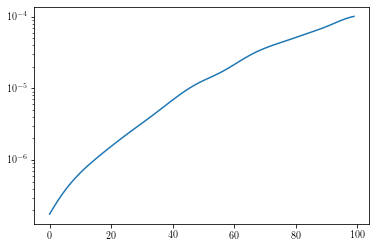

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  3        |  6.13     |  0.9278   |  0.4714   |  1.265    |
|  5        |  6.355    |  1.839    |  0.4148   |  1.652    |
|  14       |  6.369    |  1.696    |  0.4351   |  0.9549   |
|  18       |  6.532    |  1.446    |  0.2034   |  1.582    |
|  84       |  6.639    |  1.997    |  0.1489   |  1.426    |
{'target': 6.639121825451606, 'params': {'K': 1.9967754682570107, 'a': 0.14893830547433598, 'inputscaling': 1.4257866265578774}}


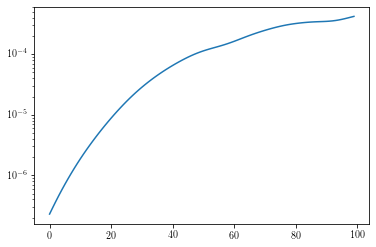

|   iter    |  target   |   beta    |
-------------------------------------
|  6        |  6.708    |  0.2551   |
|  7        |  6.716    | -0.3609   |
|  14       |  6.717    | -0.8517   |
|  37       |  6.717    | -0.8628   |
|  41       |  6.717    | -0.8393   |
|  45       |  6.717    | -0.836    |
|  51       |  6.717    | -0.8422   |
|  56       |  6.717    | -0.8532   |
|  57       |  6.717    | -0.8578   |
|  67       |  6.717    | -0.8545   |
{'target': 6.717345390877787, 'params': {'beta': -0.8544914737846031}}


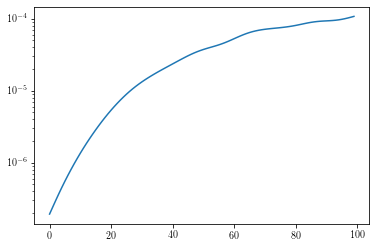

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  6        |  6.363    |  1.809    |  0.4499   |  0.2378   |
|  15       |  6.594    |  1.846    |  0.1791   |  1.406    |
|  23       |  6.687    |  1.842    |  0.08835  |  1.226    |
|  39       |  6.691    |  1.824    |  0.09466  |  1.091    |
{'target': 6.690649745405097, 'params': {'K': 1.8242658400042069, 'a': 0.09465688274542663, 'inputscaling': 1.0913849424780078}}


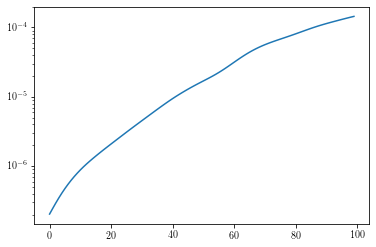

|   iter    |  target   |   beta    |
-------------------------------------
|  5        |  6.75     | -0.4965   |
|  7        |  6.756    |  0.264    |
|  31       |  6.757    |  0.1749   |
|  34       |  6.757    |  0.2183   |
|  35       |  6.757    |  0.2183   |
|  51       |  6.757    |  0.2177   |
|  94       |  6.757    |  0.2176   |
{'target': 6.75696134598358, 'params': {'beta': 0.21757668484584367}}


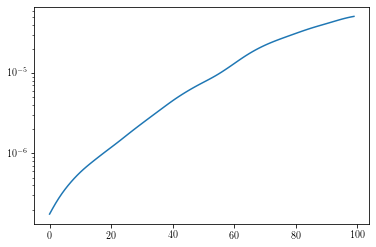

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  4        |  6.113    |  0.8376   |  0.3323   |  0.5661   |
|  7        |  6.343    |  1.491    |  0.3982   |  1.216    |
|  10       |  6.561    |  1.167    |  0.1      |  1.483    |
|  46       |  6.629    |  1.321    |  0.06765  |  1.19     |
|  52       |  6.715    |  1.618    |  0.1      |  1.353    |
{'target': 6.714735863404747, 'params': {'K': 1.6177414353614576, 'a': 0.09999686465875407, 'inputscaling': 1.3534017535961114}}


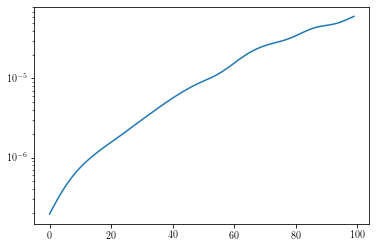

|   iter    |  target   |   beta    |
-------------------------------------
|  7        |  6.762    | -3.091    |
|  10       |  6.775    | -0.8122   |
|  23       |  6.776    | -0.7824   |
|  31       |  6.776    | -0.6815   |
|  32       |  6.776    | -0.7059   |
|  33       |  6.776    | -0.6996   |
|  34       |  6.776    | -0.7048   |
|  44       |  6.776    | -0.6928   |
{'target': 6.775967589322137, 'params': {'beta': -0.6927586469649821}}


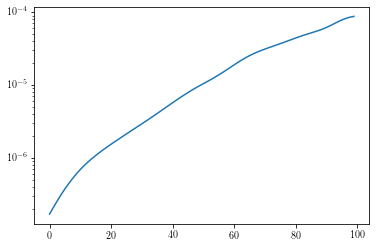

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        |  6.21     |  1.197    |  0.156    |  0.312    |
|  5        |  6.405    |  1.665    |  0.2123   |  0.3636   |
|  16       |  6.412    |  1.325    |  0.3117   |  1.04     |
|  17       |  6.527    |  1.093    |  0.1849   |  1.939    |
|  35       |  6.586    |  1.725    |  0.09862  |  0.7782   |
|  38       |  6.619    |  1.9      |  0.2006   |  0.7648   |
|  50       |  6.669    |  1.832    |  0.1933   |  0.9072   |
|  65       |  6.74     |  1.864    |  0.1223   |  1.123    |
|  87       |  6.76     |  1.734    |  0.1502   |  1.039    |
{'target': 6.759810660773801, 'params': {'K': 1.734116267955645, 'a': 0.15016567028171557, 'inputscaling': 1.038635755675172}}


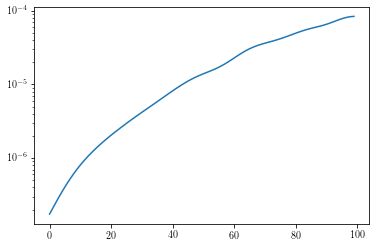

|   iter    |  target   |   beta    |
-------------------------------------
|  18       |  6.798    |  0.2476   |
|  19       |  6.802    | -0.6805   |
|  25       |  6.805    | -0.4393   |
|  31       |  6.805    | -0.3725   |
|  32       |  6.805    | -0.3166   |
|  34       |  6.805    | -0.2851   |
|  37       |  6.805    | -0.2828   |
|  41       |  6.805    | -0.2829   |
|  62       |  6.805    | -0.2854   |
|  64       |  6.805    | -0.2873   |
|  89       |  6.805    | -0.2872   |
|  94       |  6.805    | -0.2872   |
{'target': 6.805363028278657, 'params': {'beta': -0.28716031093373307}}


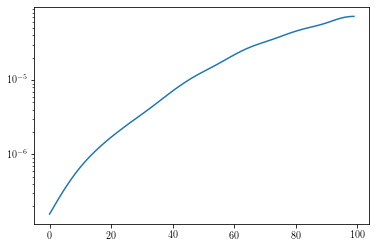

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        |  6.101    |  0.4812   |  0.3271   |  1.718    |
|  4        |  6.36     |  1.467    |  0.395    |  1.604    |
|  8        |  6.414    |  1.943    |  0.3854   |  1.909    |
|  10       |  6.416    |  1.794    |  0.298    |  0.5246   |
|  27       |  6.622    |  1.799    |  0.1986   |  1.189    |
|  34       |  6.649    |  1.866    |  0.1009   |  0.8757   |
{'target': 6.6485377211964805, 'params': {'K': 1.8661723187839057, 'a': 0.10090862583204058, 'inputscaling': 0.8757195995747331}}


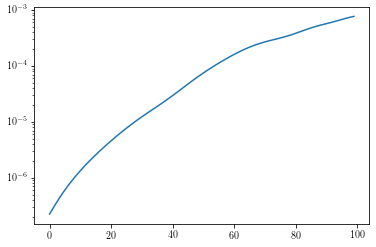

|   iter    |  target   |   beta    |
-------------------------------------
|  2        |  6.733    |  1.091    |
|  4        |  6.743    | -2.594    |
|  5        |  6.751    | -1.729    |
|  11       |  6.759    | -1.05     |
|  31       |  6.759    | -1.016    |
|  37       |  6.759    | -1.016    |
|  39       |  6.759    | -1.016    |
|  61       |  6.759    | -1.02     |
|  93       |  6.759    | -1.02     |
{'target': 6.758754496833673, 'params': {'beta': -1.020172645614416}}


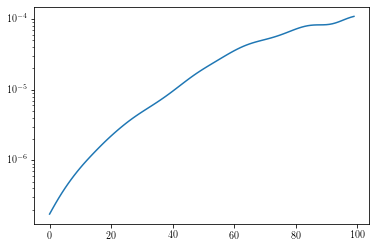

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  17       |  6.6      |  1.763    |  0.09497  |  0.913    |
|  49       |  6.611    |  1.666    |  0.08984  |  0.9091   |
{'target': 6.610911137652311, 'params': {'K': 1.66631107738953, 'a': 0.08983770135065611, 'inputscaling': 0.9090887350723188}}


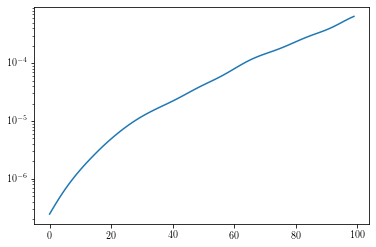

|   iter    |  target   |   beta    |
-------------------------------------
|  2        |  6.635    | -3.952    |
|  14       |  6.637    | -3.865    |
|  22       |  6.641    | -3.609    |
|  28       |  6.642    | -3.512    |
|  34       |  6.642    | -3.507    |
|  52       |  6.642    | -3.511    |
{'target': 6.641851148078661, 'params': {'beta': -3.510502040264706}}


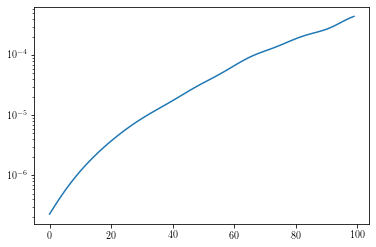

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  5        |  6.411    |  1.981    |  0.4704   |  1.237    |
|  11       |  6.586    |  1.413    |  0.1106   |  1.202    |
{'target': 6.586162575174721, 'params': {'K': 1.4127429721522775, 'a': 0.11056546566685671, 'inputscaling': 1.2020082510363315}}


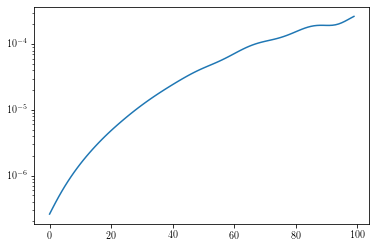

|   iter    |  target   |   beta    |
-------------------------------------
|  2        |  6.642    |  0.4954   |
|  6        |  6.642    | -0.2719   |
|  10       |  6.648    |  1.274    |
|  15       |  6.648    |  1.183    |
|  35       |  6.648    |  1.178    |
|  46       |  6.648    |  1.154    |
|  48       |  6.648    |  1.156    |
|  55       |  6.648    |  1.154    |
{'target': 6.648382358383527, 'params': {'beta': 1.1537784447694024}}


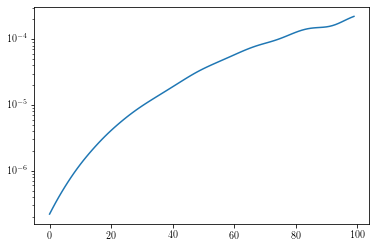

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        |  6.394    |  1.516    |  0.3131   |  1.874    |
|  23       |  6.519    |  1.893    |  0.3458   |  0.8147   |
|  27       |  6.568    |  1.304    |  0.09095  |  0.7345   |
|  48       |  6.639    |  1.312    |  0.06712  |  1.348    |
|  84       |  6.686    |  1.957    |  0.1038   |  0.9699   |
|  93       |  6.701    |  2.0      |  0.1614   |  0.7819   |
{'target': 6.701191865390988, 'params': {'K': 2.0, 'a': 0.16140638519438671, 'inputscaling': 0.7819438657292175}}


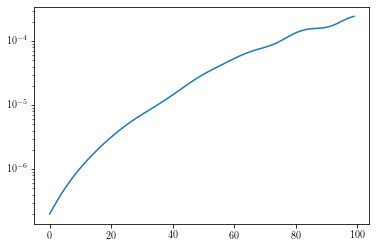

|   iter    |  target   |   beta    |
-------------------------------------
|  2        |  6.741    |  1.348    |
|  3        |  6.759    | -2.51     |
|  5        |  6.762    | -1.869    |
|  8        |  6.764    | -0.5913   |
|  13       |  6.764    | -0.7365   |
|  19       |  6.766    | -1.052    |
|  31       |  6.766    | -1.163    |
|  35       |  6.766    | -1.161    |
|  40       |  6.766    | -1.16     |
{'target': 6.766495639307436, 'params': {'beta': -1.160044634740245}}


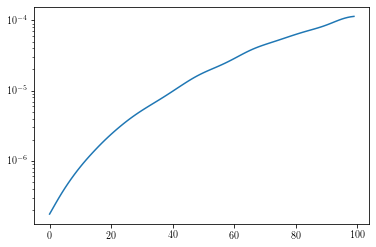

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        |  5.909    |  0.7029   |  0.7076   |  1.599    |
|  3        |  6.279    |  1.291    |  0.4146   |  1.412    |
|  6        |  6.306    |  0.6444   |  0.1855   |  1.834    |
|  13       |  6.383    |  1.49     |  0.2672   |  0.7237   |
|  21       |  6.52     |  1.324    |  0.1892   |  1.908    |
|  43       |  6.591    |  1.241    |  0.06457  |  0.9862   |
|  62       |  6.681    |  1.958    |  0.1221   |  1.468    |
{'target': 6.681316432301239, 'params': {'K': 1.9583427549288193, 'a': 0.12213780542706829, 'inputscaling': 1.467860562089048}}


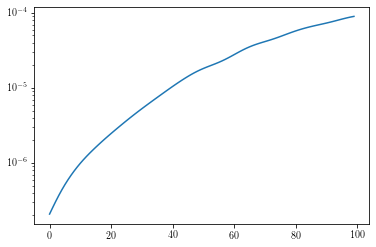

|   iter    |  target   |   beta    |
-------------------------------------
|  4        |  6.791    | -1.485    |
|  8        |  6.801    | -0.854    |
|  34       |  6.801    | -0.8519   |
|  36       |  6.801    | -0.8399   |
|  37       |  6.801    | -0.8353   |
|  39       |  6.801    | -0.8472   |
|  87       |  6.801    | -0.8476   |
{'target': 6.801230176713291, 'params': {'beta': -0.8476115675269944}}


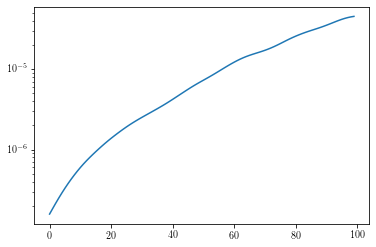

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        |  5.792    |  0.598    |  0.792    |  0.6489   |
|  3        |  6.411    |  1.729    |  0.4475   |  1.096    |
|  14       |  6.508    |  1.544    |  0.2875   |  1.303    |
|  25       |  6.613    |  1.853    |  0.0799   |  1.233    |
|  50       |  6.627    |  1.971    |  0.181    |  1.865    |
{'target': 6.626570759390981, 'params': {'K': 1.9711474323047224, 'a': 0.1809719208234166, 'inputscaling': 1.8645056005040288}}


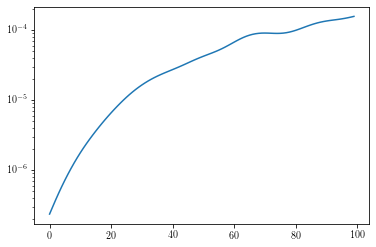

|   iter    |  target   |   beta    |
-------------------------------------
|  3        |  6.72     | -2.151    |
|  4        |  6.721    | -2.01     |
|  6        |  6.724    | -1.755    |
|  8        |  6.728    | -0.5249   |
|  10       |  6.73     | -1.428    |
|  30       |  6.732    | -1.194    |
|  34       |  6.732    | -1.22     |
|  40       |  6.732    | -1.217    |
|  67       |  6.732    | -1.214    |
|  89       |  6.732    | -1.214    |
{'target': 6.731992424970178, 'params': {'beta': -1.2139797305998965}}


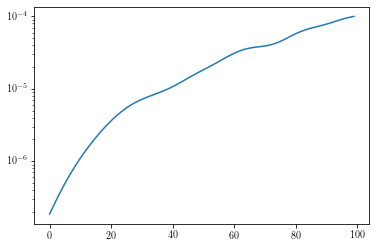

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  3        |  6.453    |  1.094    |  0.2104   |  1.54     |
|  22       |  6.568    |  1.979    |  0.2713   |  1.189    |
|  46       |  6.591    |  1.983    |  0.2433   |  1.158    |
|  52       |  6.599    |  1.974    |  0.2315   |  1.192    |
|  55       |  6.624    |  1.991    |  0.1962   |  1.175    |
{'target': 6.624167925955733, 'params': {'K': 1.9907814596365445, 'a': 0.19615004613542017, 'inputscaling': 1.1753170465848677}}


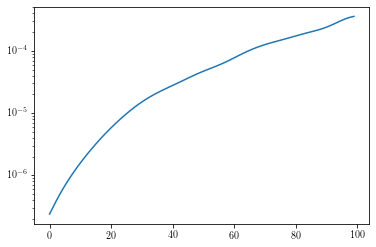

|   iter    |  target   |   beta    |
-------------------------------------
|  20       |  6.702    | -1.878    |
|  25       |  6.705    | -1.448    |
|  31       |  6.707    | -1.276    |
|  46       |  6.707    | -1.264    |
|  82       |  6.707    | -1.264    |
{'target': 6.706675065267695, 'params': {'beta': -1.264268834913985}}


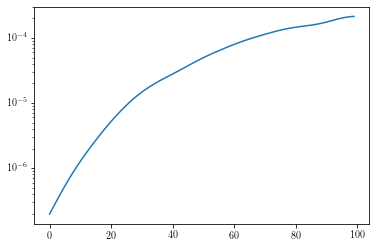

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  6        |  6.389    |  1.12     |  0.3136   |  1.776    |
|  17       |  6.471    |  1.833    |  0.3877   |  0.5899   |
|  19       |  6.506    |  1.678    |  0.1786   |  0.4542   |
|  69       |  6.651    |  1.414    |  0.1338   |  1.466    |
|  80       |  6.748    |  1.459    |  0.09011  |  1.776    |
{'target': 6.747761484053179, 'params': {'K': 1.4591737713436572, 'a': 0.09010979291656665, 'inputscaling': 1.7761310069735288}}


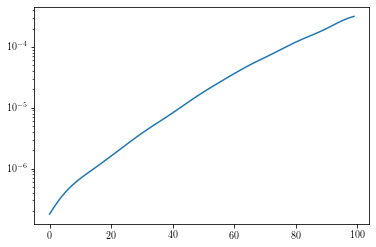

|   iter    |  target   |   beta    |
-------------------------------------
|  4        |  6.842    | -1.037    |
|  7        |  6.842    | -0.918    |
|  20       |  6.842    | -1.089    |
|  31       |  6.842    | -0.9052   |
|  34       |  6.843    | -0.9617   |
|  50       |  6.843    | -0.9625   |
{'target': 6.842528180518273, 'params': {'beta': -0.9625024729947538}}


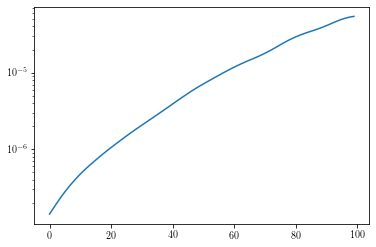

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        |  6.415    |  1.288    |  0.2842   |  1.899    |
|  10       |  6.441    |  1.739    |  0.35     |  0.6158   |
|  14       |  6.66     |  1.686    |  0.1245   |  1.486    |
{'target': 6.660416960488293, 'params': {'K': 1.6857494579596262, 'a': 0.12445581819060711, 'inputscaling': 1.4858410846941472}}


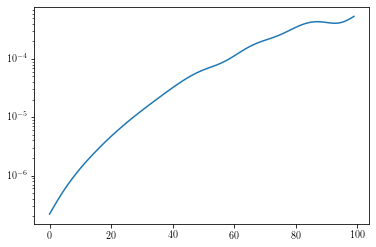

|   iter    |  target   |   beta    |
-------------------------------------
|  3        |  6.751    | -1.567    |
|  8        |  6.754    | -1.12     |
|  31       |  6.754    | -1.242    |
|  32       |  6.754    | -1.203    |
|  78       |  6.754    | -1.202    |
|  82       |  6.754    | -1.202    |
{'target': 6.7541509497748775, 'params': {'beta': -1.2017530117662973}}


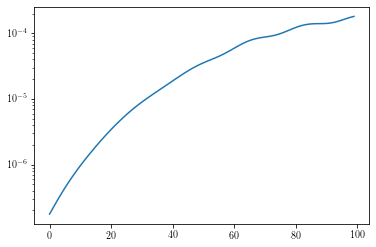

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        |  6.542    |  1.237    |  0.09828  |  1.24     |
|  12       |  6.609    |  1.486    |  0.07875  |  0.9753   |
|  32       |  6.614    |  1.519    |  0.1012   |  0.978    |
|  36       |  6.683    |  1.562    |  0.06975  |  1.305    |
{'target': 6.682596905667351, 'params': {'K': 1.5620377010741333, 'a': 0.06974920568603535, 'inputscaling': 1.305170699597498}}


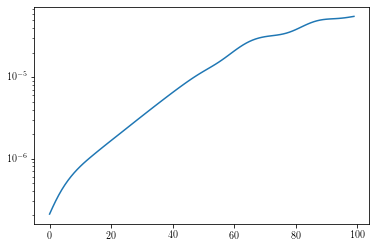

|   iter    |  target   |   beta    |
-------------------------------------
|  2        |  6.729    | -4.739    |
|  3        |  6.769    | -2.892    |
|  4        |  6.774    |  1.184    |
|  10       |  6.791    |  0.2113   |
|  14       |  6.804    | -0.8231   |
|  19       |  6.804    | -1.315    |
|  21       |  6.805    | -1.195    |
|  30       |  6.805    | -1.051    |
|  31       |  6.806    | -0.9735   |
|  35       |  6.806    | -0.9806   |
|  36       |  6.806    | -0.98     |
|  37       |  6.806    | -0.979    |
|  59       |  6.806    | -0.9844   |
|  75       |  6.806    | -0.984    |
{'target': 6.805847775507092, 'params': {'beta': -0.9839863652822822}}


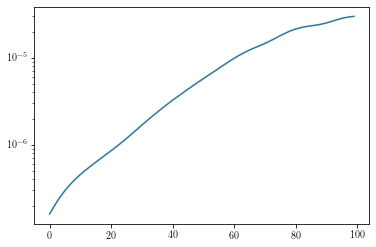

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  3        |  6.473    |  1.655    |  0.2645   |  0.9568   |
|  14       |  6.485    |  1.554    |  0.2457   |  1.422    |
|  28       |  6.5      |  1.422    |  0.2114   |  1.403    |
|  47       |  6.514    |  1.39     |  0.15     |  1.28     |
{'target': 6.514213702149582, 'params': {'K': 1.3898715375125785, 'a': 0.14999343110979646, 'inputscaling': 1.2796453873413798}}


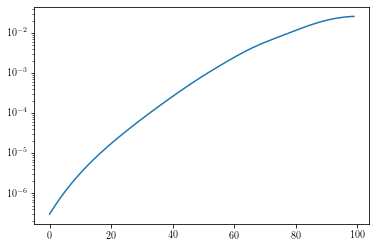

|   iter    |  target   |   beta    |
-------------------------------------
|  2        |  6.603    |  0.6117   |
|  3        |  6.608    | -0.4512   |
|  4        |  6.613    | -1.478    |
|  8        |  6.614    | -2.355    |
|  31       |  6.615    | -2.199    |
|  34       |  6.615    | -2.154    |
|  38       |  6.615    | -2.154    |
{'target': 6.615312589097788, 'params': {'beta': -2.154169698481062}}


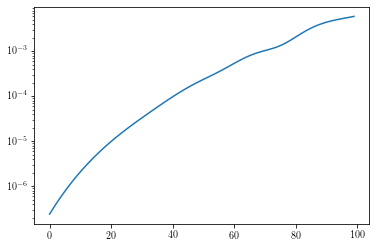

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  3        |  6.111    |  1.603    |  0.7573   |  1.343    |
|  6        |  6.409    |  1.853    |  0.3251   |  0.5063   |
|  17       |  6.624    |  1.883    |  0.1209   |  1.765    |
{'target': 6.6241232431010415, 'params': {'K': 1.883349403064053, 'a': 0.12094658188760683, 'inputscaling': 1.765450708683031}}


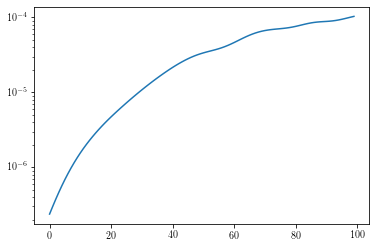

|   iter    |  target   |   beta    |
-------------------------------------
|  11       |  6.719    | -1.084    |
|  18       |  6.719    | -2.468    |
|  28       |  6.72     | -2.648    |
|  80       |  6.72     | -2.648    |
{'target': 6.719673950381666, 'params': {'beta': -2.64771642333241}}


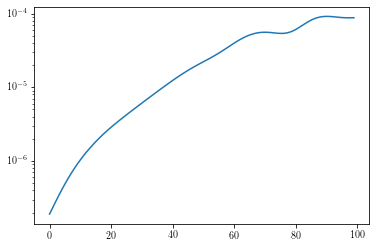

|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  2        |  5.869    |  0.485    |  0.5311   |  0.5711   |
|  4        |  6.555    |  1.534    |  0.05143  |  1.551    |
|  31       |  6.694    |  1.527    |  0.06497  |  1.553    |
|  71       |  6.714    |  1.698    |  0.07761  |  1.541    |
{'target': 6.713901485930606, 'params': {'K': 1.6981919665956955, 'a': 0.07760502361851186, 'inputscaling': 1.541458871371909}}


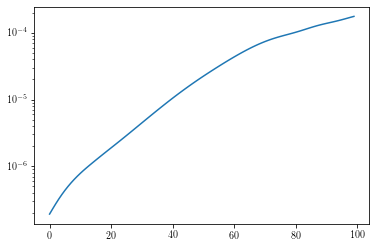

|   iter    |  target   |   beta    |
-------------------------------------
|  2        |  6.743    |  4.717    |
|  3        |  6.783    | -0.1614   |
|  25       |  6.784    | -0.7039   |


ValueError: LBFGSB - one of the lower bounds is greater than an upper bound.

In [196]:



filename = path+'/esn2attn_bayesopt.csv'
if os.path.exists(filename):
    os.remove(filename)

for inputdata, dim in zip(
    [
        'x',
#         'y',
#         'z', 
#         'xyz'
#         'xy',
#         'yz',
#         'xz'
    ],[
        [0],
#         [1],
#         [2],
#         [0,1,2]
#         [0,1],
#         [1,2],
#         [0,2]
    ]):
    print(inputdata)
    system_name = 'Lorenz'
    Y = np.loadtxt('dataset/matlab_gendata/'+system_name+'.csv', delimiter=',').T
    U0 = Y[dim].copy()
    U = U0 + np.random.randn(*U0.shape)*1e-3
    U = np.atleast_2d(U)

    num_prepare = 1000
    train_start = num_prepare
    num_train = 10000
    val_start = num_prepare + num_train
    num_val = 1000
    test_start = num_prepare + num_train + num_val
    num_test = 5000
    print('U shape:', U.shape)
    print('Y shape:', Y.shape)


    inSize = U.shape[0]
    resSize = 100

    U_train = U[:,train_start : train_start + num_train]
    Y_train = Y[dim,train_start + 1 : train_start + num_train + 1]
    Y_test = Y[dim,test_start + 1 : test_start + num_test + 1]

        
    for seed in range(100):
        print(seed)
        random.seed(seed) 
        np.random.seed(seed)

        Win0 = (np.random.rand(resSize,1+inSize)-0.5) * 2
        W0 = np.random.rand(resSize,resSize)-0.5
        largest_eigvals, _ = largest_eigsh(W0@W0.T, 1, which='LM')
        rhoW = np.sqrt(largest_eigvals[0])


        # --------------------- stage 1 -----------------------
        eps = 1e-8
        pbounds = {
            'a': (eps, 1), 
            'K': (eps, 2),
            'inputscaling': (eps,2),
        }
#         bounds_transformer = SequentialDomainReductionTransformer()
        optimizer = BayesianOptimization(
            f=black_box,
            pbounds=pbounds,
            verbose=1, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
            random_state=seed,
#             bounds_transformer=bounds_transformer
        )
        optimizer.maximize(
            init_points=30,
            n_iter=70,
        )
        print(optimizer.max)

        params = optimizer.max['params']
        target1 = optimizer.max['target']
        a, K, inputscaling = params['a'], params['K'], params['inputscaling']
        multistep_prediction(a, K, inputscaling)
        
        # -------------------------- stage 2 --------------------------
        N_c = 100
        W = W0/rhoW*K 
        Win = Win0*inputscaling
        X = np.zeros((resSize,U.shape[1]))
        x = np.zeros([resSize,1])
        for t in range(U.shape[1]):
            u = U[:,t:t+1]
            x = (1-a) * x + a * np.tanh(Win @ np.vstack((1,u)) + W @ x) 
            X[:,t:t+1] = x

        X_train = X[:,train_start : train_start + num_train]
        X_test = X[:,test_start : test_start + num_test]
        Ml, Diag, Mr = np.linalg.svd(X_train, full_matrices=False)
        tau = svht(X_train, sv=Diag)
        N_v = np.sum(Diag>tau)
        MlT, Diag, Mr = Ml.T[:N_v], Diag[:N_v], Mr[:N_v]
        Cs = clustering((np.diag(Diag)@ Mr).T, N_c)  # N_c, N_v

        pbounds2 = {
            'beta': (-5,5),
        }
        bounds_transformer2 = SequentialDomainReductionTransformer()
        optimizer2 = BayesianOptimization(
            f=partial_black_box_attn,
            pbounds=pbounds2,
            verbose=1, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
            random_state=seed,
            bounds_transformer=bounds_transformer2
        )
        optimizer2.maximize(
            init_points=30,
            n_iter=70,
        )
        print(optimizer2.max)
        beta = optimizer2.max['params']['beta']
        target2 = optimizer2.max['target']
        multistep_prediction_attn(a, K, inputscaling,beta)
        
        with open(filename, 'a') as file:
            file.write('{},{},{},{},{},{},{}\n'.format(seed, target1, target2, a, K, inputscaling, beta))




In [8]:
filename = path + '/esn2attn_bayesopt.csv'
header = ['seed', 'target1', 'target2', 'a', 'K', 'inputscaling', 'beta']
df = pd.read_csv(filename, names=header)
df

,seed,target1,target2,a,K,inputscaling,beta
0,0,6.739035,6.805215,0.080306,1.507217,1.437231,-1.238841
1,1,6.701522,6.852871,0.069168,1.653440,1.563545,-1.102349
2,2,6.685804,6.826426,0.172997,2.000000,0.799354,-1.235793
3,3,6.713121,6.844438,0.100739,2.000000,1.514692,-1.101696
4,4,6.760965,6.805102,0.070388,1.286110,1.703723,-0.840201
5,5,6.691418,6.805186,0.078757,1.485087,1.920907,-0.838667
6,6,6.635694,6.703262,0.167907,1.914955,1.766809,0.259041
7,7,6.558445,6.647560,0.133169,1.818257,1.046825,0.401077
8,8,6.651518,6.741253,0.130774,2.000000,1.698904,-0.705544
9,9,6.675751,6.788851,0.110478,1.499251,0.847457,0.648752


Text(0, 0.5, 'MSE2')

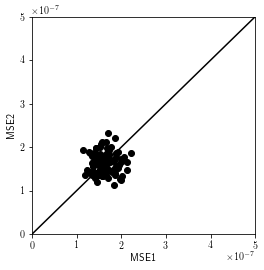

In [4]:
plt.figure(figsize=(4,4))
plt.scatter(10**-df['target1'],10**-df['target2'], color='k')
# plt.plot()
plt.plot([0,1], 'k')
plt.xlim([0e-7,5e-7])
plt.ylim([0e-7,5e-7])
plt.xlabel('MSE1')
plt.ylabel('MSE2')

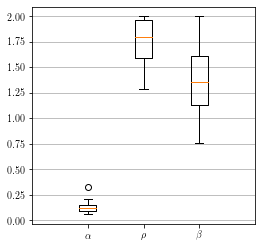

In [9]:
fig, ax = plt.subplots(figsize=(4,4))


# ax.violinplot([df['a'], df['K'], df['inputscaling']],
#                showmeans=False,
#                showmedians=True,
#               showextrema=False,
#               quantiles=[[0.25,0.5,0.75]]*3
#                )

ax.boxplot([df['a'], df['K'], df['inputscaling']])

ax.yaxis.grid(True)
ax.set_xticks([y+1 for y in range(3)], )

ax.set_xlim([0,4])
plt.setp(ax, xticks=[y+1 for y in range(3)],
        xticklabels=[r'$\alpha$', r'$\rho$', r'$\beta$'],
        )
plt.savefig(path+'/params_bo.pdf', transparent=True)
plt.show()